<a href="https://colab.research.google.com/github/heber-augusto/sus-kpis-analysis/blob/datajoedata-patch-1/sim/eda_obitos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Parte I**:  
#**Apresentação**:

Este notebook faz parte do projeto Monitor Rosa, uma iniciativa que visa aprimorar o cenário de diagnósticos de câncer de mama no Brasil. O projeto é composto por um conjunto de ferramentas, softwares e outros recursos, com o objetivo principal de aumentar a conscientização sobre a relevância do diagnóstico precoce dessa patologia que impacta muitas mulheres. Além disso, busca se tornar um valioso fornecedor de insights para gestores públicos.

### **1.1 -  Fonte de Dados**:

Os dados utilizados neste notebook foram coletados por meio de scripts que acessam os servidores do Sistema Único de Saúde (SUS) por protocolos HTTP. Esses dados são extraídos e armazenados em um repositório na plataforma Google Cloud Platform (GCP) no formato GZIP.
### (**Para mais informações sobre a extração dos arquivos checar este [repositório](https://github.com/heber-augusto/devops-pysus-get-files)**).


### **1.2 - Dados do SIM**:

Os arquivos manipulados neste notebook se baseiam nos dados provenientes do Sistema de Informações sobre Mortalidade (SIM). Esse sistema abriga informações relacionadas a óbitos registrados em todo o Brasil, juntamente com diversos indicadores associados. Cada observação ou "registro" deste dataset representa uma Declaração de Óbito ou (DO).   

### **1.3 - Objetivos Específicos**:

A finalidade deste notebook é realizar uma análise de dados, concentrando-se nos obituários relacionados ao câncer de mama no contexto brasileiro. Isso inclui filtrar e analisar dados relevantes para fornecer insights que possam contribuir para a compreensão e o enfrentamento dessa questão de saúde.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Parte II**:  
# **Configuração do ambiente e carregamento do catálogo**

## 2.1 - Escolha do ambiente
São disponibilizadas duas opções de execução (dependendo do arquivo de credencial utilizado)
 - gcp-leitura.json: disponível para analises e usuários que não possuem permissão de escrita;
 - gcp-escrita.json: disponível para atualização de bases (testes de desenvolvimento ou ambiente de produção).

In [ ]:
import os
if os.path.isfile('/content/monitor-rosa-leitura.json'):
    datalake_mode = 'leitura'
    %env SERVICE_ACCOUNT_USER=acesso-leitura@monitor-rosa.iam.gserviceaccount.com
    %env SERVICE_ACCOUNT_JSON=/content/monitor-rosa-leitura.json
elif os.path.isfile('/content/monitor-rosa-escrita.json'):
    datalake_mode = 'escrita'
    %env SERVICE_ACCOUNT_USER=acesso-escrita@monitor-rosa.iam.gserviceaccount.com
    %env SERVICE_ACCOUNT_JSON=/content/monitor-rosa-escrita.json
else:
    assert(os.path.isdir('/content/drive/Shareddrives/monitor-rosa-gold') == True)
    datalake_mode = 'shared_drive'
    %env SERVICE_ACCOUNT_USER=''
    %env SERVICE_ACCOUNT_JSON=''
datalake_mode

env: SERVICE_ACCOUNT_USER=''
env: SERVICE_ACCOUNT_JSON=''


'shared_drive'

In [ ]:
!rm -r sus-kpis-analysis
!git clone https://github.com/heber-augusto/sus-kpis-analysis.git

rm: cannot remove 'sus-kpis-analysis': No such file or directory
Cloning into 'sus-kpis-analysis'...
remote: Enumerating objects: 1719, done.
remote: Counting objects: 100% (255/255), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 1719 (delta 104), reused 203 (delta 83), pack-reused 1464 (from 1)
Receiving objects: 100% (1719/1719), 3.18 MiB | 21.74 MiB/s, done.
Resolving deltas: 100% (805/805), done.


## 2.2 - Instalação de libs Python, inicialização de variáveis de ambiente e configuração/instalação do Spark

In [ ]:
!pip install -r /content/sus-kpis-analysis/sia/etls/requirements.txt

%env PYTHONHASHSEED=1234
%env JAVA_HOME=/usr/lib/jvm/java-8-openjdk-amd64
%env SPARK_HOME=/content/spark-3.4.3-bin-hadoop3
%env SPARK_VERSION=3.4.3

!source /content/sus-kpis-analysis/sia/etls/bin/setup_spark_env.sh '/content/'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 68.1 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.4.3-py2.py3-none-any.whl size=311885495 sha256=2548ebf1a9cb91eb35783081ee37e41940ee6928132f5b4e3d17709dd78ed56c
  Stored in directory: /root/.cache/pip/wheels/ea/a9/64/3713eb2c5048c18bae2778b013e5fc74203f5c22d4640fb776
Successfully built pyspark
env: PYTHONHASHSEED=1234
env: JAVA_HOME=/usr/lib/jvm/java-8-openjdk-amd64
env: SPARK_HOME=/content/spark-3.4.3-bin-hadoop3
env: SPARK_VERSION=3.4.3
starting spark env setup 
installing and downloading packages
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat

In [ ]:
if datalake_mode != 'shared_drive':
    %env XDG_CONFIG_HOME=/content/datalake
    !source /content/sus-kpis-analysis/sia/etls/bin/install-google-drive-ocamlfuse.sh
    !source /content/sus-kpis-analysis/sia/etls/bin/mount_google_drive_v2.sh '/content/datalake' $SERVICE_ACCOUNT_USER '0ABIY-a4qrdY9Uk9PVA' 'monitor-rosa-bronze' $SERVICE_ACCOUNT_JSON '/content'
    !source /content/sus-kpis-analysis/sia/etls/bin/mount_google_drive_v2.sh '/content/datalake' $SERVICE_ACCOUNT_USER '0ALl0owLNr53oUk9PVA' 'monitor-rosa-silver' $SERVICE_ACCOUNT_JSON '/content'
    !source /content/sus-kpis-analysis/sia/etls/bin/mount_google_drive_v2.sh '/content/datalake' $SERVICE_ACCOUNT_USER '0AMHp9pBeLvZiUk9PVA' 'monitor-rosa-gold' $SERVICE_ACCOUNT_JSON '/content'


## 2.3 - Inicializa variáveis de acesso ao delta lake criado no google storage

- Local do arquivo de credencial do storage, diretorio do warehouse e path do spark:

> O arquivo json_file_name deve ser enviado para o ambiente e deve ser utilizado um com as devidas permissões (em caso de escrita)

> O caminho do warehouse pode ser alterado em caso de testes de escritas locais.

> O caminho do spark é setado pelo script de configuração

In [ ]:
import os

lake_prefix = "temp-output"

if datalake_mode in ('leitura','shared_drive',):
    warehouse_dir = f"/content/datalake/{lake_prefix}/"

if datalake_mode == 'escrita':
    warehouse_dir = f"/content/datalake/"

spark_path = os.getenv('SPARK_HOME')
spark_path

'/content/spark-3.4.3-bin-hadoop3'

## 2.4 - Inclusão da pasta do repositório no python path

Procedimento permite que funções e classes presentes no repositório sejam utilizadas

In [ ]:
import sys
sys.path.append('/content/sus-kpis-analysis')
sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor',
 '/root/.ipython',
 '/content/sus-kpis-analysis']

## 2.5 - Importação de funções utilizadas pelo código

In [ ]:
from sia.etls.lib.catalog_loader import DeltaLakeDatabaseFsCreator, load_entire_catalog_fs, load_entire_catalog_fs_v2
from sia.etls.lib.table_utilities import vacuum_tables_from_database, table_exists
from sia.etls.lib.fs_spark_session import create_fs_spark_session
from sia.etls.lib.bronze_files_utilities import get_pending_files_from_bronze
from sia.etls.lib.delta_table_creators import ParquetToDelta

## 2.6 -  Cria Sessão Spark conectada ao Delta Lake presente no Google Storage

In [ ]:
spark = create_fs_spark_session(
    warehouse_dir=warehouse_dir,
    spark_path=spark_path
)

## 2.7 - Refresh do catálogo para utilizar consultas

In [ ]:
zone_names = ['monitor-rosa-bronze', 'monitor-rosa-silver', 'monitor-rosa-gold']
if datalake_mode in ('leitura', 'escrita'):
    zone_paths = [f'/content/datalake/{zone_name}/databases' for zone_name in zone_names]
else:
    zone_paths = [f'/content/drive/Shareddrives/{zone_name}/databases' for zone_name in zone_names]


# carrega catalogo de banco de dados, na zona bronze
table_filter =  None #['demografia_municipios', 'dores']            #->>>> Utilizando 'None' como argumento aqui lista todas as tabelas.
database_filter = ['sim_bronze.db','cancer_data.db', ]       #->>>> Utilizando 'None' como argumento lista todos os bancos de dados.

for databases_path in zone_paths:
    load_entire_catalog_fs_v2(
        spark_session = spark,
        databases_path = databases_path,
        use_db_folder_path=(datalake_mode == 'escrita'),
        database_filter=database_filter,
        table_filter=table_filter
    )

['sia_bronze.db', 'cnes_bronze.db', 'sih_bronze.db', 'sim_bronze.db']
Banco de dados sim_bronze criado.
listando conteúdos do caminho /content/drive/Shareddrives/monitor-rosa-bronze/databases e database sim_bronze
prefix: /content/drive/Shareddrives/monitor-rosa-bronze/databases/sim_bronze.db/
table_list: ['dores']
Tabela dores criada
Tabela dores criada com comando CREATE TABLE IF NOT EXISTS sim_bronze.dores USING delta LOCATION '/content/drive/Shareddrives/monitor-rosa-bronze/databases/sim_bronze.db/dores'
Recriação das tabelas concluída.
['cancer_data.db']
Banco de dados cancer_data criado.
listando conteúdos do caminho /content/drive/Shareddrives/monitor-rosa-silver/databases e database cancer_data
prefix: /content/drive/Shareddrives/monitor-rosa-silver/databases/cancer_data.db/
table_list: ['aq_filtered', 'ar_filtered', 'dados_estados_mensal', 'dados_municipios_mensal', 'pacientes', 'procedimentos', 'procedimentos_e_pacientes', 'demografia_municipios', 'cadastro_municipios']
Tabel

# **Parte III**:  
# **Exemplo de como listar e acessar os bancos de dados e tabelas:**


#### 3.1 - (Com esse comando podemos listar e visualizar todos os bancos de dados existentes no projeto)

In [ ]:
databases = spark.sql(f"SHOW DATABASES;")
databases.show()

+-----------+
|  namespace|
+-----------+
|cancer_data|
|    default|
| sim_bronze|
+-----------+



#### 3.2 - (Com esse comando podemos iterar por todos os bancos de dados e visualizar todas as tabelas existentes em cada banco de dados no projeto)

In [ ]:
for row in databases.collect():
    spark.sql(f"SHOW TABLES FROM {row['namespace']};").show(truncate=False)

+-----------+-------------------------+-----------+
|namespace  |tableName                |isTemporary|
+-----------+-------------------------+-----------+
|cancer_data|aq_filtered              |false      |
|cancer_data|ar_filtered              |false      |
|cancer_data|cadastro_municipios      |false      |
|cancer_data|dados_estados_mensal     |false      |
|cancer_data|dados_municipios_mensal  |false      |
|cancer_data|demografia_municipios    |false      |
|cancer_data|pacientes                |false      |
|cancer_data|procedimentos            |false      |
|cancer_data|procedimentos_e_pacientes|false      |
+-----------+-------------------------+-----------+

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
+---------+---------+-----------+

+----------+---------+-----------+
|namespace |tableName|isTemporary|
+----------+---------+-----------+
|sim_bronze|dores    |false      |
+----------+---------+-----------+



# **Parte IV**:  
# **Primeiras visualizações:**

### **4.1 - Primeira visualização de arquivos do Sistema de Informações sobre Mortalidade(SIM)**
(Equivalente ao método head do pandas)

In [ ]:
df_prim_viz_sim = spark.sql("SELECT * FROM sim_bronze.dores LIMIT 5").show()

+--------+--------+--------+---------+-------+--------+-----+----+-------+------+---+------+---------+---------+-------+--------+----------+----------+--------+------+-------+----------+----------+--------+--------+-----+----------+----+---------+----------+---------+-----+--------+---------+------+------+------+------+-------+--------+--------+----------+---------+--------+-----+-----+----------+----------+----------+---------+--------+---------+--------+------+--------------------+----------------------+--------------------+-------------------+----------+----------+------+----------+-------+----------+---------+-------+----------+----------+----------+----------+----------+----------+---------+--------+-------+----------+--------+--------+--------+--------+---------+----------+----------+----------+----+----------+----------+----------+----------+---------+-----------------+----------+----------+----------+----------+------+----------+----------+---------+---------+--------+
|CONTADO

### **4.2 - Primeira visualização de arquivos da tabela "demografia_municipios"**

In [ ]:
df_prim_viz_demo = spark.sql("""SELECT * FROM cancer_data.demografia_municipios LIMIT 5""").show()

+-----------+----------+---------------+--------------+------------+--------------------+----+---------+-----------+
|codigo_sexo|valor_sexo|codigo_situacao|valor_situacao|codigo_local|          nome_local| ano|populacao|faixa_idade|
+-----------+----------+---------------+--------------+------------+--------------------+----+---------+-----------+
|          4|    Homens|              0|         Total|     1100015|Alta Floresta D'O...|2010|    12656|      Total|
|          4|    Homens|              0|         Total|     1100023|      Ariquemes - RO|2010|    45543|      Total|
|          4|    Homens|              0|         Total|     1100031|         Cabixi - RO|2010|     3266|      Total|
|          4|    Homens|              0|         Total|     1100049|         Cacoal - RO|2010|    39124|      Total|
|          4|    Homens|              0|         Total|     1100056|     Cerejeiras - RO|2010|     8551|      Total|
+-----------+----------+---------------+--------------+---------

### **4.3 - Contando valores nulos nos dois datasets:**

Tabela com dados demográficos:

In [ ]:
from pyspark.sql.functions import col, count, when, isnan

df = spark.sql("SELECT * FROM cancer_data.demografia_municipios")

# Contando nulos em cada coluna
null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])

# Mostrando o resultado
null_counts.show()

+-----------+----------+---------------+--------------+------------+----------+---+---------+-----------+
|codigo_sexo|valor_sexo|codigo_situacao|valor_situacao|codigo_local|nome_local|ano|populacao|faixa_idade|
+-----------+----------+---------------+--------------+------------+----------+---+---------+-----------+
|          0|         0|              0|             0|           0|         0|  0|        0|          0|
+-----------+----------+---------------+--------------+------------+----------+---+---------+-----------+



Tabela com registros do SIM:

In [ ]:
from pyspark.sql.functions import col, count, when, isnan

# Supondo que df seja o seu DataFrame
df = spark.sql("SELECT * FROM sim_bronze.dores")

# Contando nulos em cada coluna
null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])

# Mostrando o resultado
null_counts.show()

+--------+--------+-------+---------+-------+------+-----+----+-------+------+---+----+---------+---------+-------+--------+----------+----------+--------+------+-------+----------+----------+--------+--------+-----+----------+----+---------+----------+---------+-----+--------+---------+------+------+------+------+-------+--------+--------+----------+---------+--------+-----+-----+----------+----------+----------+---------+--------+---------+--------+-------+---------+----------------------+---------+----------------+----------+----------+-------+----------+--------+----------+---------+-------+----------+----------+----------+----------+----------+----------+---------+--------+-------+----------+--------+--------+--------+--------+---------+----------+----------+----------+-------+----------+----------+----------+----------+---------+--------+----------+----------+----------+----------+-------+----------+----------+---------+---------+--------+
|CONTADOR|TIPOBITO|DTOBITO|HORAOBITO|NAT

A partir da contagem de valores nulos na tabela SIM foi possível verificar que a coluna 'DTOBITO' possui 0 valores nulos e por isso será escolhida como parâmetro temporal.



# **Parte V**:
### **Utilizando códigos Cid-10 para filtrar apenas os óbitos relacionados**
### **ao câncer de mama.**

### **5.1 - Mas primeiro, o que é o CID-10?**

A tradução do nome CID-10, "Código Internacional de Doenças" deixa claro seu propósito:

###**É uma forma de classificar quadros clínicos de forma padronizada e internacional.**
 O código CID-10 age como uma poderosa chave estrangeira para os serviços de informações sobre saúde.

#### **Todas as colunas que possuem este código serão consideradas na hora de separar os óbitos pertinentes ao nosso contexto, afinal é de grande interesse ressaltar que o câncer de mama também pode ser causa secundária ou causa agravante de outros casos clínicos. Então se o encontrarmos em uma coluna que não represente a causa mortis final, ainda é interessante inseri-la no contexto da pesquisa**.

### **5.2 - Definição de valores dos códigos CID-10 relacionados ao contexto do câncer de mama:**





- **C50**,  Neoplasia maligna da mama;


- **C501**, Neoplasia maligna da porção central da mama;


- **C502**, Neoplasia maligna do quadrante superior interno da mama;


- **C503**, Neoplasia maligna do quadrante inferior interno da mama;


- **C504**, Neoplasia maligna do quadrante superior externo da mama;


- **C505**, Neoplasia maligna do quadrante inferior externo da mama;


- **C506**, Neoplasia maligna da porção axilar da mama;


- **C508**, Neoplasia maligna da mama com lesão invasiva;


- **C509**, Neoplasia maligna da mama, não especificada;


- **D05**, Carcinoma in situ da mama;


- **D059**, Carcinoma in situ da mama, não especificado;


- **D486**, Neoplasia de comportamento incerto ou desconhecido da mama;

### **5.3 - Definindo significado das colunas que utilizam códigos CID-10:**


####O Modelo Internacional de Atestado de Óbito da Organização Mundial da Saúde (OMS), criado em 1948, estabelece um padrão internacional para o registro de informações relacionadas a óbitos. Esse modelo tem como objetivo padronizar a coleta de dados sobre mortalidade em todo o mundo, permitindo a compilação de estatísticas precisas e a análise de tendências em saúde.


 - **'ATESTADO'**,
Teoricamente, essa seção deve conter todos os códigos CID (Classificação Internacional de Doenças) informados na declaração de óbito;


- **'CAUSABAS'**,  Refere-se à causa básica da morte registrada na declaração de óbito.;     


- **'CAUSABAS_O'**, Representa a causa básica informada antes da resseleção;  


- **'LINHAA'**,  CIDs informados na Linha A da DO referente ao diagnóstico na Linha A da
DO (causa terminal - doença ou estado mórbido que causou diretamente a
morte).


- **'LINHAB'**,     CIDs informados na Linha
B da DO referente ao diagnóstico na Linha B da
DO (causa antecedente ou conseqüencial - estado mórbido, se existir, que
produziu a causa direta da morte registrada na linha A);


- **'LINHAC'**,
CIDs informados na Linha C da DO referente ao diagnóstico na
 Linha C da DO (causa antecedente ou conseqüencial - estado mórbido, se existir, que
produziu a causa direta da morte registrada na linha A);

- **'LINHAD'**,
CIDs informados na Linha D da DO referente ao diagnóstico na Linha D da DO
(causa básica – estado mórbido, se existir, que produziu a causa direta da
morte registrada na linha A);

- **'LINHAII'**,
CIDs informados na Parte II da DO referente ao diagnóstico na Parte II da DO
(causa contribuinte - outras condições significativas que contribuíram para
a morte e que não entraram na cadeia definida na Parte I.;




####Além disso, as colunas **'LINHAA', 'LINHAB', 'LINHAC', 'LINHAD' e 'LINHAII'** contêm códigos CID relacionados a diferentes diagnósticos e causas que contribuíram para a morte registrada na declaração de óbito. As Linhas A, B, C e D correspondem a diferentes categorias de diagnósticos, enquanto a Parte II da declaração inclui causas contribuintes.

###**5.4 - Filtragem dos óbitos relacionados ao câncer de mama:**
Recapitulando que cada registro nos tipos de arquivo DORES equivale à uma declaração de óbito diferente registrada no Sistema Único de Mortalidade(**SIM**).

Quando utilizamos apenas a coluna 'CAUSABAS' como parâmetro de filtragem, obtemos todos os óbitos que tiveram o câncer de mama como _causa mortis_.

In [ ]:
# Executa a consulta no Spark SQL
df_obitos_x_totalcasos = spark.sql("""
SELECT
    COUNT(*) as total_casos,
    SUM(CASE WHEN CAUSABAS LIKE '%C50%' OR CAUSABAS LIKE '%C501%' OR CAUSABAS LIKE '%C502%'
             OR CAUSABAS LIKE '%C503%' OR CAUSABAS LIKE '%C504%' OR CAUSABAS LIKE '%C505%'
             OR CAUSABAS LIKE '%C506%' OR CAUSABAS LIKE '%C508%' OR CAUSABAS LIKE '%C509%'
             OR CAUSABAS LIKE '%D05%' OR CAUSABAS LIKE '%D059%' OR CAUSABAS LIKE '%D486%'
             THEN 1 ELSE 0 END) as obitos_cancer_mama
FROM sim_bronze.dores
WHERE
    ATESTADO LIKE '%C50%' OR ATESTADO LIKE '%C501%' OR ATESTADO LIKE '%C502%' OR ATESTADO LIKE '%C503%'
    OR ATESTADO LIKE '%C504%' OR ATESTADO LIKE '%C505%' OR ATESTADO LIKE '%C506%' OR ATESTADO LIKE '%C508%'
    OR ATESTADO LIKE '%C509%' OR ATESTADO LIKE '%D05%' OR ATESTADO LIKE '%D059%' OR ATESTADO LIKE '%D486%'
    OR CAUSABAS LIKE '%C50%' OR CAUSABAS LIKE '%C501%' OR CAUSABAS LIKE '%C502%' OR CAUSABAS LIKE '%C503%'
    OR CAUSABAS LIKE '%C504%' OR CAUSABAS LIKE '%C505%' OR CAUSABAS LIKE '%C506%' OR CAUSABAS LIKE '%C508%'
    OR CAUSABAS LIKE '%C509%' OR CAUSABAS LIKE '%D05%' OR CAUSABAS LIKE '%D059%' OR CAUSABAS LIKE '%D486%'
    OR CAUSABAS_O LIKE '%C50%' OR CAUSABAS_O LIKE '%C501%' OR CAUSABAS_O LIKE '%C502%' OR CAUSABAS_O LIKE '%C503%'
    OR CAUSABAS_O LIKE '%C504%' OR CAUSABAS_O LIKE '%C505%' OR CAUSABAS_O LIKE '%C506%' OR CAUSABAS_O LIKE '%C508%'
    OR CAUSABAS_O LIKE '%C509%' OR CAUSABAS_O LIKE '%D05%' OR CAUSABAS_O LIKE '%D059%' OR CAUSABAS_O LIKE '%D486%'
    OR LINHAA LIKE '%C50%' OR LINHAA LIKE '%C501%' OR LINHAA LIKE '%C502%' OR LINHAA LIKE '%C503%'
    OR LINHAA LIKE '%C504%' OR LINHAA LIKE '%C505%' OR LINHAA LIKE '%C506%' OR LINHAA LIKE '%C508%'
    OR LINHAA LIKE '%C509%' OR LINHAA LIKE '%D05%' OR LINHAA LIKE '%D059%' OR LINHAA LIKE '%D486%'
    OR LINHAB LIKE '%C50%' OR LINHAB LIKE '%C501%' OR LINHAB LIKE '%C502%' OR LINHAB LIKE '%C503%'
    OR LINHAB LIKE '%C504%' OR LINHAB LIKE '%C505%' OR LINHAB LIKE '%C506%' OR LINHAB LIKE '%C508%'
    OR LINHAB LIKE '%C509%' OR LINHAB LIKE '%D05%' OR LINHAB LIKE '%D059%' OR LINHAB LIKE '%D486%'
""")

# Exibe o resultado da consulta
df_obitos_x_totalcasos.show()

+-----------+------------------+
|total_casos|obitos_cancer_mama|
+-----------+------------------+
|     216982|            194462|
+-----------+------------------+



#### A análise futura se concentrará exclusivamente em registros onde o câncer de mama é a causa primária da morte, excluindo aqueles casos em que é uma condição secundária ou comorbidade.

# **Parte VI**:

# **Limpeza e definição de roteiro:**

Agora que temos uma filtragem de registros definida utilizando apenas a coluna 'causabas' como citado no ponto anterior, podemos começar a formular algumas perguntas para nos direcionar a selecionar quais colunas serão utilizadas:



### 6.1 - **Roteiro para Análise Demográfica e Fatores Sociais**

#### Análise de Diferenças de Gênero no Câncer de Mama
1. **Proporção de Vítimas por Gênero:** Qual é a distribuição de vítimas de câncer de mama entre homens e mulheres?
2. **Comparação de Incidência entre Gêneros:** Quais são os números absolutos e proporções de casos de câncer de mama em homens comparados às mulheres?

#### Avaliação da Mortalidade por Faixa Etária em Mulheres
3. **Perfil Etário das Vítimas:** Como se distribuem as idades das mulheres que faleceram de câncer de mama?
4. **Identificação de Faixas Etárias de Risco:** Quais faixas etárias apresentam as maiores taxas de mortalidade por câncer de mama entre mulheres?

#### Análise de Impacto da Raça/Cor na Mortalidade por Câncer de Mama
5. **Distribuição Racial das Vítimas:** Como são categorizadas as vítimas de câncer de mama em termos de raça ou cor?
6. **Disparidades Raciais na Mortalidade:** Existem diferenças significativas nas taxas de mortalidade por câncer de mama entre as diferentes categorias raciais?

#### Análise do Estado Civil e Mortalidade por Câncer de Mama
7. **Perfil de Estado Civil das Vítimas:** Qual é a configuração de estado civil das mulheres que faleceram de câncer de mama?
8. **Influência do Estado Civil na Mortalidade:** Há variações na mortalidade por câncer de mama associadas ao estado civil das vítimas?

#### Análise da Relação entre Escolaridade e Mortalidade por Câncer de Mama
9. **Níveis de Escolaridade entre as Vítimas:** Qual é o nível educacional das mulheres que faleceram de câncer de mama?
10. **Impacto da Escolaridade nas Taxas de Mortalidade:** A escolaridade influencia as taxas de mortalidade por câncer de mama?



### **6.2 - Dicionário das colunas que serão utilizadas da tabela "dores" dentro do banco de dados do 'SIM'**

(Informações à respeito das váriaveis foram previamente extraídas de um portal oficial associado à fiocruz: [PCDAS](https://pcdas.icict.fiocruz.br/conjunto-de-dados/sistema-de-informacoes-de-mortalidade-sim/dicionario-de-variaveis/) )
- **CONTADOR**: Identificador único do registro.



- **CODMUNOCOR**: Código do município da ocorrência


- **DTOBITO**: Data do óbito


- **IDADE**: Codificação composta por 3 dígitos, onde o primeiro dígito indica a unidade de medida (1=minuto, 2=hora, 3=mês, 4=ano, 5=maior que 100 anos, 9=ignorado). Os dois dígitos seguintes especificam a quantidade.
  - Exemplos:
  - `423` = 23 anos
  - `115` = 15 meses
  - `201` = 1 hora

- **SEXO**: Sexo do falecido. Opção "Ignorado" é selecionada em casos especiais (cadáveres mutilados, em estado avançado de decomposição, genitália indefinida ou hermafroditismo).
  - `1` = Masculino
  - `2` = Feminino
  - `0` = Ignorado


- **RACACOR**: Cor ou raça informada pelo responsável pelo registro.
  - `1` = Branca
  - `2` = Preta
  - `3` = Amarela
  - `4` = Parda
  - `5` = Indígena


- **ESTCIV**: Situação conjugal do falecido informada pelos familiares.
  - `1` = Solteiro
  - `2` = Casado
  - `3` = Viúvo
  - `4` = Separado judicialmente/divorciado
  - `5` = União estável
  - `9` = Ignorado


- **ESC**: Escolaridade em anos completos de estudo.
  - `1` = Nenhuma
  - `2` = de 1 a 3 anos
  - `3` = de 4 a 7 anos
  - `4` = de 8 a 11 anos
  - `5` = 12 anos e mais
  - `9` = Ignorado

- **ESC2010**: Nível da última série concluída pelo falecido, com base na classificação de 2010.
  - `0` = Sem escolaridade
  - `1` = Fundamental I (1ª a 4ª série)
  - `2` = Fundamental II (5ª a 8ª série)
  - `3` = Médio (antigo 2º Grau)
  - `4` = Superior incompleto
  - `5` = Superior completo
  - `9` = Ignorado


### **6.3 - Dicionário das colunas que serão utilizadas da tabela "demografia_municipios" contida dentro do banco de dados 'cancer_data':**

- **faixa_idade**: Faixa etária em anos.

- **valor_sexo**: Sexo da população indicada:
  - Homens
  - Mulheres

- **populacao**: Número de habitantes.

- **ano**: Ano da amostragem.

- **nome_local**: Nome do Município e Unidade Federativa (UF).

- **codigo_local**: Código identificador do Município.

### **6.4 - Limpeza dos dados da tabela SIM:**
#### Visão inicial dos dados do **SIM** após separarmos as colunas de interesse e filtrarmos os registros pelos códigos cid-10.




In [ ]:
# Executa a consulta SQL e armazena o resultado no DataFrame do Spark
df_reg_ca_mama = spark.sql("""
SELECT IDADE, SEXO, RACACOR, ESTCIV, ESC, ESC2010, CONTADOR, CODMUNOCOR, DTOBITO
FROM sim_bronze.dores
WHERE CAUSABAS LIKE '%C50%'
   OR CAUSABAS LIKE '%D05%'
   OR CAUSABAS LIKE '%D486%'
""")


# Mostra as 3 primeiras linhas do DataFrame no Spark
df_reg_ca_mama.show(3)

total_linhas = df_reg_ca_mama.count()
print(f"Total de linhas: {total_linhas}")

+-----+----+-------+------+---+-------+--------+----------+--------+
|IDADE|SEXO|RACACOR|ESTCIV|ESC|ESC2010|CONTADOR|CODMUNOCOR| DTOBITO|
+-----+----+-------+------+---+-------+--------+----------+--------+
|  467|   2|      2|     1|  4|      2|     326|    351570|12012021|
|  465|   2|      4|     4|  4|      3|     365|    354130|27012021|
|  464|   2|      1|     2|  3|      2|     618|    355030|12032021|
+-----+----+-------+------+---+-------+--------+----------+--------+
only showing top 3 rows

Total de linhas: 194462


### **6.5 - Remoção de duplicatas:**

In [ ]:
# Remove duplicatas baseadas na coluna "CONTADOR"
df_reg_ca_mama_no_dupli = df_reg_ca_mama.dropDuplicates(['CONTADOR'])

df_reg_ca_mama_no_dupli.show(3)

total_linhas = df_reg_ca_mama_no_dupli.count()
print(f"Total de linhas: {total_linhas}")

+-----+----+-------+------+---+-------+--------+----------+--------+
|IDADE|SEXO|RACACOR|ESTCIV|ESC|ESC2010|CONTADOR|CODMUNOCOR| DTOBITO|
+-----+----+-------+------+---+-------+--------+----------+--------+
|  464|   2|      1|     2|  9|       |       1|    431490|26022015|
|  449|   2|      1|     5|  4|      3|      10|    211130|01012016|
|  470|   2|      4|     2|   |       |    1000|    230310|07012016|
+-----+----+-------+------+---+-------+--------+----------+--------+
only showing top 3 rows

Total de linhas: 158018


### **6.6 - Normalização dos valores da coluna idade:**

(Todas as idades acima de 100 serão substituídas com o valor 100)

(Todas as idades abaixo de 1 ano terão seu valor substituído por -1)

(Todas as idades não preenchidas, nulas ou fora do escopo serão substituídas pelo valor 999)

In [ ]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType, FloatType

# Definindo função para normalizar os dados da coluna idade
def converter_idade(cod_idade):
    # Converte o valor para string se não for uma string
    cod_idade_str = str(cod_idade) if not isinstance(cod_idade, str) else cod_idade

    unidade = cod_idade_str[0]
    quantidade = cod_idade_str[1:]

    try:
        if unidade == '1':
            return -1.0
        elif unidade == '2':
            return -1.0
        # Assegura que quantidade é tratado como float para cálculo
        elif unidade == '3':
            resultado = float(quantidade) / 12.0
        elif unidade == '4':
            resultado = float(quantidade)
        elif unidade == '5':
            return 100.0                        # Todas as idades acima de 100 anos serão substituídos pelo valor 100
        elif unidade == '9':
            return 999                          # Valores nulos estão sendo substituídos por 999
        else:
            return 999
    except ValueError:
        # Caso a conversão para float falhe, assume valor padrão
        return 999

    return resultado

# Registrando a função como UDF
converter_idade_udf = udf(converter_idade, FloatType())

# Aplicando a UDF no DataFrame, atualizando a coluna "IDADE"
df_reg_ca_mama_no_dupli = df_reg_ca_mama_no_dupli.withColumn("IDADE", converter_idade_udf(col("IDADE").cast(StringType())))

# Agora, para exibir o DataFrame inteiro
df_reg_ca_mama_no_dupli.show(3, truncate=False)

+-----+----+-------+------+---+-------+--------+----------+--------+
|IDADE|SEXO|RACACOR|ESTCIV|ESC|ESC2010|CONTADOR|CODMUNOCOR|DTOBITO |
+-----+----+-------+------+---+-------+--------+----------+--------+
|64.0 |2   |1      |2     |9  |       |1       |431490    |26022015|
|49.0 |2   |1      |5     |4  |3      |10      |211130    |01012016|
|70.0 |2   |4      |2     |   |       |1000    |230310    |07012016|
+-----+----+-------+------+---+-------+--------+----------+--------+
only showing top 3 rows



### **6.7 - Verificando se as datas presentes na coluna 'DTOBITO' estão padronizadas:**

In [ ]:
date_format_regex = r'^\d{8}$'

# Filtrar as linhas que não correspondem ao padrão 'ddMMyyyy'
invalid_dates_df = df_reg_ca_mama_no_dupli.filter(~col('dtobito').rlike(date_format_regex))

# Contar o número de datas inválidas
invalid_dates_count = invalid_dates_df.count()

if invalid_dates_count > 0:
    print(f"Existem {invalid_dates_count} datas que não seguem o padrão 'ddMMyyyy'.")
else:
    print("Todas as datas seguem o padrão 'ddMMyyyy'.")

Todas as datas seguem o padrão 'ddMMyyyy'.


Informações adicionais sobre a coluna de data:

In [ ]:
from pyspark.sql.functions import to_date, year, month, dayofmonth, col, min, max


# Supondo que 'DTOBITO' esteja no formato 'ddMMyyyy' e queira converter para um formato de data reconhecível
df_reg_ca_mama_no_dupli = df_reg_ca_mama_no_dupli.withColumn("DTOBITO_DATE", to_date(col("DTOBITO"), "ddMMyyyy"))

# Encontrar a primeira e a última data
date_range = df_reg_ca_mama_no_dupli.select(min("DTOBITO_DATE").alias("Primeira Data"), max("DTOBITO_DATE").alias("Última Data")).collect()

# Imprimir as datas
primeira_data, ultima_data = date_range[0]['Primeira Data'], date_range[0]['Última Data']
print(f"A primeira data na amostra é: {primeira_data}")
print(f"A última data na amostra é: {ultima_data}")

# Extrair o ano da data de óbito e contar os registros por ano
df_reg_ca_mama_no_dupli = df_reg_ca_mama_no_dupli.withColumn("ANO", year(col("DTOBITO_DATE"))) \
                                                 .withColumn("MES", month(col("DTOBITO_DATE"))) \
                                                 .withColumn("DIA", dayofmonth(col("DTOBITO_DATE")))

count_by_year = df_reg_ca_mama_no_dupli.groupBy("ANO").count().orderBy("ANO")


# Remover as colunas 'DTOBITO' e 'DTOBITO_DATE'
df_reg_ca_mama_no_dupli = df_reg_ca_mama_no_dupli.drop("DTOBITO", "DTOBITO_DATE")

# Exibir o número de registros por ano
count_by_year.show()

A primeira data na amostra é: 2008-01-01
A última data na amostra é: 2022-12-31
+----+-----+
| ANO|count|
+----+-----+
|2008| 7345|
|2009| 7501|
|2013| 9324|
|2014|10612|
|2015|10811|
|2016|12000|
|2017|12446|
|2018|16824|
|2019|17410|
|2020|17269|
|2021|17826|
|2022|18650|
+----+-----+



In [ ]:
from pyspark.sql import functions as F
# Filtrar para o ano de 2009
df_2009 = df_reg_ca_mama_no_dupli.filter(F.col("ANO") == 2009)

# Encontrar a última data de 2009
ultima_data_2009 = df_2009.orderBy(F.col("ANO").desc(), F.col("MES").desc(), F.col("DIA").desc()).select("ANO", "MES", "DIA").first()
print(f"Última data de 2009: {ultima_data_2009['DIA']}/{ultima_data_2009['MES']}/{ultima_data_2009['ANO']}")

# Filtrar para o ano de 2013
df_2013 = df_reg_ca_mama_no_dupli.filter(F.col("ANO") == 2013)

# Encontrar a primeira data de 2013
primeira_data_2013 = df_2013.orderBy(F.col("ANO").asc(), F.col("MES").asc(), F.col("DIA").asc()).select("ANO", "MES", "DIA").first()
print(f"Primeira data de 2013: {primeira_data_2013['DIA']}/{primeira_data_2013['MES']}/{primeira_data_2013['ANO']}")

Última data de 2009: 31/12/2009
Primeira data de 2013: 1/1/2013


Iremos utilizar dados a partir de 2013

In [ ]:
df_reg_ca_mama_no_dupli = df_reg_ca_mama_no_dupli.filter(~((F.col("ANO") == 2008) | (F.col("ANO") == 2009)))


### **6.8 - Confirmação se os valores presentes no dicionário de dados correspondem as colunas dos dados do SIM e checando frequência dos valores em ambos os datasets:**
(Colunas Categóricas)



In [ ]:
"""from pyspark.sql import functions as F

# Lista das colunas categóricas
colunas_categoricas = ['SEXO', 'RACACOR', 'ESTCIV', 'ESC', 'ESC2010']

for coluna in colunas_categoricas:
    print(f"Analisando a coluna {coluna}:")

    # Conta quantos valores distintos existem
    distinct_count = df_reg_ca_mama_no_dupli.select(coluna).distinct().count()
    print(f"Total de valores únicos para a coluna {coluna}: {distinct_count}")

    # Conta a frequência de cada valor na coluna
    frequency_df = df_reg_ca_mama_no_dupli.groupBy(coluna).count().orderBy(F.col("count").desc())

    print(f"Frequência dos valores na coluna {coluna}:")
    frequency_df.show()  # Mostra todas as frequências."""

'from pyspark.sql import functions as F\n\n# Lista das colunas categóricas\ncolunas_categoricas = [\'SEXO\', \'RACACOR\', \'ESTCIV\', \'ESC\', \'ESC2010\']\n\nfor coluna in colunas_categoricas:\n    print(f"Analisando a coluna {coluna}:")\n\n    # Conta quantos valores distintos existem\n    distinct_count = df_reg_ca_mama_no_dupli.select(coluna).distinct().count()\n    print(f"Total de valores únicos para a coluna {coluna}: {distinct_count}")\n\n    # Conta a frequência de cada valor na coluna\n    frequency_df = df_reg_ca_mama_no_dupli.groupBy(coluna).count().orderBy(F.col("count").desc())\n\n    print(f"Frequência dos valores na coluna {coluna}:")\n    frequency_df.show()  # Mostra todas as frequências.'

### **6.8.2 - Tratando valores nulos e ignorados nas tabelas categóricas dos dados do (SIM)**

In [ ]:
from pyspark.sql.functions import col, when
def substituir_ignorados(df):
    df = df.withColumn("SEXO", when(col("SEXO") == 0, None).otherwise(col("SEXO")))
    df = df.withColumn("RACACOR", when((col("RACACOR") == "") | (col("RACACOR").isNull()), None).otherwise(col("RACACOR")))
    df = df.withColumn("ESTCIV", when((col("ESTCIV") == 9) | (col("ESTCIV") == "") | (col("ESTCIV").isNull()), None).otherwise(col("ESTCIV")))
    df = df.withColumn("ESC", when((col("ESC") == 9) | (col("ESC") == "") | (col("ESC").isNull()), None).otherwise(col("ESC")))
    df = df.withColumn("ESC2010", when((col("ESC2010") == 9) | (col("ESC2010") == "") | (col("ESC2010").isNull()), None).otherwise(col("ESC2010")))
    return df

df_reg_ca_mama_no_dupli = substituir_ignorados(df_reg_ca_mama_no_dupli)

### **6.8.2 - Confirmando dicionário da tabela demografia_municipios:**




In [ ]:
df_prim_viz_demo = spark.sql("""SELECT * FROM cancer_data.demografia_municipios""")

# Lista para guardar os DataFrames de frequências para cada coluna
frequencies = []

# Iterar sobre cada coluna e calcular a frequência dos valores
for coluna in df_prim_viz_demo.columns:
    freq_df = df_prim_viz_demo.groupBy(coluna).count().orderBy('count', ascending=False)
    freq_df.show(5)  # Mostra a frequência dos valores para a coluna atual


+-----------+------+
|codigo_sexo| count|
+-----------+------+
|          4|278250|
|          5|278250|
+-----------+------+

+----------+------+
|valor_sexo| count|
+----------+------+
|    Homens|278250|
|  Mulheres|278250|
+----------+------+

+---------------+------+
|codigo_situacao| count|
+---------------+------+
|              0|556500|
+---------------+------+

+--------------+------+
|valor_situacao| count|
+--------------+------+
|         Total|556500|
+--------------+------+

+------------+-----+
|codigo_local|count|
+------------+-----+
|     1100015|  100|
|     1100023|  100|
|     1100031|  100|
|     1100049|  100|
|     1100056|  100|
+------------+-----+
only showing top 5 rows

+--------------------+-----+
|          nome_local|count|
+--------------------+-----+
|Alta Floresta D'O...|  100|
|      Ariquemes - RO|  100|
|         Cabixi - RO|  100|
|         Cacoal - RO|  100|
|     Cerejeiras - RO|  100|
+--------------------+-----+
only showing top 5 rows

+----

### **6.9 - Criando tabela temporária para o df resultante:**

In [ ]:
df_reg_ca_mama_no_dupli.createOrReplaceTempView("df_reg_ca_mama_no_dupli")

### **6.10 - Criando função limpar_df para posterior utilização em novas amostras:**

In [ ]:
from pyspark.sql import DataFrame
from pyspark.sql.functions import col, udf, to_date, year, month, dayofmonth
from pyspark.sql.types import StringType, FloatType

# Definir a função para converter a idade
def converter_idade(cod_idade):
    # Converte o valor para string se não for uma string
    cod_idade_str = str(cod_idade) if not isinstance(cod_idade, str) else cod_idade

    unidade = cod_idade_str[0]
    quantidade = cod_idade_str[1:]

    try:
        if unidade == '1':
            return -1.0
        elif unidade == '2':
            return -1.0
        # Assegura que quantidade é tratado como float para cálculo
        elif unidade == '3':
            resultado = float(quantidade) / 12.0
        elif unidade == '4':
            resultado = float(quantidade)
        elif unidade == '5':
            return 100.0                        # Todas as idades acima de 100 anos serão substituídos pelo valor 100
        elif unidade == '9':
            return 999                          # Valores nulos estão sendo substituídos por 999
        else:
            return 999
    except ValueError:
        # Caso a conversão para float falhe, assume valor padrão
        return 999

    return resultado

# Registrar a UDF para converter a idade
converter_idade_udf = udf(converter_idade, FloatType())

# Definir a função de limpeza do DataFrame
def limpar_df(df: DataFrame) -> DataFrame:
    # Remove duplicatas baseadas na coluna "CONTADOR"
    df = df.dropDuplicates(['CONTADOR'])

    # Aplicando a UDF no DataFrame, atualizando a coluna "IDADE"
    df = df.withColumn("IDADE", converter_idade_udf(col("IDADE").cast(StringType())))

    # Verificar se a coluna 'DTOBITO_DATE' já existe e convertê-la se necessário
    if 'DTOBITO_DATE' not in df.columns and 'DTOBITO' in df.columns:
        df = df.withColumn("DTOBITO_DATE", to_date(col("DTOBITO"), "ddMMyyyy"))

    # Extrair o ano, mês e dia da data de óbito
    if 'DTOBITO_DATE' in df.columns:
        df = df.withColumn("ANO", year(col("DTOBITO_DATE")))
        df = df.withColumn("MES", month(col("DTOBITO_DATE")))
        df = df.withColumn("DIA", dayofmonth(col("DTOBITO_DATE")))

    # Remover as colunas 'DTOBITO' e 'DTOBITO_DATE' se existirem
    df = df.drop("DTOBITO", "DTOBITO_DATE")

    return df

# Exemplo de uso:
# df_reg_ca_mama = ... (DataFrame inicial carregado aqui)
# df_limpo = limpar_df(df_reg_ca_mama)


In [ ]:
from pyspark.sql import DataFrame
from pyspark.sql.functions import col, udf, to_date, year, month, dayofmonth
from pyspark.sql.types import StringType, FloatType

# Definir a função para converter a idade
def converter_idade(cod_idade):
    # Converte o valor para string se não for uma string
    cod_idade_str = str(cod_idade) if not isinstance(cod_idade, str) else cod_idade

    unidade = cod_idade_str[0]
    quantidade = cod_idade_str[1:]

    try:
        if unidade == '1':
            return -1.0
        elif unidade == '2':
            return -1.0
        # Assegura que quantidade é tratado como float para cálculo
        elif unidade == '3':
            return float(quantidade) / 12.0
        elif unidade == '4':
            return float(quantidade)
        elif unidade == '5':
            return 100.0  # Todas as idades acima de 100 anos serão substituídas pelo valor 100
        elif unidade == '9':
            return 999.0  # Valores nulos estão sendo substituídos por 999
        else:
            return 999.0
    except ValueError:
        return 999.0

# Registrar a UDF para converter a idade
converter_idade_udf = udf(converter_idade, FloatType())

# Definir a função de limpeza do DataFrame
def limpar_df(df: DataFrame) -> DataFrame:
    # Remove duplicatas baseadas na coluna "CONTADOR"
    df = df.dropDuplicates(['CONTADOR'])

    # Aplicando a UDF no DataFrame, atualizando a coluna "IDADE"
    df = df.withColumn("IDADE", converter_idade_udf(col("IDADE").cast(StringType())))

    # Verificar se a coluna 'DTOBITO_DATE' já existe e convertê-la se necessário
    if 'DTOBITO_DATE' not in df.columns and 'DTOBITO' in df.columns:
        df = df.withColumn("DTOBITO_DATE", to_date(col("DTOBITO"), "ddMMyyyy"))

    # Extrair o ano, mês e dia da data de óbito
    if 'DTOBITO_DATE' in df.columns:
        df = df.withColumn("ANO", year(col("DTOBITO_DATE")))
        df = df.withColumn("MES", month(col("DTOBITO_DATE")))
        df = df.withColumn("DIA", dayofmonth(col("DTOBITO_DATE")))

    # Remover as colunas 'DTOBITO' e 'DTOBITO_DATE' se existirem
    df = df.drop("DTOBITO", "DTOBITO_DATE")

    return df

# Exemplo de uso:
# df_reg_ca_mama = ... (DataFrame inicial carregado aqui)
# df_limpo = limpar_df(df_reg_ca_mama)


# **Parte VII**:

# **Análises**


### Imports:

In [ ]:
from pyspark.sql.functions import count
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from pyspark.sql import functions as F
from pyspark.sql.functions import udf, col, when
from pyspark.sql.types import FloatType, StringType
from pyspark.sql import DataFrame
from pyspark.sql.functions import col, count, sum
from statsmodels.tsa.seasonal import seasonal_decompose
import geopandas as gpd
from pyspark.sql.types import DoubleType



### Revisando os dados carregados:

In [ ]:
# Dataframe com dados demográficos
df_prim_viz_demo.show(3)

+-----------+----------+---------------+--------------+------------+--------------------+----+---------+-----------+
|codigo_sexo|valor_sexo|codigo_situacao|valor_situacao|codigo_local|          nome_local| ano|populacao|faixa_idade|
+-----------+----------+---------------+--------------+------------+--------------------+----+---------+-----------+
|          4|    Homens|              0|         Total|     1100015|Alta Floresta D'O...|2010|    12656|      Total|
|          4|    Homens|              0|         Total|     1100023|      Ariquemes - RO|2010|    45543|      Total|
|          4|    Homens|              0|         Total|     1100031|         Cabixi - RO|2010|     3266|      Total|
+-----------+----------+---------------+--------------+------------+--------------------+----+---------+-----------+
only showing top 3 rows



In [ ]:
# Dataframe filtrado apenas com óbitos do câncer de mama
df_reg_ca_mama_no_dupli.show(3)

+-----+----+-------+------+----+-------+--------+----------+----+---+---+
|IDADE|SEXO|RACACOR|ESTCIV| ESC|ESC2010|CONTADOR|CODMUNOCOR| ANO|MES|DIA|
+-----+----+-------+------+----+-------+--------+----------+----+---+---+
| 64.0|   2|      1|     2|null|   null|       1|    431490|2015|  2| 26|
| 49.0|   2|      1|     5|   4|      3|      10|    211130|2016|  1|  1|
| 70.0|   2|      4|     2|null|   null|    1000|    230310|2016|  1|  7|
+-----+----+-------+------+----+-------+--------+----------+----+---+---+
only showing top 3 rows





### **7.1 - Abordagem Inicial:**

### 7.1.1 - Óbitos por Ano

+----+-----+
| ANO|count|
+----+-----+
|2013| 9324|
|2014|10612|
|2015|10811|
|2016|12000|
|2017|12446|
|2018|16824|
|2019|17410|
|2020|17269|
|2021|17826|
|2022|18650|
+----+-----+



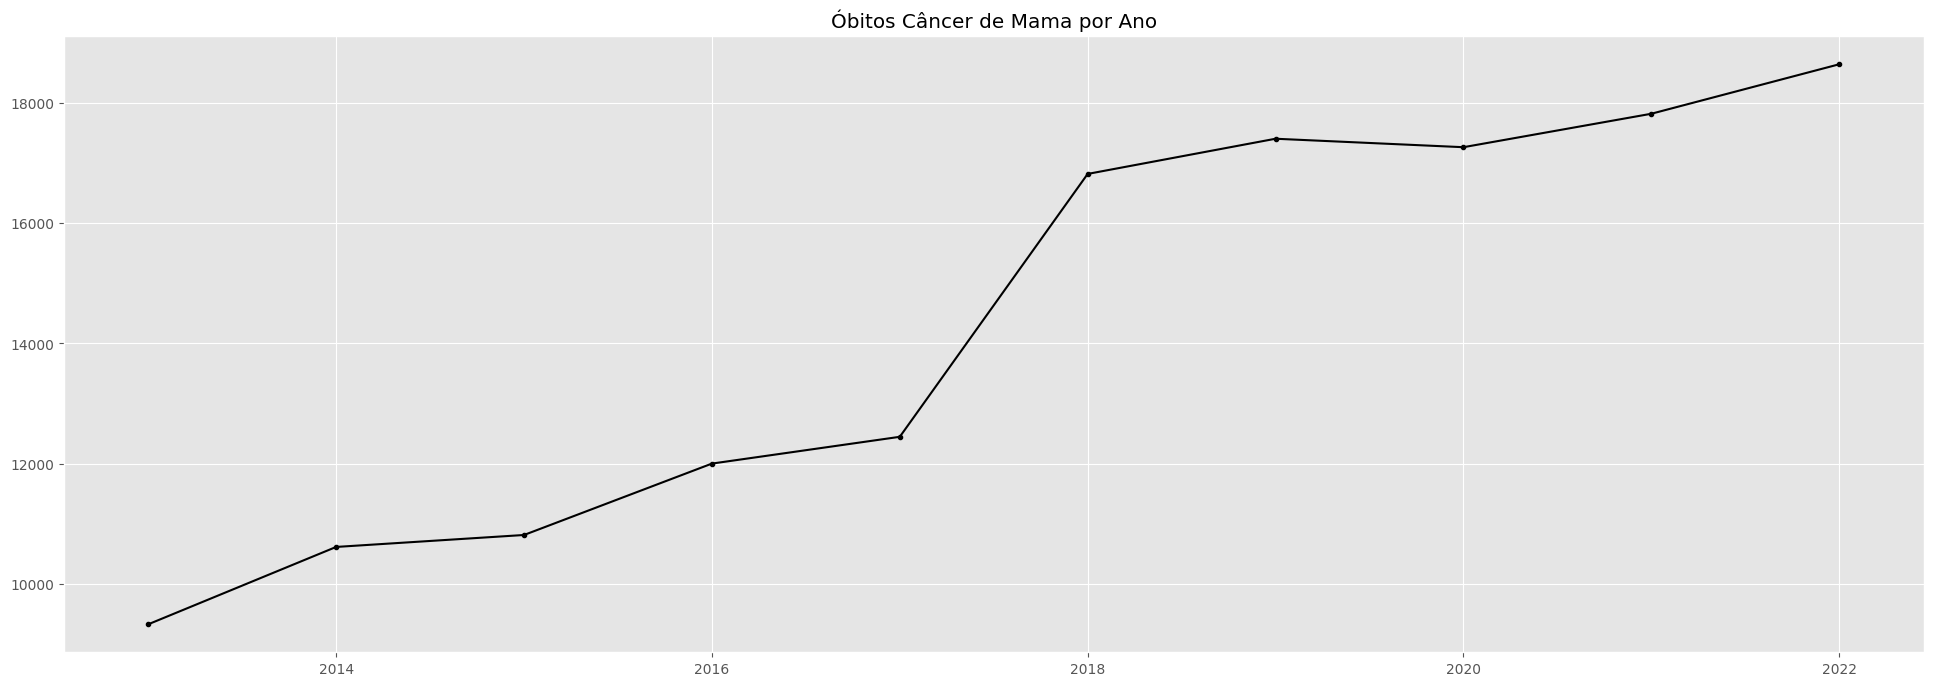

In [ ]:
plt.style.use('ggplot')

# Quantidade de óbitos por ano
df_ano = df_reg_ca_mama_no_dupli.groupBy("ANO").count().orderBy("ANO")
df_ano.show()

# Convertendo para Pandas para plotar
pandas_df_ano = df_ano.toPandas()

# Plotando a quantidade de óbitos por ano
plt.figure(figsize=(24, 8))
plt.plot(pandas_df_ano['ANO'], pandas_df_ano['count'], marker='.', color='black')

plt.title('Óbitos Câncer de Mama por Ano')
plt.xlabel('')
plt.ylabel('')
plt.grid(True)
plt.show()


### 7.1.2 - Óbitos por Mês e Ano

+----+---+-----+
| ANO|MES|count|
+----+---+-----+
|2013|  1|  777|
|2013|  2|  708|
|2013|  3|  856|
|2013|  4|  744|
|2013|  5|  781|
+----+---+-----+
only showing top 5 rows



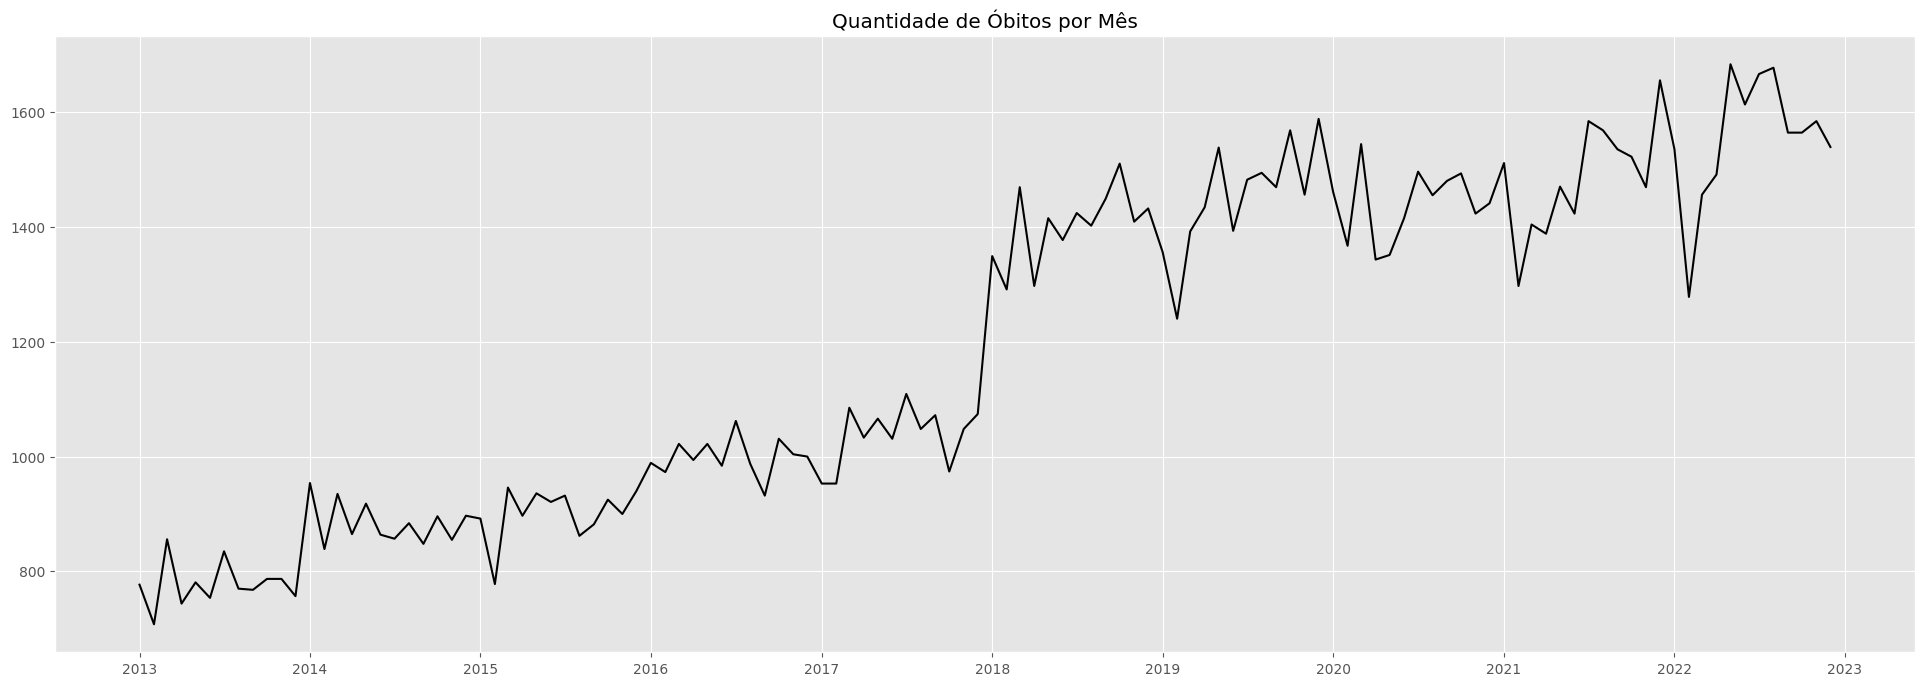

In [ ]:
# Quantidade de óbitos por mês e ano
df_mes_ano = df_reg_ca_mama_no_dupli.groupBy("ANO", "MES").count().orderBy("ANO", "MES")
df_mes_ano.show(5)

# Convertendo para Pandas para plotar
pandas_df_mes_ano = df_mes_ano.toPandas()

# Renomeando colunas para compatibilidade com pd.to_datetime
pandas_df_mes_ano.rename(columns={"ANO": "year", "MES": "month"}, inplace=True)

# Criando uma coluna de data para facilitar a plotagem
pandas_df_mes_ano['data'] = pd.to_datetime(pandas_df_mes_ano[['year', 'month']].assign(day=1))

# Ordenando por data
pandas_df_mes_ano.sort_values(by='data', inplace=True)

# Plotando a quantidade de óbitos por mês em uma linha temporal contínua
plt.figure(figsize=(24, 8))
plt.plot(pandas_df_mes_ano['data'], pandas_df_mes_ano['count'], marker='', color='black')
plt.title('Quantidade de Óbitos por Mês')
plt.xlabel('')
plt.ylabel('')
plt.grid(True)

### 7.1.3 - Média de Óbitos Diários por Mês

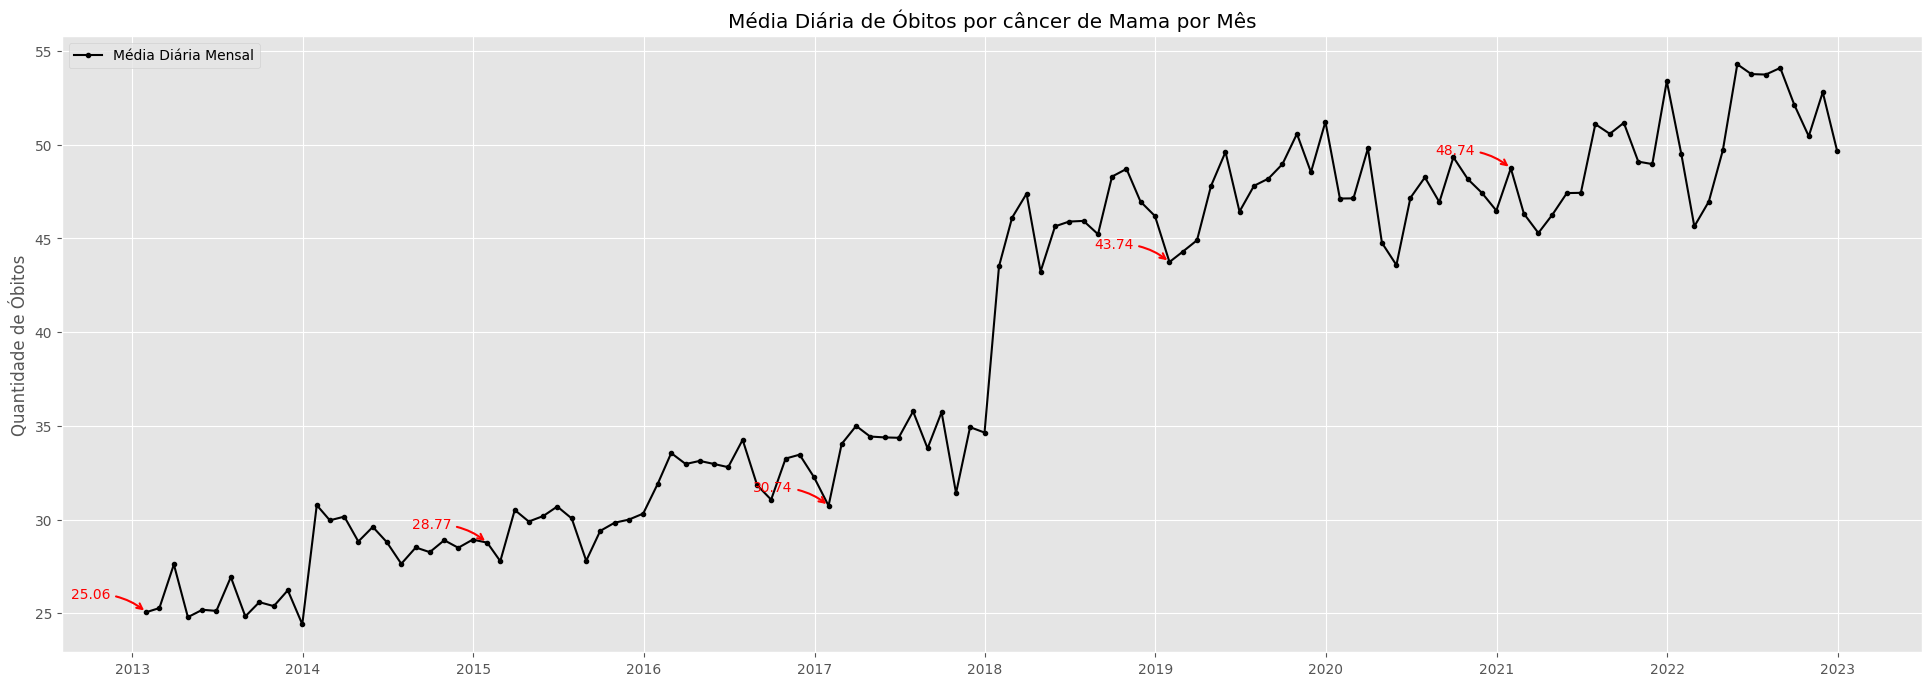

In [ ]:
 # Definindo e calculando a quantidade de óbitos por dia, mês e ano
df_dia_mes_ano = df_reg_ca_mama_no_dupli.groupBy("ANO", "MES", "DIA").count().orderBy("ANO", "MES", "DIA")

# Convertendo para Pandas para plotar
pandas_df_dia_mes_ano = df_dia_mes_ano.toPandas()

# Renomeando colunas para compatibilidade com pd.to_datetime
pandas_df_dia_mes_ano.rename(columns={"ANO": "year", "MES": "month", "DIA": "day"}, inplace=True)

# Criando uma coluna de data para facilitar a plotagem
pandas_df_dia_mes_ano['data'] = pd.to_datetime(pandas_df_dia_mes_ano[['year', 'month', 'day']])
pandas_df_dia_mes_ano.set_index('data', inplace=True)

# Calculando a média diária mensal
pandas_df_mensal = pandas_df_dia_mes_ano.resample('M').mean()

# Plotando a média diária mensal
plt.figure(figsize=(24,8))
plt.plot(pandas_df_mensal.index, pandas_df_mensal['count'], marker='.', label='Média Diária Mensal', color='black')

# Adicionando as médias diárias em intervalos de 2 anos
for i in range(0, len(pandas_df_mensal), 24):  # 24 meses para saltar de 2 em 2 anos
    plt.annotate(f'{pandas_df_mensal["count"].iloc[i]:.2f}',
                 (pandas_df_mensal.index[i], pandas_df_mensal["count"].iloc[i]),
                 textcoords="offset points", xytext=(-40,10), ha='center', fontsize=10, color='red',
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2", color='red', lw=1.5))



plt.title('Média Diária de Óbitos por câncer de Mama por Mês')
plt.xlabel('')
plt.ylabel('Quantidade de Óbitos')
plt.grid(True)
plt.legend(loc='upper left')  # Adicionando a legenda no canto superior esquerdo
plt.show()

### 7.2 - Decomposição Sasonal

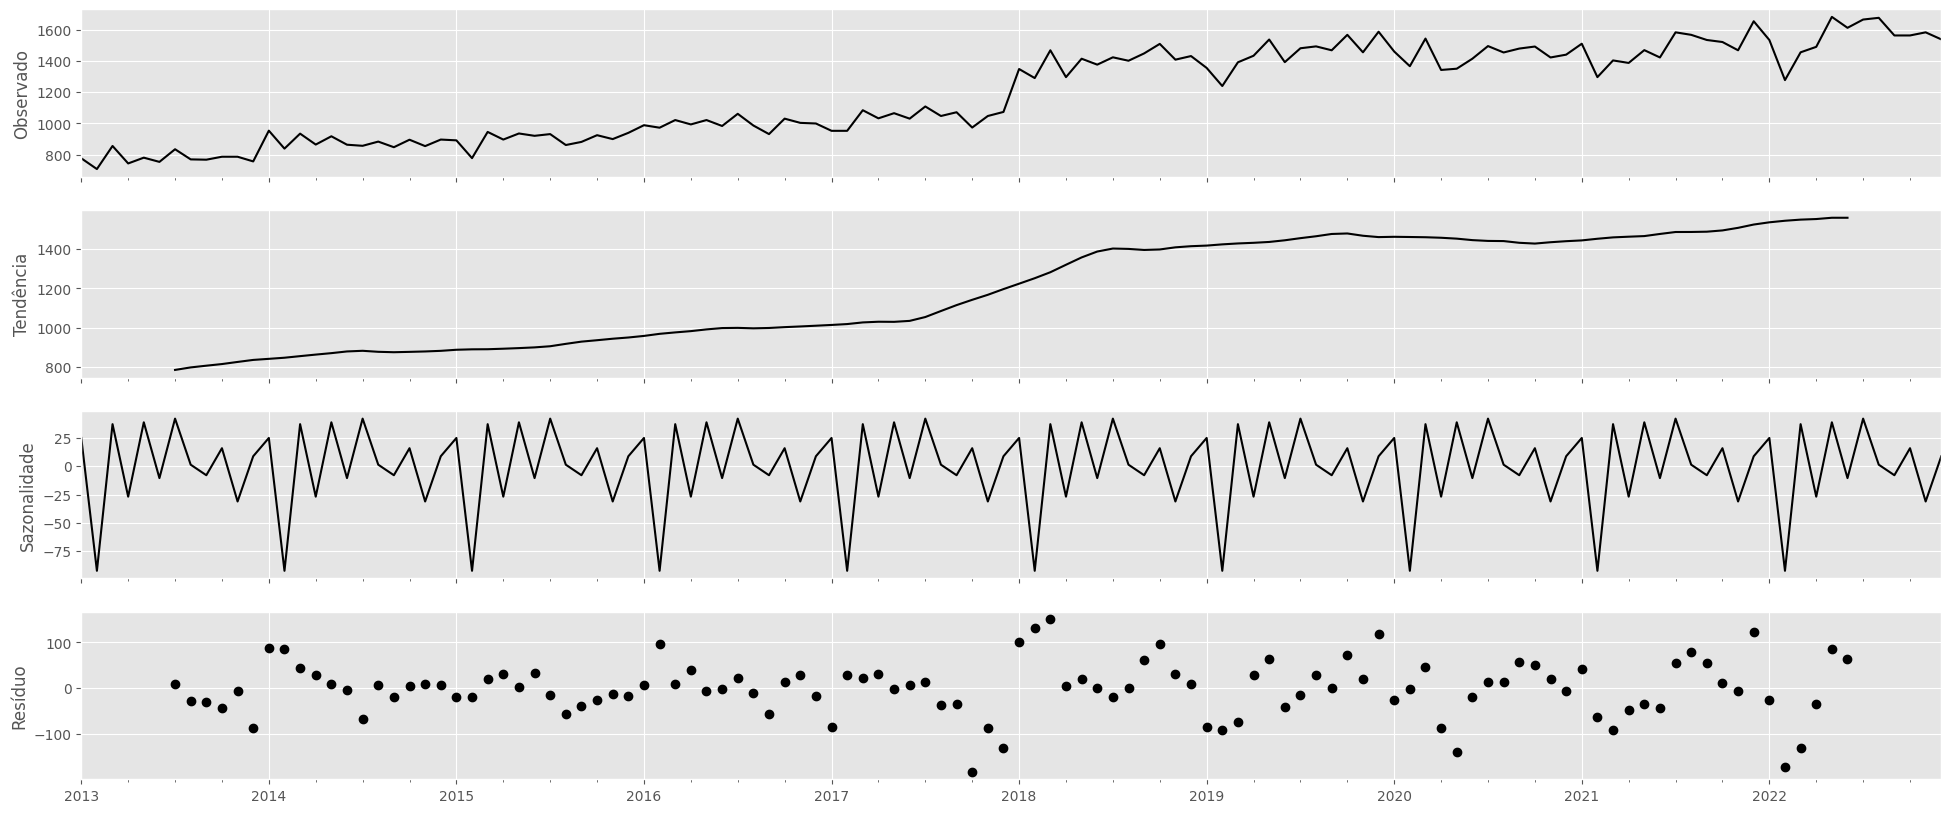

In [ ]:
# Colocando a data como índice
pandas_df_dia_mes_ano['data'] = pd.to_datetime(pandas_df_dia_mes_ano[['year', 'month', 'day']])
pandas_df_dia_mes_ano.set_index('data', inplace=True)

# Agrupar os dados por mês
pandas_df_mensal = pandas_df_dia_mes_ano.resample('M').sum()

# Realizar a decomposição da série temporal
decomposition = seasonal_decompose(pandas_df_mensal['count'], model='additive')

# Plotando a decomposição
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(24, 10), sharex=True)

decomposition.observed.plot(ax=ax1, color='black')
ax1.set_ylabel('Observado')

decomposition.trend.plot(ax=ax2, color='black')
ax2.set_ylabel('Tendência')

decomposition.seasonal.plot(ax=ax3, color='black')
ax3.set_ylabel('Sazonalidade')

decomposition.resid.plot(ax=ax4, color='black', marker='o', linestyle='none')
ax4.set_ylabel('Resíduo')

plt.xlabel('')
plt.show()


### 7.3.1 -  Considerações a respeito da mortalidade do câncer de mama por gênero:
 1. **Qual é a proporção de vítimas de câncer de mama por sexo?**




A consulta SQL abaixo calcula o número de mortes por câncer de mama entre homens e mulheres, ajustando os resultados para cada 100.000 pessoas. Isso permite comparar as taxas de mortalidade entre os gêneros de maneira proporcional, considerando as diferenças no número total de homens e mulheres no Brasil. Esse método ajuda a entender o impacto relativo do câncer de mama em cada gênero.

In [ ]:
df_mort_genero = spark.sql("""
SELECT
  obitos_femininos.total AS total_obit_fem,
  obitos_masculinos.total AS total_obit_masc,
  (obitos_femininos.total / pop_feminina.total_populacao) * 100000 AS prop_casos_f_100k,
  (obitos_masculinos.total / pop_masculina.total_populacao) * 100000 AS prop_casos_m_100k,
  (obitos_femininos.total / (obitos_femininos.total + obitos_masculinos.total)) * 100 AS perc_f,
  (obitos_masculinos.total / (obitos_femininos.total + obitos_masculinos.total)) * 100 AS perc_m
FROM
  (SELECT COUNT(*) AS total FROM df_reg_ca_mama_no_dupli WHERE SEXO = 2) obitos_femininos,
  (SELECT COUNT(*) AS total FROM df_reg_ca_mama_no_dupli WHERE SEXO = 1) obitos_masculinos,
  (SELECT SUM(populacao) AS total_populacao FROM cancer_data.demografia_municipios WHERE valor_sexo = 'Mulheres') pop_feminina,
  (SELECT SUM(populacao) AS total_populacao FROM cancer_data.demografia_municipios WHERE valor_sexo = 'Homens') pop_masculina
""")
df_mort_genero.show()

+--------------+---------------+-----------------+------------------+----------------+------------------+
|total_obit_fem|total_obit_masc|prop_casos_f_100k| prop_casos_m_100k|          perc_f|            perc_m|
+--------------+---------------+-----------------+------------------+----------------+------------------+
|        141443|           1718|60.36695484305262|0.7555779984993025|98.7999525010303|1.2000474989696914|
+--------------+---------------+-----------------+------------------+----------------+------------------+



### 7.3.2 - Proporção dos casos por Gênero
2. **Existem casos de câncer de mama em indivíduos do sexo masculino no dataset, e qual sua proporção em relação às mulheres?**



Conforme observado acima, a distribuição dos casos de câncer de mama mostra uma predominância significativa no sexo feminino, com 156.134 casos, em contraste com 1.873 casos registrados em homens. Isso significa que os homens representam apenas 1,2% do total de casos. Dada esta grande diferença, análises subsequentes se concentrarão predominantemente no grupo feminino, buscando entender as variações dentro deste grupo.

In [ ]:
pandas_df_mort_genero = df_mort_genero.toPandas()

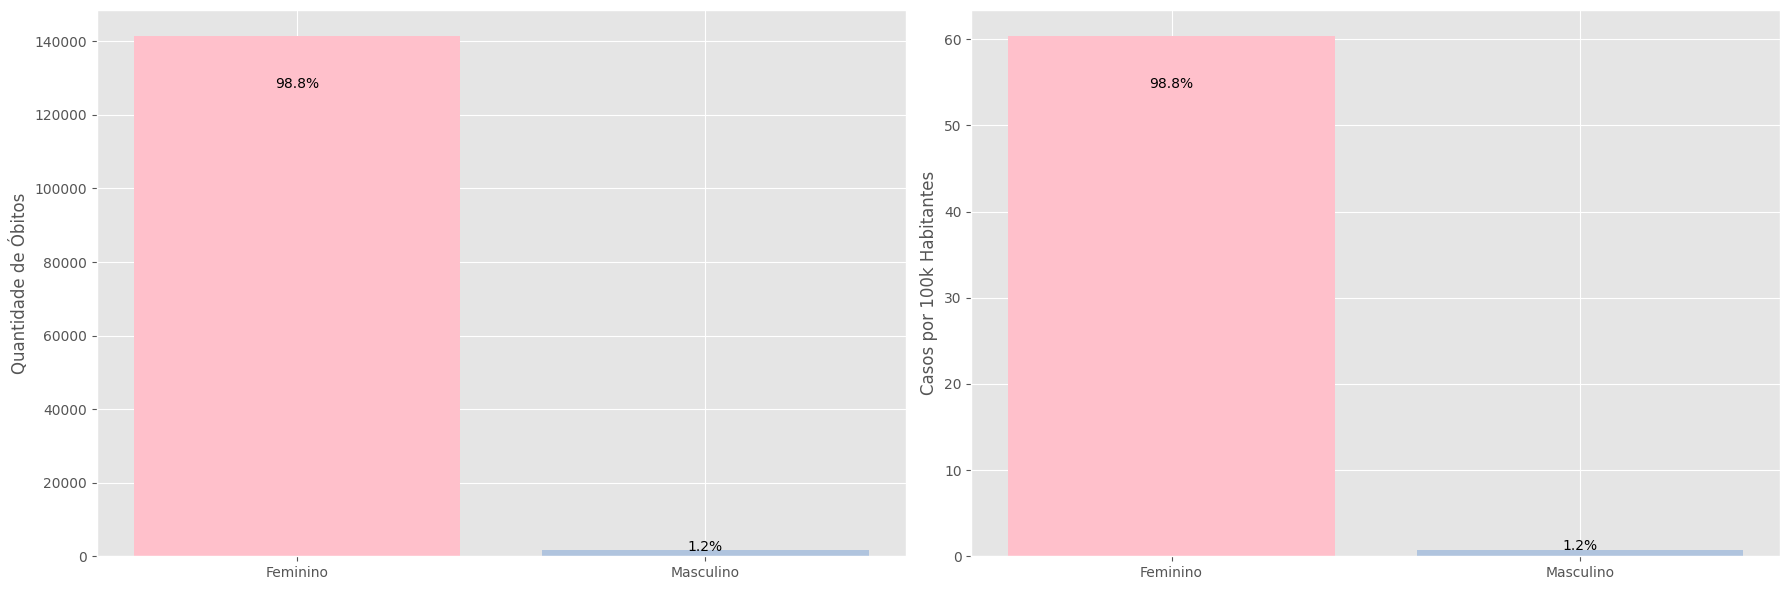

In [ ]:
# Plotar os gráficos de barras em uma única figura
plt.figure(figsize=(18, 6))

# Gráfico de barras para a quantidade total de óbitos
plt.subplot(1, 2, 1)
total_obitos = pandas_df_mort_genero[['total_obit_fem', 'total_obit_masc']].values[0]
bars1 = plt.bar(['Feminino', 'Masculino'], total_obitos, color=['pink', 'lightsteelblue'])

plt.ylabel('Quantidade de Óbitos')

# Adicionar as porcentagens dentro das barras
for bar, perc in zip(bars1, pandas_df_mort_genero[['perc_f', 'perc_m']].values[0]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - bar.get_height() * 0.1, f'{perc:.1f}%', ha='center', color='black')

# Gráfico de barras para a proporção de casos por 100k habitantes
plt.subplot(1, 2, 2)
prop_casos = pandas_df_mort_genero[['prop_casos_f_100k', 'prop_casos_m_100k']].values[0]
bars2 = plt.bar(['Feminino', 'Masculino'], prop_casos, color=['pink', 'lightsteelblue'])

plt.ylabel('Casos por 100k Habitantes')

# Adicionar as porcentagens dentro das barras
for bar, perc in zip(bars2, pandas_df_mort_genero[['perc_f', 'perc_m']].values[0]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - bar.get_height() * 0.1, f'{perc:.1f}%', ha='center', color='black')

plt.tight_layout()
plt.show()

### 7.4 - Distribuição Geográfica dos Óbitos Femininos por câncer de mama como causa primária






Preparação:

In [ ]:
def process_data(df_main: DataFrame, df_demo: DataFrame) -> DataFrame:
    # Passo 1: Filtrar apenas registros femininos (SEXO == 2) no DataFrame principal
    df_feminino = df_main.filter(F.col("SEXO") == 2)

    # Passo 2: Distribuição geográfica dos óbitos (município)
    df_municipio_tempo = df_feminino.groupBy("CODMUNOCOR").count()

    # Passo 3: Filtrar apenas registros femininos na tabela demográfica
    df_demo_fem = df_demo.filter(F.col("valor_sexo") == "Mulheres")

    # Passo 4: Remover o último dígito da coluna codigo_local e agregar dados demográficos
    df_demo_agg = df_demo_fem.withColumn("codigo_local_trimmed", F.expr("substring(codigo_local, 1, length(codigo_local) - 1)"))\
        .groupBy("codigo_local_trimmed")\
        .agg(F.first("populacao").alias("populacao"), F.first("nome_local").alias("nome_local"), F.first("valor_sexo").alias("valor_sexo"))

    # Passo 5: Realizar a junção pelas colunas que contêm os códigos dos municípios
    df_joined = df_municipio_tempo.join(df_demo_agg, df_municipio_tempo["CODMUNOCOR"] == df_demo_agg["codigo_local_trimmed"], "left")

    # Passo 6: Separar as colunas 'municipio' e 'uf' a partir de 'nome_local'
    df_joined = df_joined.withColumn('municipio', F.split(F.col('nome_local'), ' - ')[0]) \
                         .withColumn('uf', F.split(F.col('nome_local'), ' - ')[1])

    # Passo 7: Selecionar as colunas desejadas e ordenar
    df_result = df_joined.select( "CODMUNOCOR", "count", "populacao", "municipio", "uf").orderBy(F.desc("count"))

    # Exibir a quantidade de linhas no DataFrame df_result
    qtd_linhas_df_result = df_result.count()
    print(f"Quantidade de linhas no DataFrame: {qtd_linhas_df_result}")

    # Passo 8: Adicionar a coluna de macro-região
    macro_regioes = {
        "Norte": ["AC", "AP", "AM", "PA", "RO", "RR", "TO"],
        "Nordeste": ["AL", "BA", "CE", "MA", "PB", "PE", "PI", "RN", "SE"],
        "Centro-Oeste": ["GO", "MT", "MS", "DF"],
        "Sudeste": ["ES", "MG", "RJ", "SP"],
        "Sul": ["PR", "RS", "SC"]
    }
    df_macro_regioes = spark.createDataFrame(
        [(uf, regiao) for regiao, ufs in macro_regioes.items() for uf in ufs],
        ["uf", "macro_regiao"]
    )

    df_result_with_macro = df_result.join(df_macro_regioes, on="uf", how="left")

    # Resultado final
    df_result_with_macro.show(3)

    return df_result_with_macro

# Exemplo de uso:
# df_main e df_demo já devem estar definidos anteriormente no código
# Contar o número de cidades únicas com base na coluna CODMUNOCOR

df_result_1 = process_data(df_reg_ca_mama_no_dupli, df_prim_viz_demo)

Quantidade de linhas no DataFrame: 4016
+---+----------+-----+---------+------------+------------+
| uf|CODMUNOCOR|count|populacao|   municipio|macro_regiao|
+---+----------+-----+---------+------------+------------+
| RS|    431490| 3052|   755564|Porto Alegre|         Sul|
| MA|    211130|  879|   539842|    São Luís|    Nordeste|
| CE|    230310|    7|     9205|      Cariré|    Nordeste|
+---+----------+-----+---------+------------+------------+
only showing top 3 rows



### 7.4.1 - Região

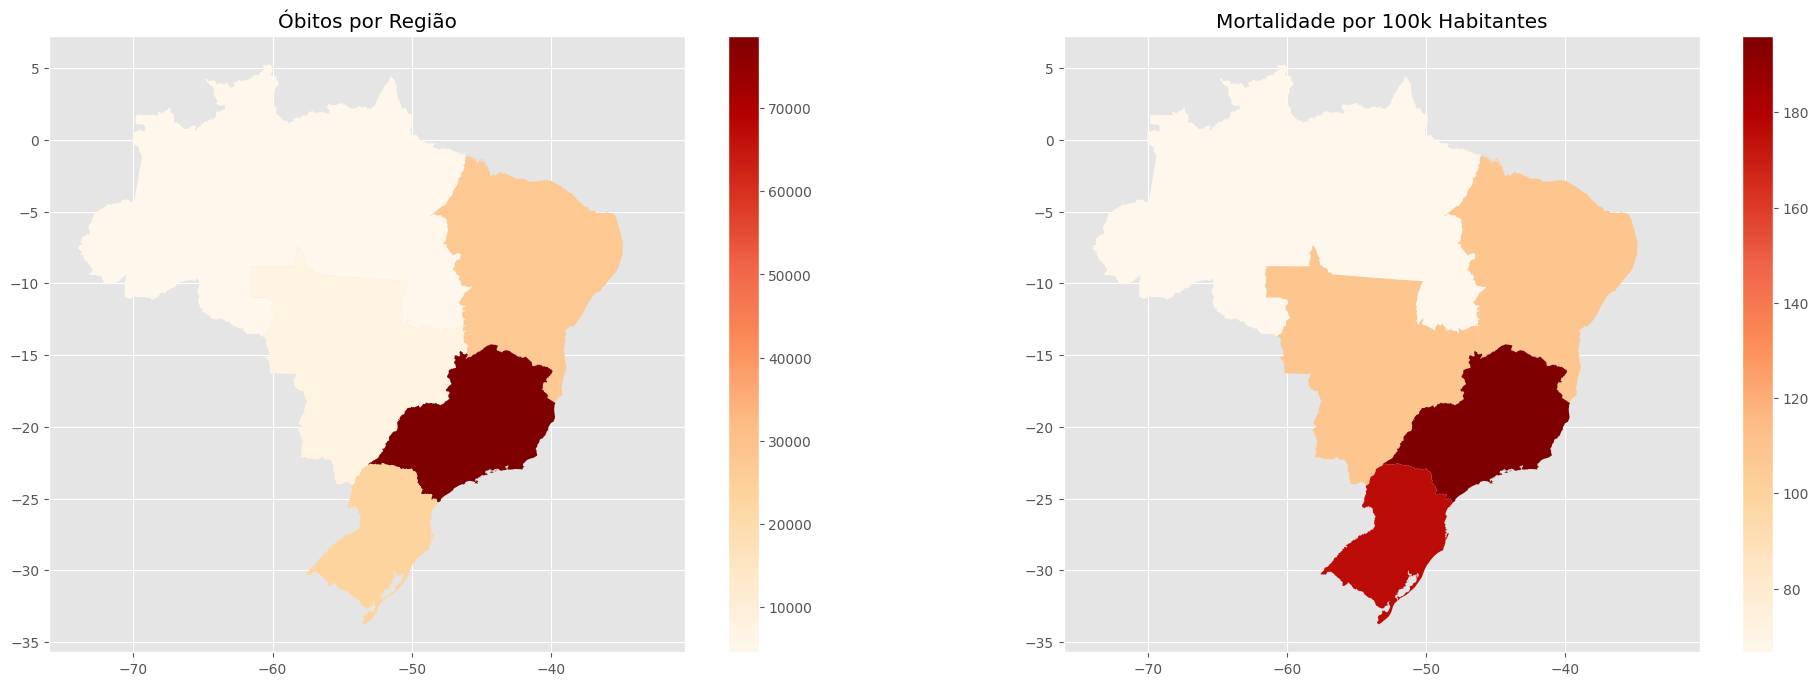

In [ ]:
# Corrigir a agregação da população para não somar valores duplicados
df_populacao_unica = df_result_1.select("CODMUNOCOR", "populacao").distinct()

# Agrupar os dados por macro-região e calcular a quantidade total de mortes
df_mortes_macro = df_result_1.groupBy("macro_regiao").agg(
    F.sum("count").alias("total_mortes")
)

# Agregar a população por macro-região
df_populacao_macro = df_populacao_unica.join(df_result_1.select("CODMUNOCOR", "macro_regiao").distinct(), on="CODMUNOCOR", how="left")
df_populacao_macro_agg = df_populacao_macro.groupBy("macro_regiao").agg(
    F.sum("populacao").alias("total_populacao")
)

# Unir as duas agregações
df_mortes_macro = df_mortes_macro.join(df_populacao_macro_agg, on="macro_regiao", how="left").withColumn(
    "mortes_por_100k", (F.col("total_mortes") / F.col("total_populacao")) * 100000
)

# Converter para Pandas para plotar
pandas_df_mortes_macro = df_mortes_macro.toPandas()

# Carregar shapes dos estados do Brasil
brasil = gpd.read_file("https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson")

# Definir as macro-regiões do Brasil manualmente (isso pode variar dependendo da definição exata)
macro_regioes = {
    'Norte': ['AC', 'AP', 'AM', 'PA', 'RO', 'RR', 'TO'],
    'Nordeste': ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'],
    'Centro-Oeste': ['DF', 'GO', 'MT', 'MS'],
    'Sudeste': ['ES', 'MG', 'RJ', 'SP'],
    'Sul': ['PR', 'RS', 'SC']
}

# Função para mapear estados para macro-regiões
def map_macro_regiao(uf):
    for regiao, estados in macro_regioes.items():
        if uf in estados:
            return regiao
    return None

# Adicionar a coluna de macro-região ao dataframe
brasil['macro_regiao'] = brasil['sigla'].apply(map_macro_regiao)

# Agrupar por macro-região
df_macro_agg = pandas_df_mortes_macro.groupby('macro_regiao').agg({
    'total_mortes': 'sum',
    'total_populacao': 'sum'
}).reset_index()

# Calcular mortes por 100k habitantes
df_macro_agg['mortes_por_100k'] = (df_macro_agg['total_mortes'] / df_macro_agg['total_populacao']) * 100000

# Criar um GeoDataFrame para as macro-regiões
gdf_macro = brasil.dissolve(by='macro_regiao')
gdf_macro = gdf_macro.merge(df_macro_agg, left_on='macro_regiao', right_on='macro_regiao')

# Plotar os mapas
fig, ax = plt.subplots(1, 2, figsize=(24, 8))

gdf_macro.plot(column='total_mortes', ax=ax[0], legend=True, cmap='OrRd')

ax[0].set_title(f'Óbitos por Região')

gdf_macro.plot(column='mortes_por_100k', ax=ax[1], legend=True, cmap='OrRd')
ax[1].set_title(f'Mortalidade por 100k Habitantes')

plt.show()

### 7.4.2 - Por Estados

<ipython-input-43-a9e13d15d218>:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(pandas_df_estado_agg['uf'], rotation=45)


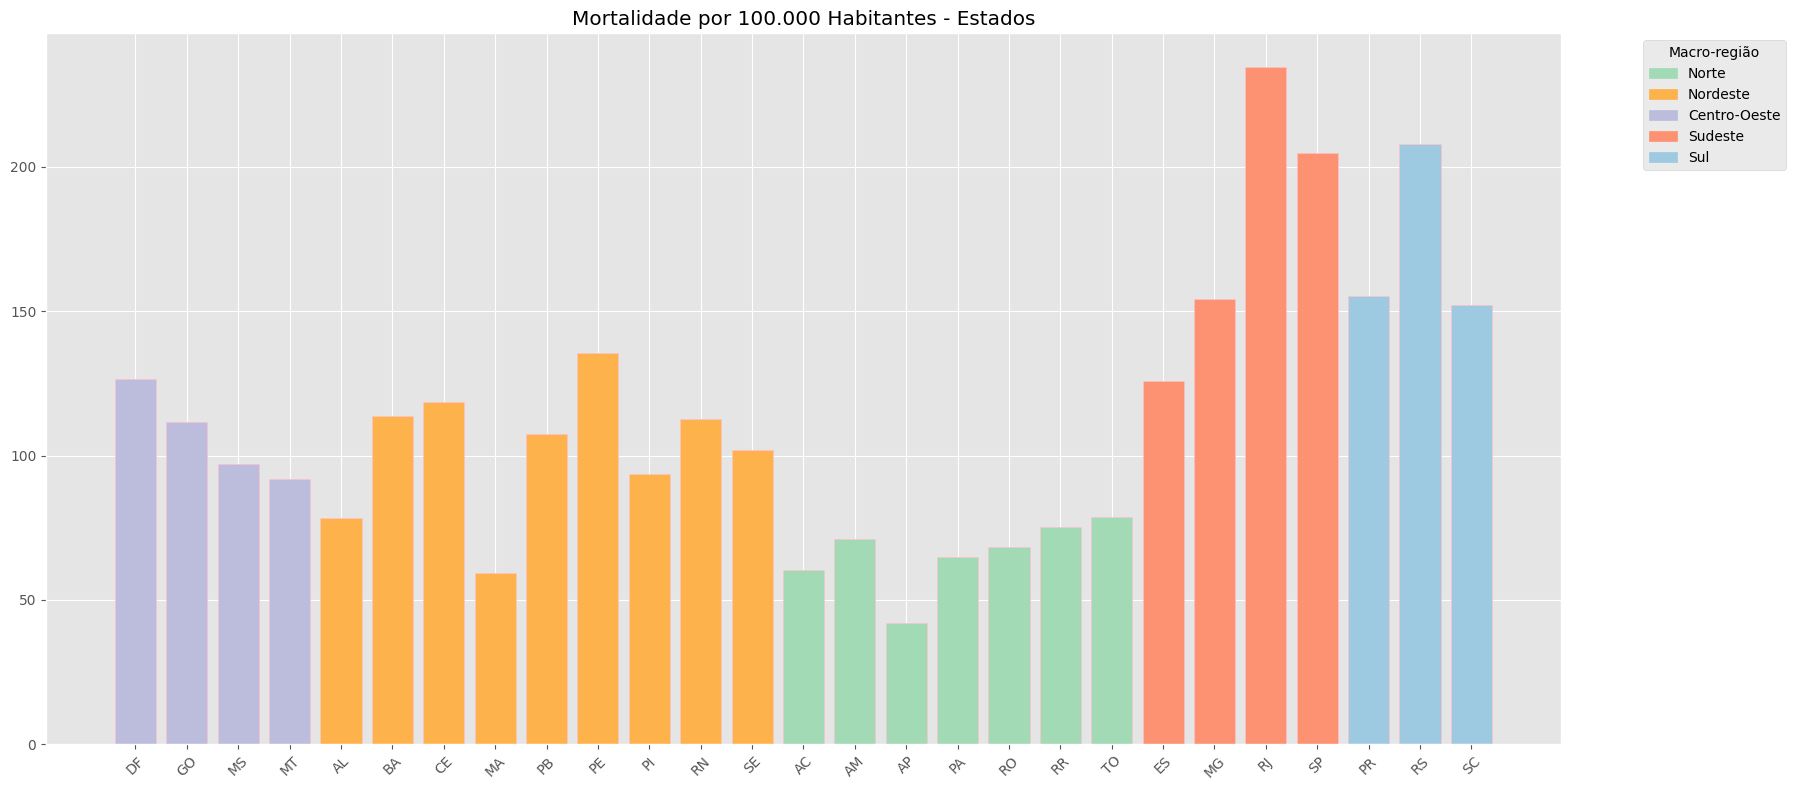

<ipython-input-43-a9e13d15d218>:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(pandas_df_estado_agg['uf'], rotation=45)


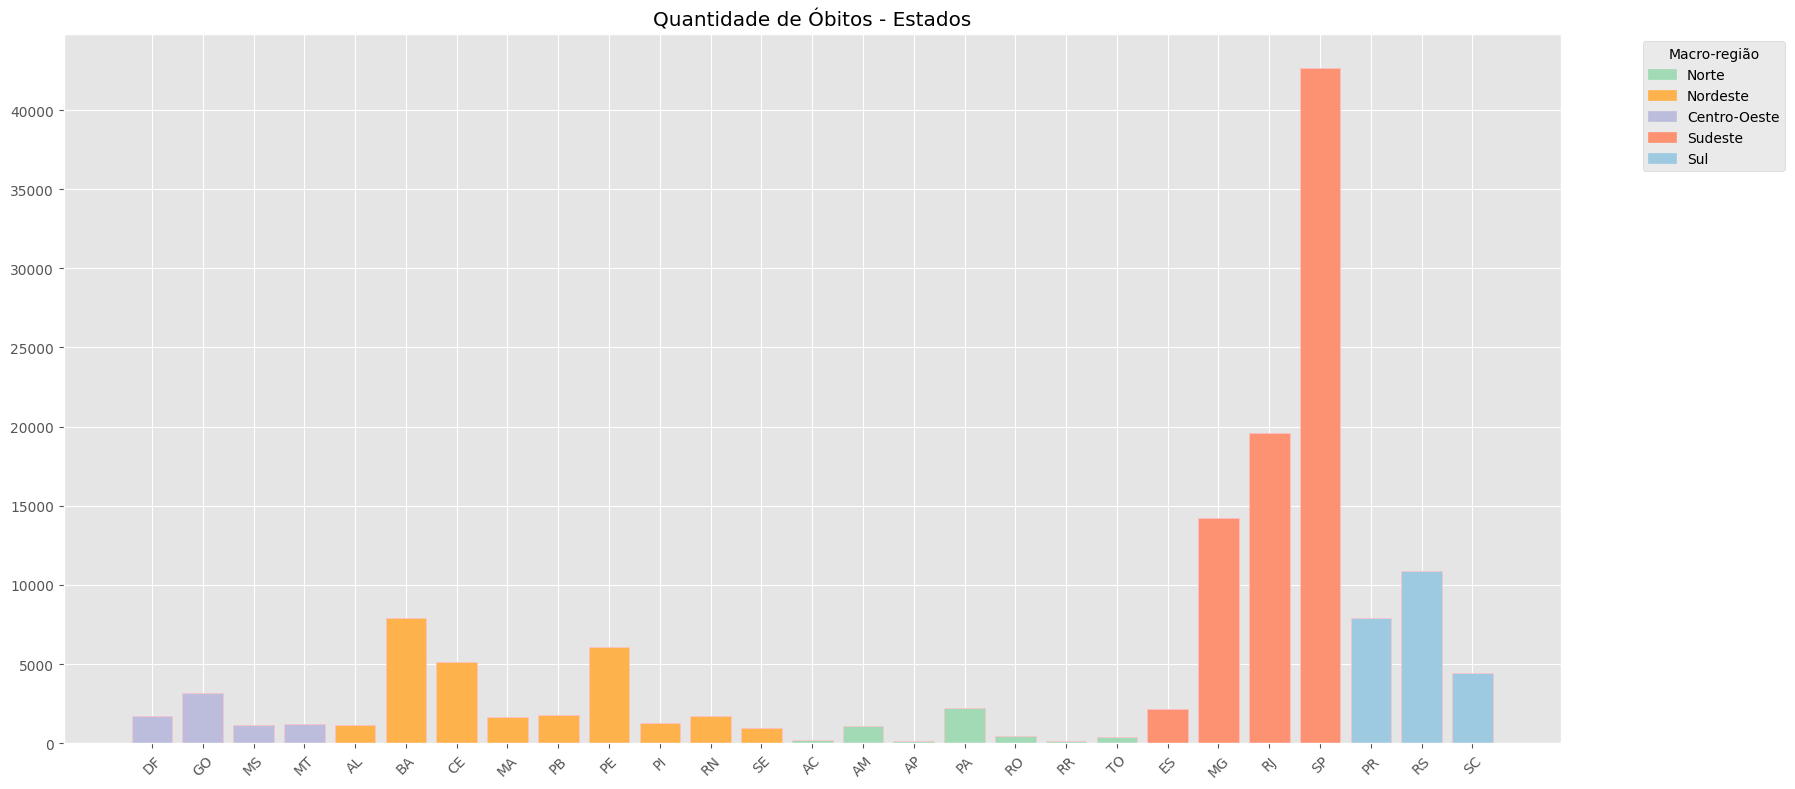

In [ ]:
# Definir as macro-regiões do Brasil
macro_regioes = {
    'Norte': ['AC', 'AP', 'AM', 'PA', 'RO', 'RR', 'TO'],
    'Nordeste': ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'],
    'Centro-Oeste': ['DF', 'GO', 'MT', 'MS'],
    'Sudeste': ['ES', 'MG', 'RJ', 'SP'],
    'Sul': ['PR', 'RS', 'SC']
}

# Definir cores para cada macro-região em tons pastéis
cores_macro_regiao = {
    'Norte': '#a1dab4',
    'Nordeste': '#feb24c',
    'Centro-Oeste': '#bcbddc',
    'Sudeste': '#fc9272',
    'Sul': '#9ecae1'
}

# Função para mapear estados para macro-regiões
def map_macro_regiao(uf):
    for regiao, estados in macro_regioes.items():
        if uf in estados:
            return regiao
    return 'Desconhecida'

# Converter para Pandas para plotar
pandas_df_result_1 = df_result_1.toPandas()

# Corrigir a agregação da população para não somar valores duplicados
df_populacao_unica = df_result_1.select("CODMUNOCOR", "populacao").distinct()

# Agregar a população por estado
df_populacao_estado = df_populacao_unica.join(df_result_1.select("CODMUNOCOR", "uf").distinct(), on="CODMUNOCOR", how="left")
df_populacao_estado_agg = df_populacao_estado.groupBy("uf").agg(
    F.sum("populacao").alias("total_populacao")
)

# Agregar as mortes por estado
df_mortes_estado = df_result_1.groupBy("uf").agg(
    F.sum("count").alias("total_mortes")
)

# Unir as duas agregações
df_estado_agg = df_mortes_estado.join(df_populacao_estado_agg, on="uf", how="left").withColumn(
    "mortes_por_100k", (F.col("total_mortes") / F.col("total_populacao")) * 100000
)

# Converter para Pandas para plotar
pandas_df_estado_agg = df_estado_agg.toPandas()

# Adicionar a coluna de macro-região
pandas_df_estado_agg['macro_regiao'] = pandas_df_estado_agg['uf'].apply(map_macro_regiao)

# Remover linhas onde 'uf' é None ou 'Desconhecida'
pandas_df_estado_agg = pandas_df_estado_agg.dropna(subset=['uf'])
pandas_df_estado_agg = pandas_df_estado_agg[pandas_df_estado_agg['macro_regiao'] != 'Desconhecida']

# Ordenar os estados por macro-região para agrupamento no gráfico
pandas_df_estado_agg = pandas_df_estado_agg.sort_values(by=['macro_regiao', 'uf'])

# Adicionar cores baseadas na macro-região
pandas_df_estado_agg['color'] = pandas_df_estado_agg['macro_regiao'].apply(lambda x: cores_macro_regiao.get(x, '#d9d9d9'))

# Plotar os resultados de mortalidade por 100.000 habitantes
fig, ax = plt.subplots(figsize=(18, 8))

bars = ax.bar(pandas_df_estado_agg['uf'], pandas_df_estado_agg['mortes_por_100k'], color=pandas_df_estado_agg['color'], edgecolor='pink')
ax.set_title('Mortalidade por 100.000 Habitantes - Estados')
ax.set_xticklabels(pandas_df_estado_agg['uf'], rotation=45)

# Adicionar legenda
from matplotlib.patches import Patch
legend_handles = [Patch(color=color, label=regiao) for regiao, color in cores_macro_regiao.items()]
ax.legend(handles=legend_handles, title="Macro-região", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Plotar os resultados de quantidade de óbitos reais
fig, ax = plt.subplots(figsize=(18, 8))

bars = ax.bar(pandas_df_estado_agg['uf'], pandas_df_estado_agg['total_mortes'], color=pandas_df_estado_agg['color'], edgecolor='pink')
ax.set_title('Quantidade de Óbitos - Estados')
ax.set_xticklabels(pandas_df_estado_agg['uf'], rotation=45)

# Adicionar legenda
ax.legend(handles=legend_handles, title="Macro-região", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


### 7.4.3 - Por Capitais

<ipython-input-44-3b9472fe166c>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(pandas_df_capitais_agg['municipio'], rotation=45)


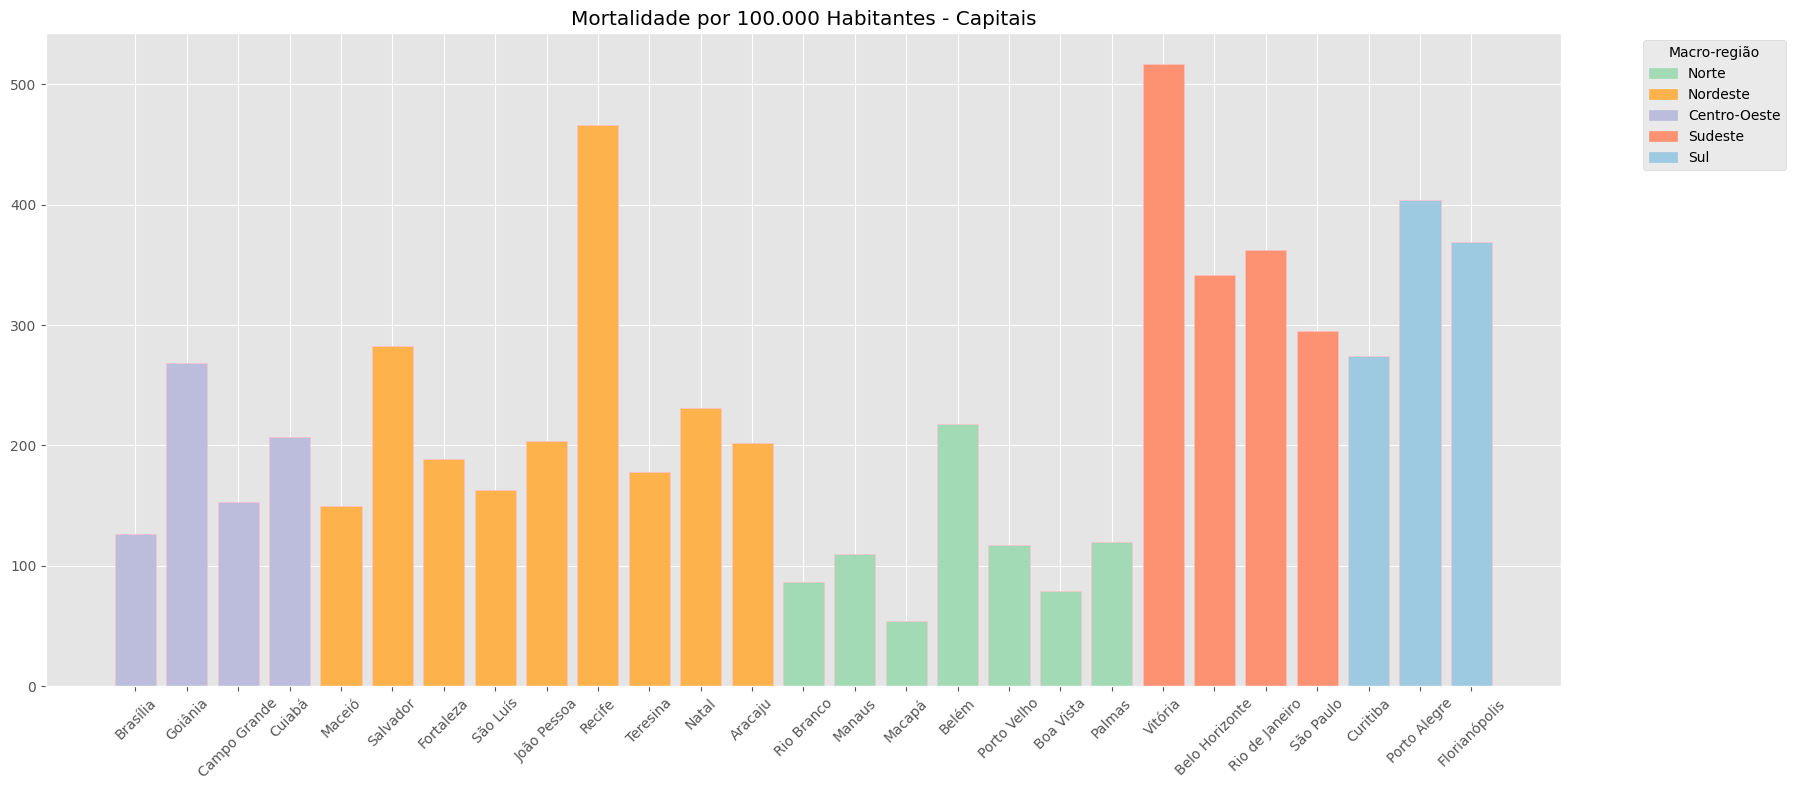

<ipython-input-44-3b9472fe166c>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(pandas_df_capitais_agg['municipio'], rotation=45)


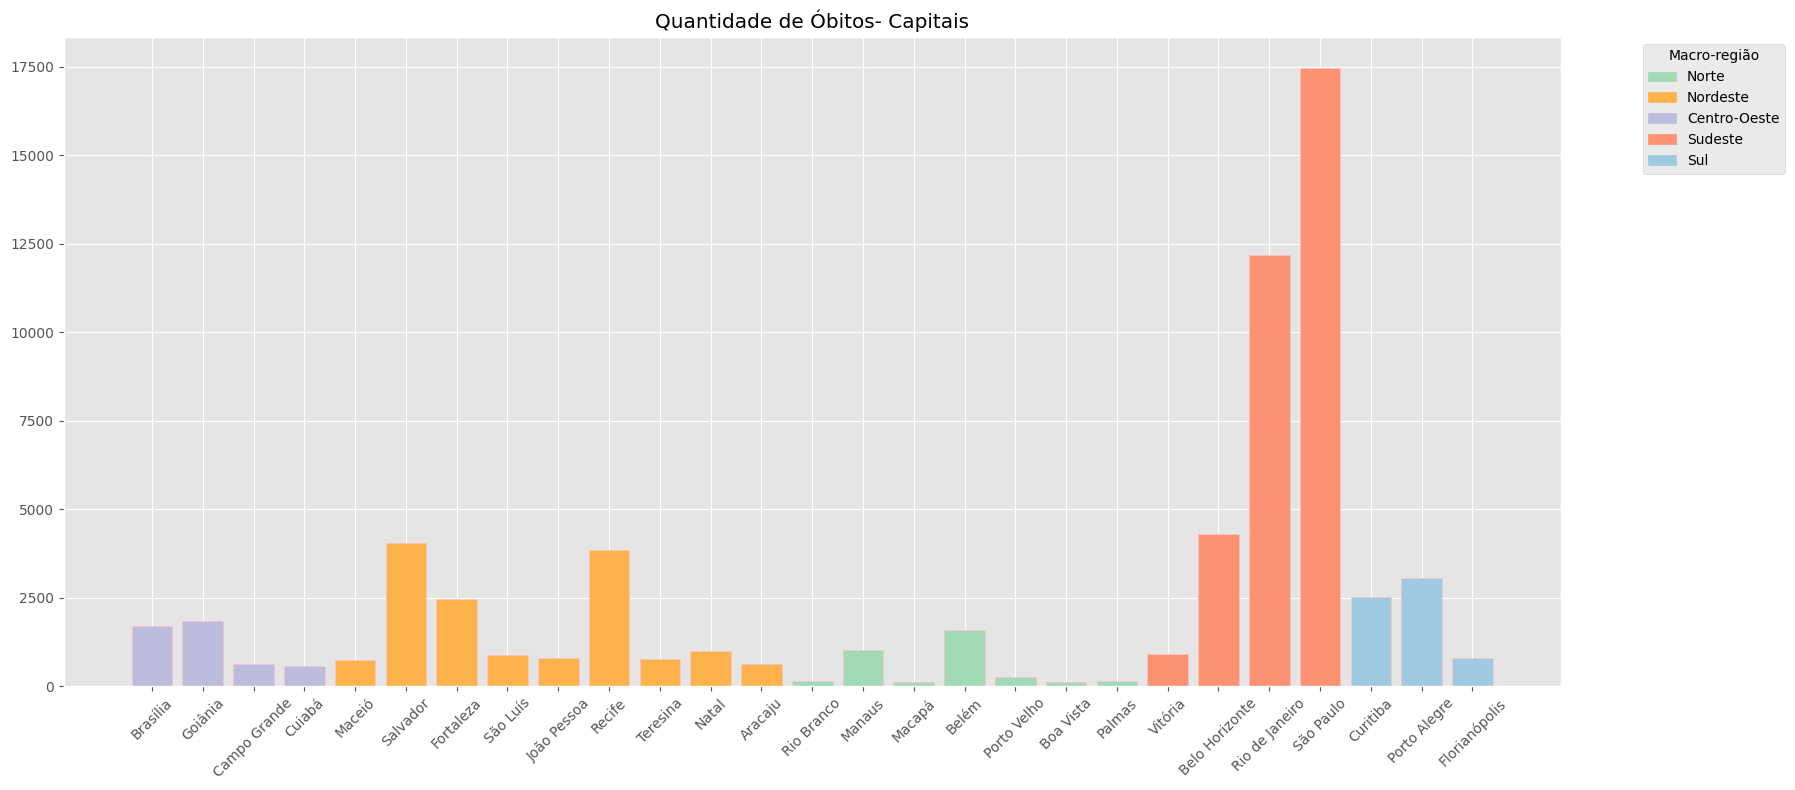

In [ ]:
# Definir as capitais do Brasil
capitais = {
    'AC': 'Rio Branco', 'AL': 'Maceió', 'AP': 'Macapá', 'AM': 'Manaus', 'BA': 'Salvador', 'CE': 'Fortaleza',
    'DF': 'Brasília', 'ES': 'Vitória', 'GO': 'Goiânia', 'MA': 'São Luís', 'MT': 'Cuiabá', 'MS': 'Campo Grande',
    'MG': 'Belo Horizonte', 'PA': 'Belém', 'PB': 'João Pessoa', 'PR': 'Curitiba', 'PE': 'Recife', 'PI': 'Teresina',
    'RJ': 'Rio de Janeiro', 'RN': 'Natal', 'RS': 'Porto Alegre', 'RO': 'Porto Velho', 'RR': 'Boa Vista', 'SC': 'Florianópolis',
    'SP': 'São Paulo', 'SE': 'Aracaju', 'TO': 'Palmas'
}

# Converter a lista de capitais para um DataFrame do Spark
capitais_df = spark.createDataFrame(pd.DataFrame(capitais.items(), columns=['uf', 'municipio']))

# Filtrar dados para incluir apenas as capitais usando um join
df_capitais = df_result_1.join(capitais_df, on=['uf', 'municipio'], how='inner')

# Agregar a população e mortes por capital
df_capitais_agg = df_capitais.groupBy("uf", "municipio", "macro_regiao").agg(
    F.sum("populacao").alias("total_populacao"),
    F.sum("count").alias("total_mortes")
).withColumn(
    "mortes_por_100k", (F.col("total_mortes") / F.col("total_populacao")) * 100000
)

# Converter para Pandas para plotar
pandas_df_capitais_agg = df_capitais_agg.toPandas()

# Ordenar as capitais por macro-região para agrupamento no gráfico
pandas_df_capitais_agg = pandas_df_capitais_agg.sort_values(by=['macro_regiao', 'uf'])

# Adicionar cores baseadas na macro-região
pandas_df_capitais_agg['color'] = pandas_df_capitais_agg['macro_regiao'].apply(lambda x: cores_macro_regiao.get(x, '#d9d9d9'))

# Plotar os resultados de mortalidade por 100.000 habitantes para as capitais
fig, ax = plt.subplots(figsize=(18, 8))

bars = ax.bar(pandas_df_capitais_agg['municipio'], pandas_df_capitais_agg['mortes_por_100k'], color=pandas_df_capitais_agg['color'], edgecolor='pink')
ax.set_title('Mortalidade por 100.000 Habitantes - Capitais')
ax.set_xticklabels(pandas_df_capitais_agg['municipio'], rotation=45)

# Adicionar legenda
from matplotlib.patches import Patch
legend_handles = [Patch(color=color, label=regiao) for regiao, color in cores_macro_regiao.items()]
ax.legend(handles=legend_handles, title="Macro-região", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Plotar os resultados de quantidade de óbitos reais para as capitais
fig, ax = plt.subplots(figsize=(18, 8))

bars = ax.bar(pandas_df_capitais_agg['municipio'], pandas_df_capitais_agg['total_mortes'], color=pandas_df_capitais_agg['color'], edgecolor='pink')
ax.set_title('Quantidade de Óbitos- Capitais')
ax.set_xticklabels(pandas_df_capitais_agg['municipio'], rotation=45)

# Adicionar legenda
ax.legend(handles=legend_handles, title="Macro-região", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


### 7.5 - Quais municipios tiveram a maior quantidade de óbitos por câncer de mama por 100.000 Habitantes?




#### Separando as cidades em grupos de acordo com a sua populacao e limpando outliers para cada grupo:

Menor que 20.000 habitantes: Pequenas

De 50.000 a 100.000 habitantes: Médias

De 100.000 a 500.000 habitantes: Grandes

Maiores que 500.000 habitantes: Muito Grandes





<ipython-input-45-753d2ab32655>:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0], x='population_category', y='total_count', data=cleaned_data[cleaned_data['population_category'].isin(categories_first_graph)], palette="Set2", showfliers=False)
<ipython-input-45-753d2ab32655>:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1], x='population_category', y='total_count', data=cleaned_data[cleaned_data['population_category'].isin(categories_second_graph)], palette="Set2", showfliers=False)


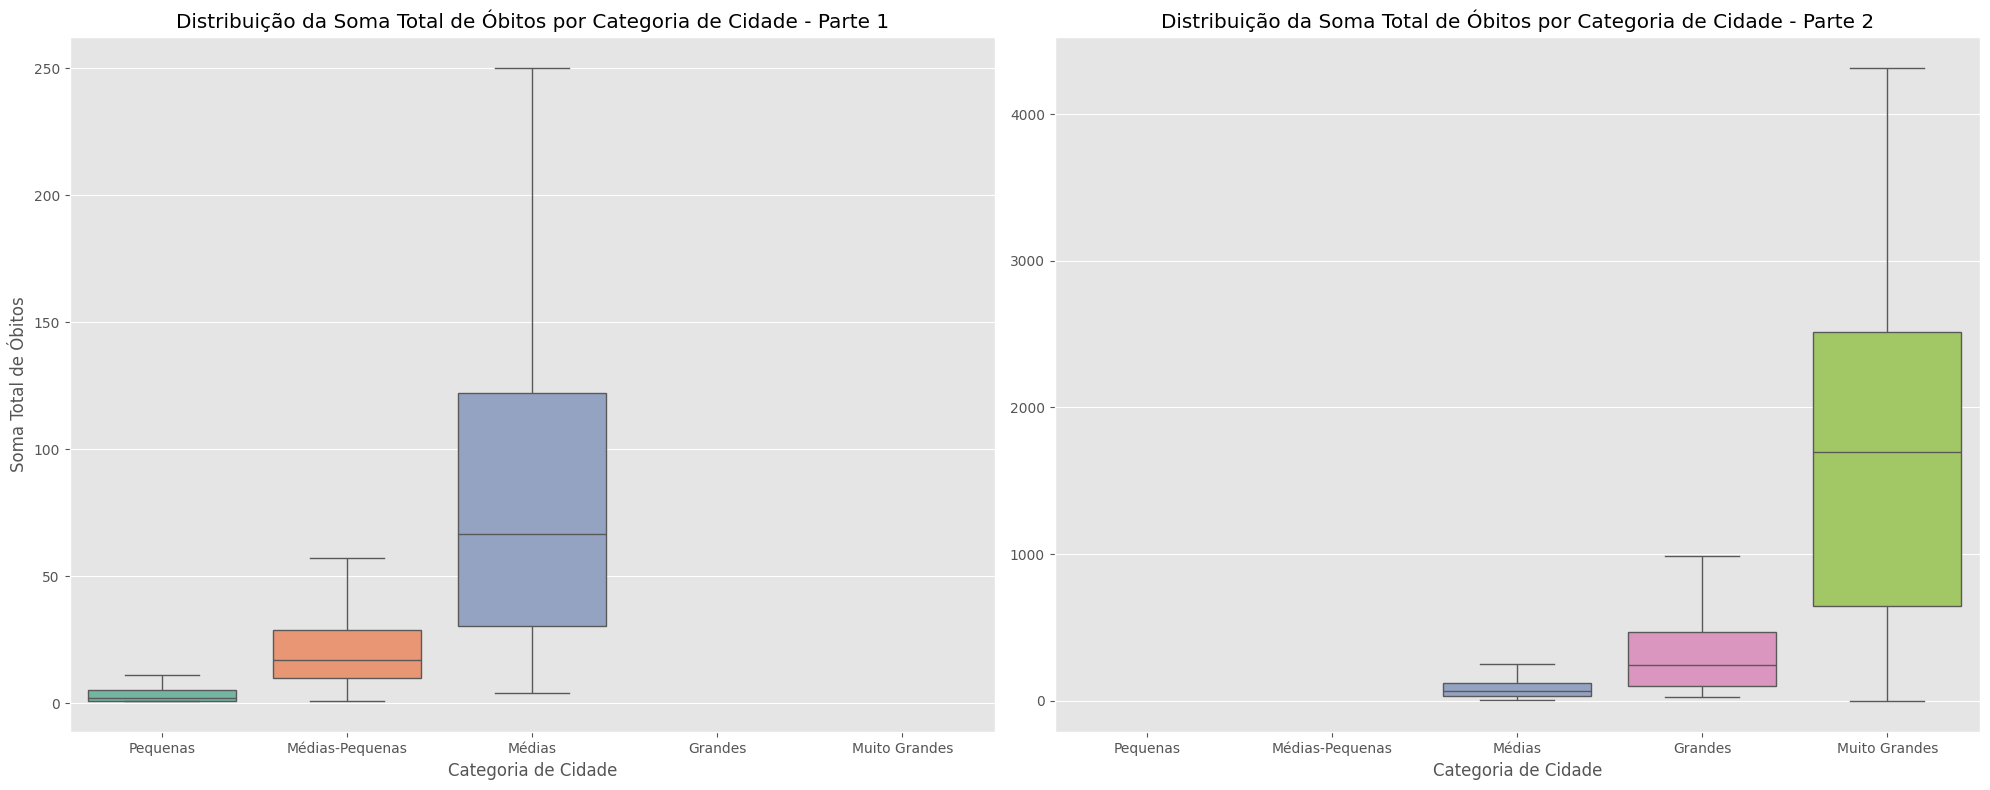

Antes da Remoção dos Outliers:
  Categoria de População  Unique Cities (Antes)  Soma de Óbitos (Antes)
0               Pequenas                   3257                   14489
1        Médias-Pequenas                    471                   12739
2                 Médias                    149                   14950
3                Grandes                    120                   39490
4          Muito Grandes                     19                   59775

Depois da Remoção dos Outliers:
  Categoria de População  Unique Cities (Depois)  Soma de Óbitos (Depois)
0               Pequenas                    3027                    10087
1        Médias-Pequenas                     440                     9271
2                 Médias                     144                    12186
3                Grandes                     118                    36873
4          Muito Grandes                      17                    30134


<ipython-input-45-753d2ab32655>:79: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  before_removal_counts = df_categorized_pandas.groupby('population_category')['CODMUNOCOR'].count().reindex(population_categories, fill_value=0)
<ipython-input-45-753d2ab32655>:80: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  before_removal_sums = df_categorized_pandas.groupby('population_category')['total_count'].sum().reindex(population_categories, fill_value=0)
<ipython-input-45-753d2ab32655>:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed

In [ ]:
# Nome do DataFrame
df = df_result_1

# Passo 2: Função para categorizar as cidades por faixas de população
def categorize_cities_by_population(df: DataFrame) -> DataFrame:
    df_categorized = df.withColumn(
        "population_category",
        F.when(F.col("populacao") <= 20000, "Pequenas")
        .when((F.col("populacao") > 20000) & (F.col("populacao") <= 50000), "Médias-Pequenas")
        .when((F.col("populacao") > 50000) & (F.col("populacao") <= 100000), "Médias")
        .when((F.col("populacao") > 100000) & (F.col("populacao") <= 500000), "Grandes")
        .otherwise("Muito Grandes")
    )
    return df_categorized

# Agrupar por CODMUNOCOR e outras colunas necessárias antes de aplicar a categorização
df_grouped = df.groupBy("CODMUNOCOR", "municipio", "uf", "populacao") \
               .agg(F.sum("count").alias("total_count"))

# Aplicar a função ao DataFrame
df_categorized = categorize_cities_by_population(df_grouped)

# Converter df_categorized para Pandas DataFrame
df_categorized_pandas = df_categorized.toPandas()

# Ordenar as categorias de população
population_categories = ["Pequenas", "Médias-Pequenas", "Médias", "Grandes", "Muito Grandes"]
df_categorized_pandas["population_category"] = pd.Categorical(df_categorized_pandas["population_category"], categories=population_categories, ordered=True)

# Função para remover outliers de cada categoria separadamente
def remove_outliers(df, category_col, value_col):
    cleaned_df = pd.DataFrame()
    for category in df[category_col].unique():
        cat_df = df[df[category_col] == category]
        Q1 = cat_df[value_col].quantile(0.25)
        Q3 = cat_df[value_col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        cat_df = cat_df[(cat_df[value_col] >= lower_bound) & (cat_df[value_col] <= upper_bound)]
        cleaned_df = pd.concat([cleaned_df, cat_df])
    return cleaned_df



# Remover outliers de cada categoria separadamente
cleaned_data = remove_outliers(df_categorized_pandas, 'population_category', 'total_count')








# Separar os gráficos em duas partes
categories_first_graph = ["Pequenas", "Médias-Pequenas", "Médias"]
categories_second_graph = ["Médias", "Grandes", "Muito Grandes"]

# Criar uma figura com dois subplots lado a lado
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

# Gráfico 1: Pequenas, Médias-Pequenas, Médias
sns.boxplot(ax=axes[0], x='population_category', y='total_count', data=cleaned_data[cleaned_data['population_category'].isin(categories_first_graph)], palette="Set2", showfliers=False)
axes[0].set_title("Distribuição da Soma Total de Óbitos por Categoria de Cidade - Parte 1")
axes[0].set_xlabel("Categoria de Cidade")
axes[0].set_ylabel("Soma Total de Óbitos")

# Gráfico 2: Médias, Grandes, Muito Grandes
sns.boxplot(ax=axes[1], x='population_category', y='total_count', data=cleaned_data[cleaned_data['population_category'].isin(categories_second_graph)], palette="Set2", showfliers=False)
axes[1].set_title("Distribuição da Soma Total de Óbitos por Categoria de Cidade - Parte 2")
axes[1].set_xlabel("Categoria de Cidade")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

# Tabelas de resultados antes e depois da remoção dos outliers
before_removal_counts = df_categorized_pandas.groupby('population_category')['CODMUNOCOR'].count().reindex(population_categories, fill_value=0)
before_removal_sums = df_categorized_pandas.groupby('population_category')['total_count'].sum().reindex(population_categories, fill_value=0)

after_removal_counts = cleaned_data.groupby('population_category')['CODMUNOCOR'].count().reindex(population_categories, fill_value=0)
after_removal_sums = cleaned_data.groupby('population_category')['total_count'].sum().reindex(population_categories, fill_value=0)

before_removal_df = pd.DataFrame({
    'Categoria de População': before_removal_counts.index,
    'Unique Cities (Antes)': before_removal_counts.values,
    'Soma de Óbitos (Antes)': before_removal_sums.values
})

after_removal_df = pd.DataFrame({
    'Categoria de População': after_removal_counts.index,
    'Unique Cities (Depois)': after_removal_counts.values,
    'Soma de Óbitos (Depois)': after_removal_sums.values
})

# Mostrar as tabelas
print("Antes da Remoção dos Outliers:")
print(before_removal_df)

print("\nDepois da Remoção dos Outliers:")
print(after_removal_df)


### 7.5.2 - Municipios com maiores taxas de mortalidade por 100.000 habitantes, dentro desses respectivos grupos:


In [ ]:
# Certificar que a coluna populacao está em formato numérico
cleaned_data['populacao'] = pd.to_numeric(cleaned_data['populacao'], errors='coerce')

# Função para encontrar as top e bottom cinco cidades com mais e menos mortes em cada grupo
def top_bottom5_cities_by_category(df):
    df['mortality_per_100k'] = (df['total_count'] / df['populacao']) * 100000
    top5_df = pd.DataFrame()
    bottom5_df = pd.DataFrame()
    for category in df['population_category'].unique():
        cat_df = df[df['population_category'] == category]
        top5_cat = cat_df.nlargest(5, 'mortality_per_100k')
        bottom5_cat = cat_df.nsmallest(5, 'mortality_per_100k')
        top5_df = pd.concat([top5_df, top5_cat])
        bottom5_df = pd.concat([bottom5_df, bottom5_cat])
    return top5_df, bottom5_df

# Aplicar a função para encontrar as top e bottom cinco cidades em cada grupo de população
top5_cities, bottom5_cities = top_bottom5_cities_by_category(cleaned_data)

# Selecionar colunas desejadas
top5_cities_selected = top5_cities[['population_category', 'municipio', 'uf', 'mortality_per_100k']]
bottom5_cities_selected = bottom5_cities[['population_category', 'municipio', 'uf', 'mortality_per_100k']]

# Mostrar os resultados
print("\nTop 5 Cidades com Mais Mortes em Cada Categoria de População:")
print(top5_cities_selected)


Top 5 Cidades com Mais Mortes em Cada Categoria de População:
     population_category            municipio  uf  mortality_per_100k
5          Muito Grandes               Recife  PE          465.885962
0          Muito Grandes         Porto Alegre  RS          403.936662
17         Muito Grandes       Belo Horizonte  MG          341.777911
7          Muito Grandes             Campinas  SP          313.993076
13         Muito Grandes             Salvador  BA          282.738711
3131            Pequenas        Rodeio Bonito  RS          379.703141
2090            Pequenas        Dois Lajeados  RS          369.230769
1626            Pequenas       Cambará do Sul  RS          344.611529
994             Pequenas             Aiuruoca  MG          338.294993
2583            Pequenas              Selbach  RS          316.706255
191              Grandes              Vitória  ES          516.528331
298              Grandes  Presidente Prudente  SP          434.475844
37               Grandes   

### 7.5.3 - Municipios com menores mortalidades por 100.000 habitantes:

In [ ]:
print("\nBottom 5 Cidades com Menos Mortes em Cada Categoria de População:")
print(bottom5_cities_selected)


Bottom 5 Cidades com Menos Mortes em Cada Categoria de População:
     population_category                    municipio  uf  mortality_per_100k
160        Muito Grandes                  São Gonçalo  RJ           91.140669
65         Muito Grandes                    Guarulhos  SP          102.721809
11         Muito Grandes                       Manaus  AM          109.945873
16         Muito Grandes                     Brasília  DF          126.446380
1          Muito Grandes                     São Luís  MA          162.825419
2936            Pequenas     São Gabriel da Cachoeira  AM            5.425053
1484            Pequenas                       Lábrea  AM            5.536179
3297            Pequenas                       Curuçá  PA            5.978716
3100            Pequenas     São Domingos do Maranhão  MA            5.986948
2898            Pequenas                         Afuá  PA            6.028091
391              Grandes                   Ananindeua  PA           12.6352

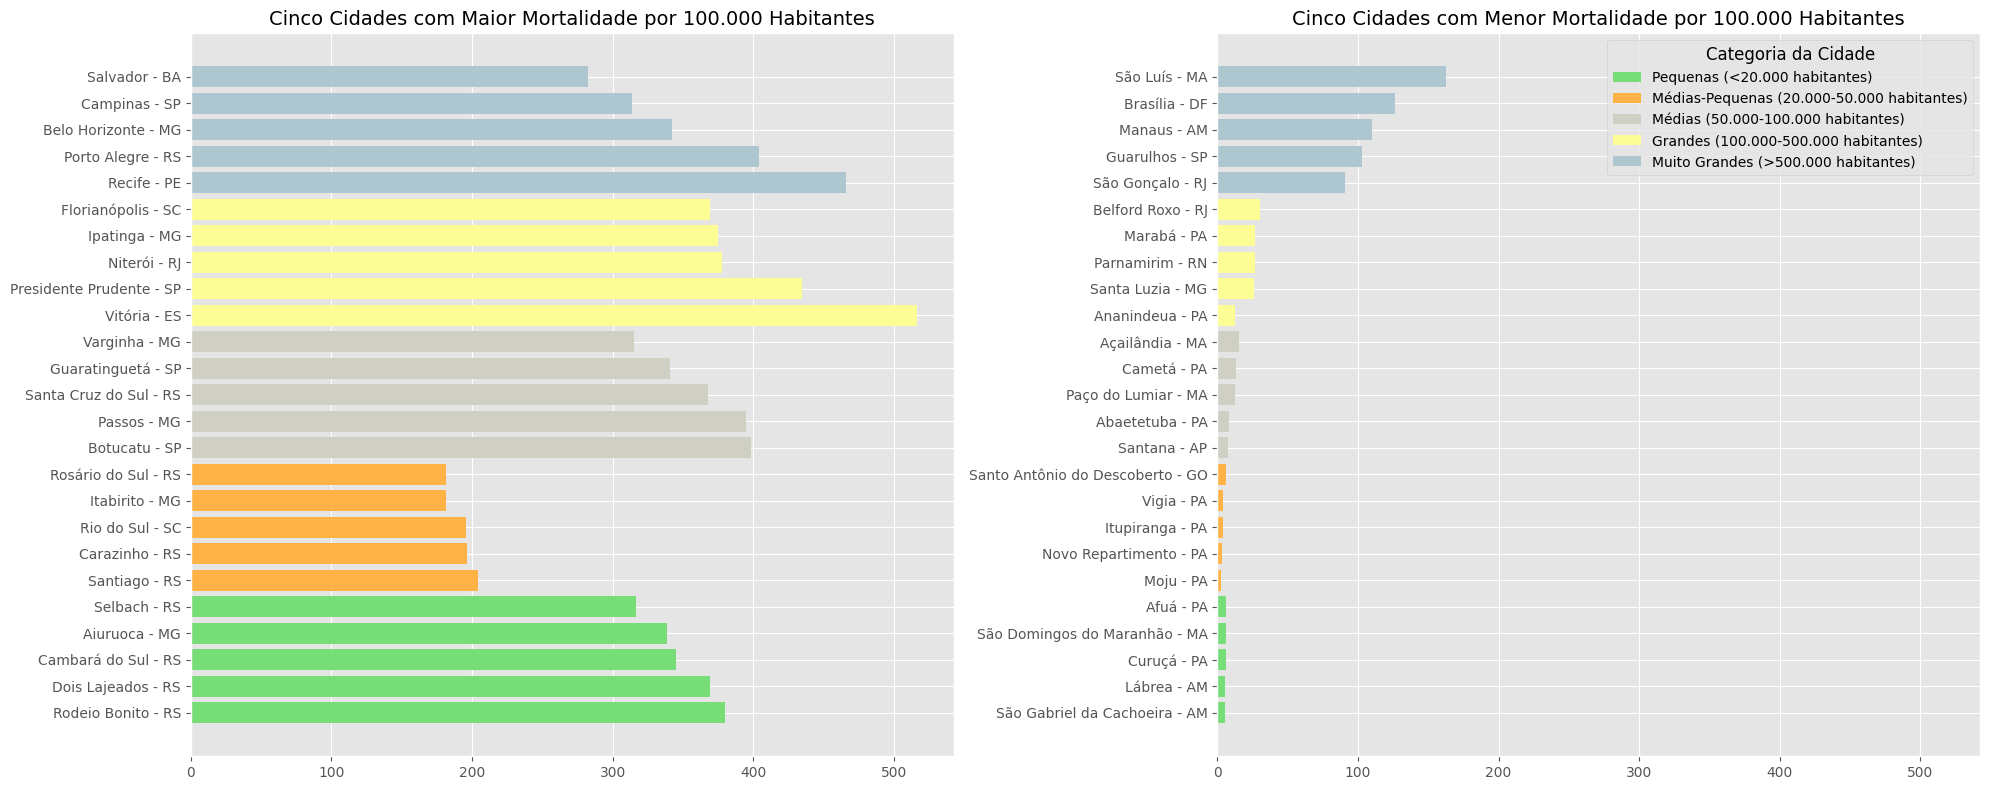

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Configurar o estilo do matplotlib
plt.style.use('ggplot')

# Definir as cores em tons pastéis para cada categoria de população
cores_categoria_populacao = {
    'Pequenas': '#77dd77',
    'Médias-Pequenas': '#ffb347',
    'Médias': '#cfcfc4',
    'Grandes': '#fdfd96',
    'Muito Grandes': '#aec6cf'
}

# Função para plotar gráfico de barras horizontais para top e bottom 5 cidades
def plot_top_bottom_cities_comparison(top5_df, bottom5_df, category_col, city_col, value_col, title_top, title_bottom):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), sharex=True)

    # Gráfico para top 5 cidades (maiores taxas de mortalidade)
    for category in top5_df[category_col].unique():
        data = top5_df[top5_df[category_col] == category]
        axes[0].barh(data[city_col], data[value_col], color=cores_categoria_populacao[category], label=f"{category} ({len(data)})")

    axes[0].set_title(title_top, fontsize=14)

    # Gráfico para bottom 5 cidades (menores taxas de mortalidade)
    for category in bottom5_df[category_col].unique():
        data = bottom5_df[bottom5_df[category_col] == category]
        axes[1].barh(data[city_col], data[value_col], color=cores_categoria_populacao[category], label=f"{category} ({len(data)})")

    axes[1].set_title(title_bottom, fontsize=14)

    handles, labels = axes[1].get_legend_handles_labels()
    legend_labels = [
        'Pequenas (<20.000 habitantes)',
        'Médias-Pequenas (20.000-50.000 habitantes)',
        'Médias (50.000-100.000 habitantes)',
        'Grandes (100.000-500.000 habitantes)',
        'Muito Grandes (>500.000 habitantes)'
    ]
    axes[1].legend(handles, legend_labels, title='Categoria da Cidade', fontsize=10, title_fontsize=12)

    plt.tight_layout()
    plt.show()

# Selecionar colunas desejadas e criar coluna 'cidade'
top5_cities_selected = top5_cities[['population_category', 'municipio', 'uf', 'mortality_per_100k']].copy()
top5_cities_selected['cidade'] = top5_cities_selected['municipio'] + ' - ' + top5_cities_selected['uf']

bottom5_cities_selected = bottom5_cities[['population_category', 'municipio', 'uf', 'mortality_per_100k']].copy()
bottom5_cities_selected['cidade'] = bottom5_cities_selected['municipio'] + ' - ' + bottom5_cities_selected['uf']

# Ordenar as cidades pelo valor de mortalidade para melhor visualização
top5_cities_selected = top5_cities_selected.sort_values(by=['population_category', 'mortality_per_100k'], ascending=[True, False])
bottom5_cities_selected = bottom5_cities_selected.sort_values(by=['population_category', 'mortality_per_100k'], ascending=[True, True])

# Plotar gráficos
plot_top_bottom_cities_comparison(top5_cities_selected, bottom5_cities_selected,
                                  category_col='population_category',
                                  city_col='cidade',
                                  value_col='mortality_per_100k',
                                  title_top= 'Cinco Cidades com Maior Mortalidade por 100.000 Habitantes',
                                  title_bottom='Cinco Cidades com Menor Mortalidade por 100.000 Habitantes')


### 7.6 - Avaliando a Mortalidade do câncer de mama por Faixa Etária em Mulheres

  3. **Perfil Etário das Vítimas: Como se distribuem as idades das mulheres que faleceram de câncer de mama?**

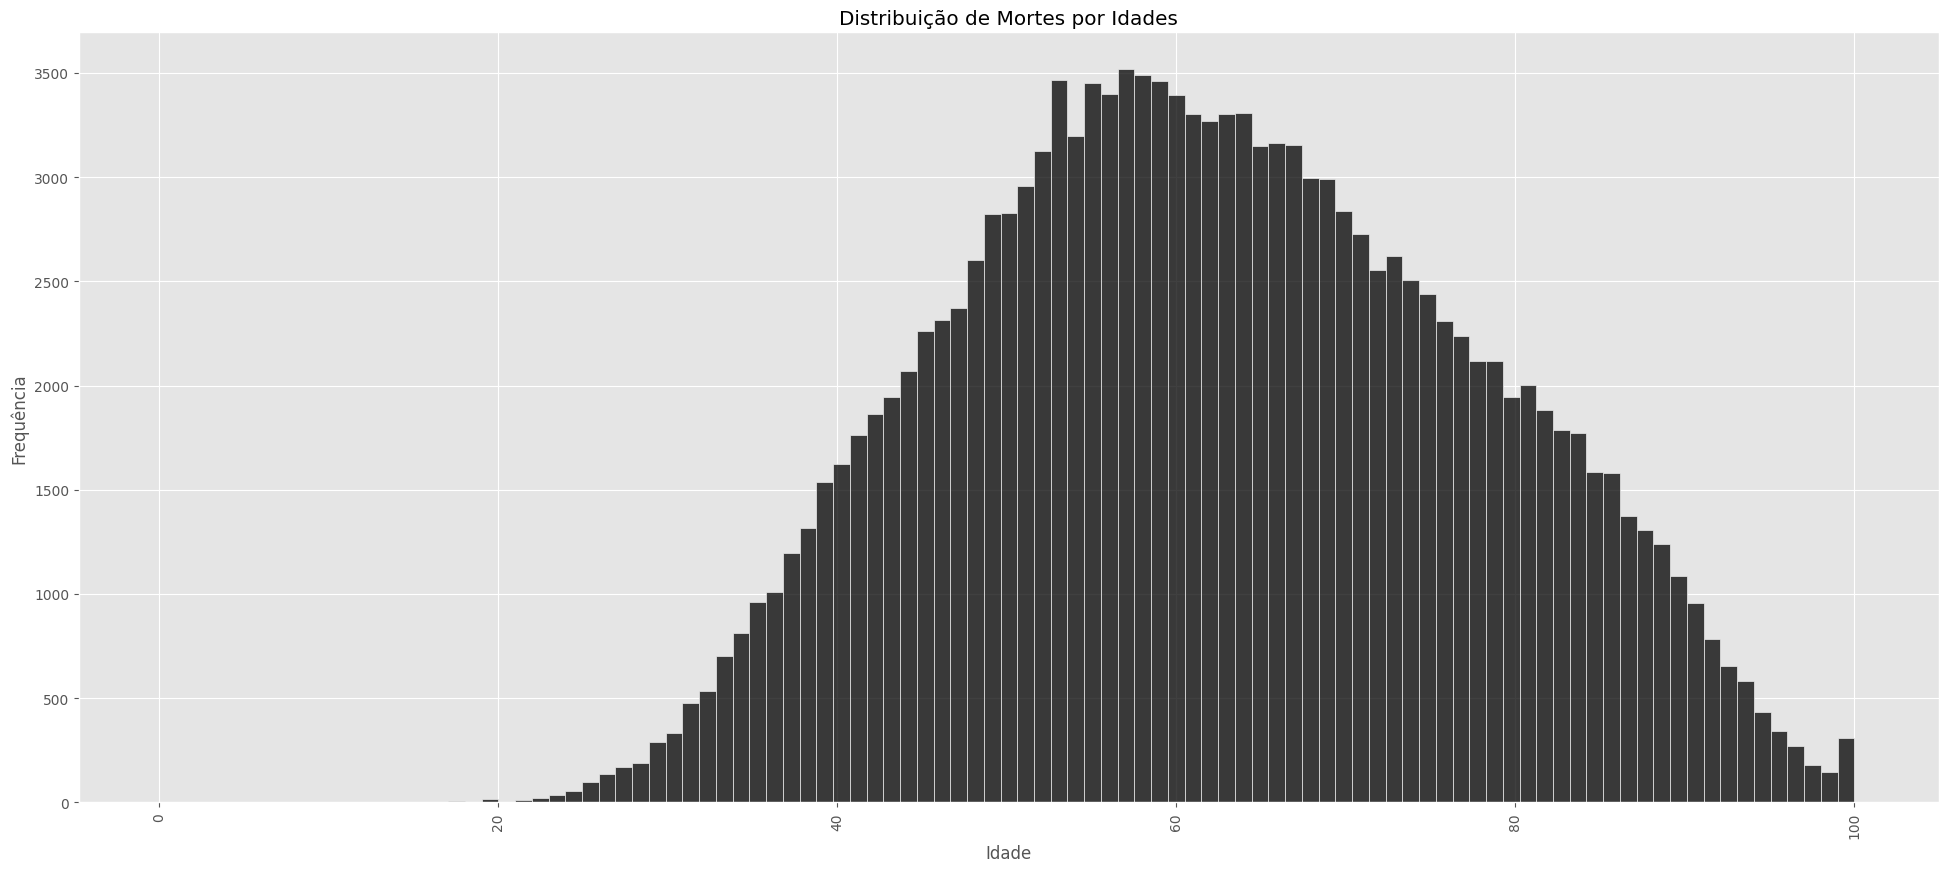

In [ ]:
# Agrega as estatísticas de idade mínima e máxima do DataFrame
age_stats = df_reg_ca_mama_no_dupli.agg(F.min("IDADE").alias("min_age"), F.max("IDADE").alias("max_age")).collect()
min_age = int(age_stats[0]["min_age"])
max_age = int(age_stats[0]["max_age"])

# Define o número de bins para o histograma
num_years = max_age - min_age + 1

# Converte DataFrame do PySpark para Pandas para a plotagem
pandas_df = df_reg_ca_mama_no_dupli.toPandas()

# Plota o histograma da coluna 'IDADE'
plt.figure(figsize=(24, 10))
sns.histplot(pandas_df['IDADE'], bins=num_years, kde=False, color='black')
plt.title('Distribuição de Mortes por Idades')
plt.xlabel('Idade')
plt.ylabel('Frequência')
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
plt.show()

#### Comentário: Perfil Etário das Vítimas
Este gráfico mostra a frequência de mortes por idade. Observamos que a frequência de mortes aumenta gradualmente com a idade, atingindo um pico na faixa etária de 50 a 59 anos, após o qual começa a diminuir. É importante notar que a diminuição na frequência de mortes em idades mais avançadas não necessariamente indica uma redução na mortalidade, mas sim uma menor frequência de casos registrados. Este padrão sugere que as mortes se concentram mais na meia-idade, possivelmente devido a uma maior prevalência de condições crônicas e outras causas de morte nessa faixa etária.

**Pontos-chave**:
- **Aumento Gradual**: A frequência de mortes aumenta gradualmente com a idade.
- **Pico na Meia-Idade**: A faixa etária de 50 a 59 anos apresenta a maior frequência de mortes.
- **Diminuição em Idades Avançadas**: Após o pico, a frequência de mortes diminui, o que pode refletir um menor número de pessoas sobrevivendo a essas idades mais avançadas.

**Observação**:
- A diminuição na frequência de mortes nas idades mais avançadas não deve ser interpretada como uma diminuição na mortalidade, mas sim como uma representação de menos casos registrados nessas idades.

### 7.6.1 - Comparação da Mortalidade Feminina em diferentes faixas etárias: Causas Naturais vs. Câncer de Mama

 4. Quais faixas etárias apresentam as maiores taxas de mortalidade por câncer de mama entre mulheres?

Ao extrair os números da mortalidade geral feminina no Brasil e separá-los por faixa etária, é essencial excluir quaisquer óbitos que decorram de causas não naturais, como acidentes e outras causas traumáticas. Estes são classificados sob os códigos CID-10 iniciados por 'V', 'W', 'X' e 'Y'.

Isso permite que a análise se concentre exclusivamente em mortes sem traumas físicos, oferecendo uma avaliação mais precisa e contextualizada da mortalidade relacionada ao câncer de mama e à saúde no país.

### 7.6.2 - Carregando a amostra da mortalidade_geral_f

In [ ]:
# Filtragem e agregação da população feminina nos dados demográficos:
df_populacao_feminina = df_prim_viz_demo.filter(
    (F.col("faixa_idade") != 'Total') &
    (F.col("valor_sexo") == 'Mulheres') &
    (~F.col("faixa_idade").rlike('^[0-9]+ anos$')) &
    (~F.col("faixa_idade").isin(['0 ano', '1 ano', '80 anos ou mais', 'Idade ignorada', 'Menos de 1 ano'])) &
    (F.col("populacao").isNotNull())
).groupBy("faixa_idade").agg(
    F.sum("populacao").alias("populacao")
).withColumnRenamed("faixa_idade", "idade")


In [ ]:
# Executar a consulta SQL para carregar os dados de mortalidade natural feminina
mortalidade_geral_faixa_et_f = spark.sql("""

SELECT
    IDADE, SEXO, RACACOR, ESTCIV, ESC, ESC2010, CONTADOR, CODMUNOCOR, DTOBITO
FROM
    sim_bronze.dores
WHERE
    CAUSABAS NOT LIKE 'V%' AND
    CAUSABAS NOT LIKE 'W%' AND
    CAUSABAS NOT LIKE 'X%' AND
    CAUSABAS NOT LIKE 'Y%' AND
    SEXO = "2"

""")

# Mostrar os primeiros registros para verificar o resultado
mortalidade_geral_faixa_et_f.show(2)

# Contar o número total de linhas no DataFrame
total_linhas = mortalidade_geral_faixa_et_f.count()

# Exibir o número total de linhas
print(f"Total de linhas: {total_linhas}")

# Limpa o df baseado na mesma função definida anteriormente na secção 6.10 de limpeza.
mortalidade_geral_faixa_et_f = limpar_df(mortalidade_geral_faixa_et_f)


# Contar o número total de linhas no DataFrame
total_linhas = mortalidade_geral_faixa_et_f.count()


# Contar a quantidade de valores nulos na coluna IDADE
num_nulos_idade = mortalidade_geral_faixa_et_f.filter(F.col("IDADE").isNull()).count()


# Filtrando pelos anos de interesse: 2013 a 2022

anos_interesse = list(range(2013, 2023))

mortalidade_geral_faixa_et_f = mortalidade_geral_faixa_et_f.filter(F.col("ANO").isin(anos_interesse))

mortalidade_geral_faixa_et_f.show(2)

total_linhas = mortalidade_geral_faixa_et_f.count()

# Exibir a quantidade de valores nulos
print(f"Quantidade de valores nulos na coluna IDADE: {num_nulos_idade}")

+-----+----+-------+------+---+-------+--------+----------+--------+
|IDADE|SEXO|RACACOR|ESTCIV|ESC|ESC2010|CONTADOR|CODMUNOCOR| DTOBITO|
+-----+----+-------+------+---+-------+--------+----------+--------+
|  488|   2|      1|     1|  5|      5|      12|    355030|13072021|
|  483|   2|      1|     2|  2|      1|      17|    355030|13072021|
+-----+----+-------+------+---+-------+--------+----------+--------+
only showing top 2 rows

Total de linhas: 6741847
+-----+----+-------+------+---+-------+--------+----------+----+---+---+
|IDADE|SEXO|RACACOR|ESTCIV|ESC|ESC2010|CONTADOR|CODMUNOCOR| ANO|MES|DIA|
+-----+----+-------+------+---+-------+--------+----------+----+---+---+
| 99.0|   2|      1|     3|  4|      3|       1|    354850|2022|  4| 21|
| 29.0|   2|      1|     2|  5|      5|      10|    354780|2016|  1|  1|
+-----+----+-------+------+---+-------+--------+----------+----+---+---+
only showing top 2 rows

Quantidade de valores nulos na coluna IDADE: 0


In [ ]:
from pyspark.sql import DataFrame, functions as F

def calcular_taxa_mortalidade_faixa_etaria(df_demo: DataFrame, df_obitos: DataFrame) -> DataFrame:
    # Filtragem e agregação da população feminina por faixa etária

    # Contagem de óbitos por câncer de mama por faixa etária
    df_obitos_cancer_mama = df_obitos.filter(
        (F.col("SEXO") == 2) & (F.col("IDADE") != 999)
    ).select(
        F.when(F.col("IDADE") < 5, '0 a 4 anos')
         .when((F.col("IDADE") >= 5) & (F.col("IDADE") < 10), '5 a 9 anos')
         .when((F.col("IDADE") >= 10) & (F.col("IDADE") < 15), '10 a 14 anos')
         .when((F.col("IDADE") >= 15) & (F.col("IDADE") < 20), '15 a 19 anos')
         .when((F.col("IDADE") >= 20) & (F.col("IDADE") < 25), '20 a 24 anos')
         .when((F.col("IDADE") >= 25) & (F.col("IDADE") < 30), '25 a 29 anos')
         .when((F.col("IDADE") >= 30) & (F.col("IDADE") < 35), '30 a 34 anos')
         .when((F.col("IDADE") >= 35) & (F.col("IDADE") < 40), '35 a 39 anos')
         .when((F.col("IDADE") >= 40) & (F.col("IDADE") < 45), '40 a 44 anos')
         .when((F.col("IDADE") >= 45) & (F.col("IDADE") < 50), '45 a 49 anos')
         .when((F.col("IDADE") >= 50) & (F.col("IDADE") < 55), '50 a 54 anos')
         .when((F.col("IDADE") >= 55) & (F.col("IDADE") < 60), '55 a 59 anos')
         .when((F.col("IDADE") >= 60) & (F.col("IDADE") < 65), '60 a 64 anos')
         .when((F.col("IDADE") >= 65) & (F.col("IDADE") < 70), '65 a 69 anos')
         .when((F.col("IDADE") >= 70) & (F.col("IDADE") < 75), '70 a 74 anos')
         .when((F.col("IDADE") >= 75) & (F.col("IDADE") < 80), '75 a 79 anos')
         .when((F.col("IDADE") >= 80) & (F.col("IDADE") < 85), '80 a 84 anos')
         .when((F.col("IDADE") >= 85) & (F.col("IDADE") < 90), '85 a 89 anos')
         .when((F.col("IDADE") >= 90) & (F.col("IDADE") < 95), '90 a 94 anos')
         .when((F.col("IDADE") >= 95) & (F.col("IDADE") < 100), '95 a 99 anos')
         .when(F.col("IDADE") >= 100, '100 anos ou mais')
         .alias("idade_obito")
    ).groupBy("idade_obito").agg(
        F.count("*").alias("obitos")
    )

    # Cálculo da taxa de mortalidade
    df_calculo_taxa_mortalidade = df_populacao_feminina.join(
        df_obitos_cancer_mama,
        df_populacao_feminina.idade == df_obitos_cancer_mama.idade_obito,
        "inner"
    ).select(
        df_populacao_feminina.idade,
        df_populacao_feminina.populacao,
        df_obitos_cancer_mama.obitos,
        (df_obitos_cancer_mama.obitos / df_populacao_feminina.populacao * 100000).alias("mort_cancermama_100k")
    )

    return df_calculo_taxa_mortalidade

# Exemplo de uso:

# df_obitos = ... (DataFrame com dados de óbitos)
# resultado = calcular_taxa_mortalidade(df_demo, df_obitos)
# resultado.show()


In [ ]:
# Calcular a taxa de mortalidade por faixa etária para o câncer de mama
resultado_2 = calcular_taxa_mortalidade_faixa_etaria(df_populacao_feminina, df_reg_ca_mama_no_dupli)

# Calcular a taxa de mortalidade por faixa etária para a mortalidade geral
resultado_3 = calcular_taxa_mortalidade_faixa_etaria(df_populacao_feminina, mortalidade_geral_faixa_et_f).withColumnRenamed("mort_cancermama_100k", "mort_geral_f_100k")

# Exibir e contar os resultados de resultado_2
resultado_2.show(3)
print(f"Total de registros em resultado_2: {resultado_2.count()}")

# Exibir e contar os resultados de resultado_3
resultado_3.show(3)
print(f"Total de registros em resultado_3: {resultado_3.count()}")

# Realizar o inner join entre os dois resultados
resultado_mort_faixaet = resultado_2.join(resultado_3, ["idade"], "inner")

# Exibir o resultado final do join
resultado_mort_faixaet.show(3)
print(f"Total de registros no resultado_mort_faixaet: {resultado_mort_faixaet.count()}")


+------------+---------+------+--------------------+
|       idade|populacao|obitos|mort_cancermama_100k|
+------------+---------+------+--------------------+
|60 a 64 anos|3470166.0| 16350|   471.1590166003586|
|45 a 49 anos|6141926.0| 12291|   200.1163804318059|
|70 a 74 anos|2069194.0| 13025|   629.4721519586853|
+------------+---------+------+--------------------+
only showing top 3 rows

Total de registros em resultado_2: 21
+------------+---------+------+------------------+
|       idade|populacao|obitos| mort_geral_f_100k|
+------------+---------+------+------------------+
|95 a 99 anos|  66458.0| 58934| 88678.56390502272|
|25 a 29 anos|8644131.0| 10267|118.77422958999581|
|60 a 64 anos|3470166.0|119205|3435.1382613972933|
+------------+---------+------+------------------+
only showing top 3 rows

Total de registros em resultado_3: 21
+----------------+---------+------+--------------------+---------+------+------------------+
|           idade|populacao|obitos|mort_cancermama_10

### 7.6.3 - Mortalidade faixa etária por 100.000 habitantes

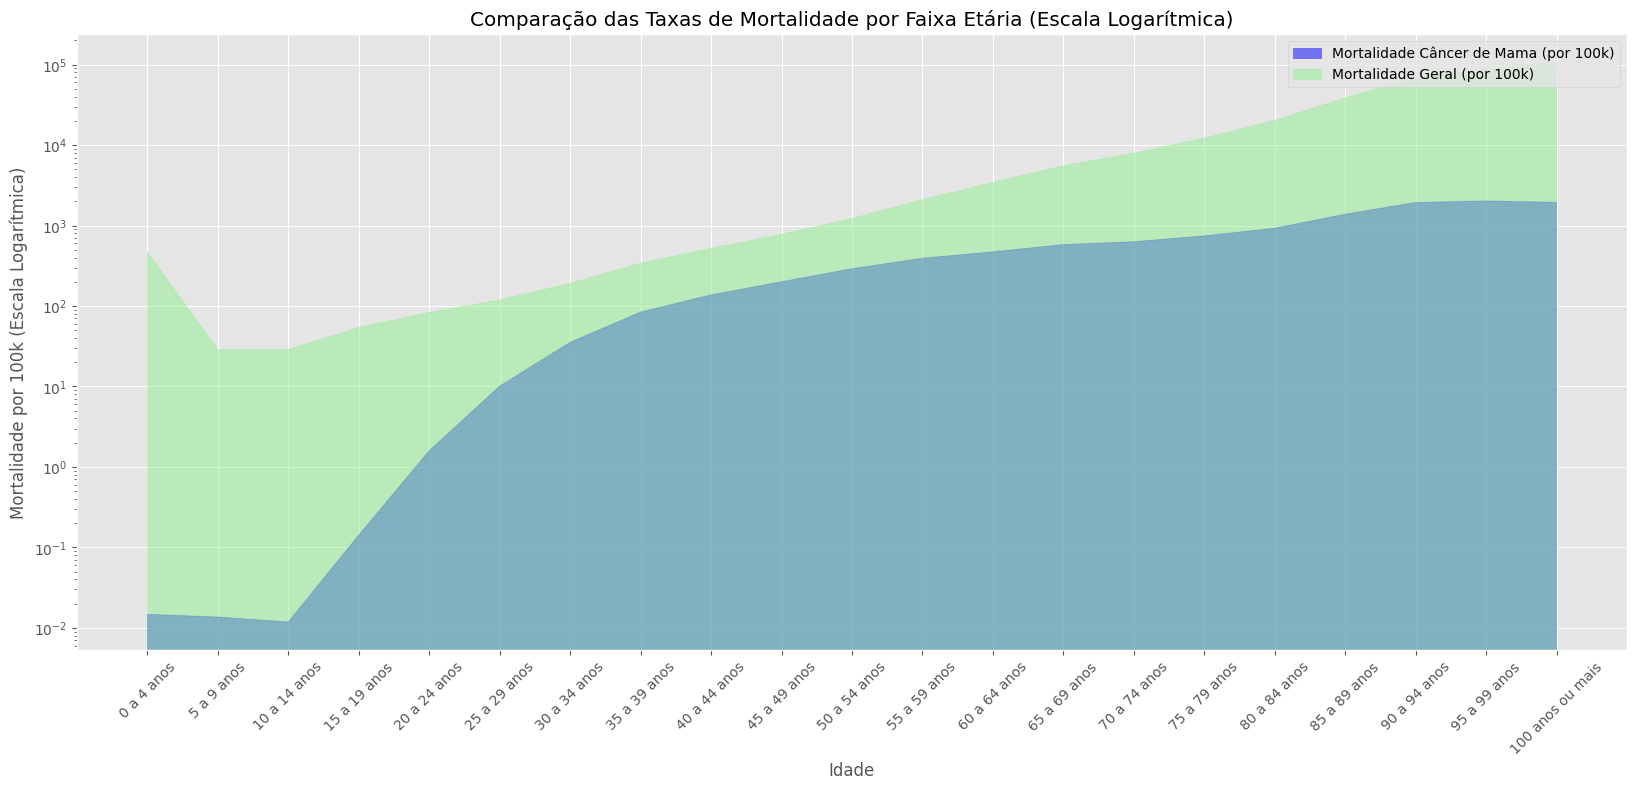

In [ ]:
# Converter o DataFrame do Spark para Pandas
pandas_df_final = resultado_mort_faixaet.toPandas()

# Função personalizada para ordenar as faixas etárias
def ordenar_faixas_etarias(faixa_etaria):
    if faixa_etaria == '100 anos ou mais':
        return 100
    else:
        partes = faixa_etaria.split(' ')
        return int(partes[0])

# Ordenar o DataFrame pelas faixas etárias usando a função personalizada
pandas_df_final['ordem'] = pandas_df_final['idade'].apply(ordenar_faixas_etarias)
pandas_df_final = pandas_df_final.sort_values('ordem')

# Remover a coluna de ordenação auxiliar
pandas_df_final = pandas_df_final.drop(columns=['ordem'])

# Plotar o gráfico de área com escala logarítmica
plt.figure(figsize=(20, 8))

# Gráfico de área
plt.fill_between(pandas_df_final['idade'], pandas_df_final['mort_cancermama_100k'], alpha=0.5, label='Mortalidade Câncer de Mama (por 100k)', color='blue')
plt.fill_between(pandas_df_final['idade'], pandas_df_final['mort_geral_f_100k'], alpha=0.5, label='Mortalidade Geral (por 100k)', color='lightgreen')

# Adicionar título e rótulos aos eixos
plt.title('Comparação das Taxas de Mortalidade por Faixa Etária (Escala Logarítmica)')
plt.xlabel('Idade')
plt.ylabel('Mortalidade por 100k (Escala Logarítmica)')
plt.yscale('log')  # Define a escala do eixo y como logarítmica
plt.xticks(rotation=45)
plt.legend()

# Mostrar o gráfico
plt.show()


#### Comentário: Mortalidade por Causas Naturais vs. Câncer de Mama por Faixa Etária

**Gráfico: Mortalidade por Causas Naturais vs. Câncer de Mama**

Este gráfico mostra a comparação entre a mortalidade por causas naturais e a mortalidade por câncer de mama, distribuídas por faixa etária.

**Observações**:
1. **Mortalidade Natural**:
   - A mortalidade por causas naturais aumenta gradualmente com a idade.
   - As faixas etárias de 85 a 89 anos, 90 a 94 anos e 95 a 99 anos apresentam as maiores quantidades de óbitos por causas naturais.

2. **Mortalidade por Câncer de Mama**:
   - A mortalidade por câncer de mama começa a aumentar a partir da faixa etária de 30 a 34 anos.
   - A mortalidade por câncer de mama cresce de forma constante até a faixa etária de 60 a 64 anos e permanece alta nas idades mais avançadas.

3. **Comparação entre Causas Naturais e Câncer de Mama**:
   - A taxa de mortalidade por câncer de mama aumenta significativamente a partir dos 30 anos, mas a mortalidade por causas naturais aumenta de forma mais acentuada nas idades mais avançadas.

**Conclusão**:
- A mortalidade por câncer de mama, embora menor que a mortalidade por causas naturais, mostra uma tendência ascendente significativa a partir dos 30 anos e se mantém elevada nas idades avançadas.
- Programas de saúde pública devem focar tanto na prevenção e tratamento de câncer de mama quanto no manejo de condições crônicas em idosos para reduzir a mortalidade geral.


# Parte VIII:



# Clusterização

# 8.1 - Preparação do dataframe para Clusterização


Preparação

In [ ]:
df_reg_ca_mama_no_dupli.show(3)
df_reg_ca_mama_no_dupli.count()

+-----+----+-------+------+----+-------+--------+----------+----+---+---+
|IDADE|SEXO|RACACOR|ESTCIV| ESC|ESC2010|CONTADOR|CODMUNOCOR| ANO|MES|DIA|
+-----+----+-------+------+----+-------+--------+----------+----+---+---+
| 64.0|   2|      1|     2|null|   null|       1|    431490|2015|  2| 26|
| 49.0|   2|      1|     5|   4|      3|      10|    211130|2016|  1|  1|
| 70.0|   2|      4|     2|null|   null|    1000|    230310|2016|  1|  7|
+-----+----+-------+------+----+-------+--------+----------+----+---+---+
only showing top 3 rows



143172

In [ ]:
df_result_1.show(3)
df_result_1.count()

+---+----------+-----+---------+------------+------------+
| uf|CODMUNOCOR|count|populacao|   municipio|macro_regiao|
+---+----------+-----+---------+------------+------------+
| RS|    431490| 3052|   755564|Porto Alegre|         Sul|
| MA|    211130|  879|   539842|    São Luís|    Nordeste|
| CE|    230310|    7|     9205|      Cariré|    Nordeste|
+---+----------+-----+---------+------------+------------+
only showing top 3 rows



4016

In [ ]:
from pyspark.ml.clustering import KMeans

In [ ]:
# Função para categorizar as cidades por faixas de população
def categorize_cities_by_population(df: DataFrame) -> DataFrame:
    df_categorized = df.withColumn(
        "population_category",
        F.when(F.col("populacao") <= 20000, "Pequenas")
         .when((F.col("populacao") > 20000) & (F.col("populacao") <= 50000), "Médias-Pequenas")
         .when((F.col("populacao") > 50000) & (F.col("populacao") <= 100000), "Médias")
         .when((F.col("populacao") > 100000) & (F.col("populacao") <= 500000), "Grandes")
         .otherwise("Muito Grandes")
    )
    return df_categorized

# Função para remover outliers de cada categoria de cidade separadamente
def remove_outliers_spark(df: DataFrame, category_col: str, value_col: str) -> DataFrame:
    window_spec = Window.partitionBy(category_col)

    q1 = F.expr(f'percentile_approx({value_col}, 0.25)').over(window_spec)
    q3 = F.expr(f'percentile_approx({value_col}, 0.75)').over(window_spec)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    df_with_bounds = df.withColumn("q1", q1).withColumn("q3", q3).withColumn("iqr", iqr).withColumn("lower_bound", lower_bound).withColumn("upper_bound", upper_bound)

    df_cleaned = df_with_bounds.filter((F.col(value_col) >= F.col("lower_bound")) & (F.col(value_col) <= F.col("upper_bound"))).drop("q1", "q3", "iqr", "lower_bound", "upper_bound")

    return df_cleaned

# Nome do DataFrame
df = df_result_1

# Passo 1: Somar a coluna 'count' e remover duplicatas em 'CODMUNOCOR' e 'populacao'
df_grouped = df.groupBy("CODMUNOCOR", "populacao", "municipio") \
               .agg(F.sum("count").alias("total_count"))

# Passo 2: Aplicar a função de categorizar as cidades por faixas de população
df_categorized = categorize_cities_by_population(df_grouped)

# Passo 3: Remover outliers
df_cleaned_outlier = remove_outliers_spark(df_categorized, 'population_category', 'total_count')

# Exibir o resultado
df_cleaned_outlier.show(3)
df_cleaned_outlier.count()

+----------+---------+------------+-----------+-------------------+
|CODMUNOCOR|populacao|   municipio|total_count|population_category|
+----------+---------+------------+-----------+-------------------+
|    221100|   433618|    Teresina|        771|            Grandes|
|    411990|   160249|Ponta Grossa|        357|            Grandes|
|    431560|   102245|  Rio Grande|        247|            Grandes|
+----------+---------+------------+-----------+-------------------+
only showing top 3 rows



3746

df_cluster_c

In [ ]:
def prepare_and_clean_data(df_main: DataFrame, df_demo: DataFrame) -> DataFrame:
    # Passo 1: Filtrar apenas registros femininos (SEXO == 2) no DataFrame principal
    df_feminino = df_main.filter(F.col("SEXO") == 2)

    # Passo 2: Filtrar apenas registros femininos na tabela demográfica
    df_demo_fem = df_demo.filter(F.col("valor_sexo") == "Mulheres")

    # Passo 3: Remover o último dígito da coluna codigo_local e agregar dados demográficos
    df_demo_agg = df_demo_fem.withColumn("codigo_local_trimmed", F.expr("substring(codigo_local, 1, length(codigo_local) - 1)"))\
        .groupBy("codigo_local_trimmed")\
        .agg(F.first("populacao").alias("populacao"), F.first("nome_local").alias("nome_local"), F.first("valor_sexo").alias("valor_sexo"))

    # Convertendo a coluna populacao para DoubleType
    df_demo_agg = df_demo_agg.withColumn("populacao", df_demo_agg["populacao"].cast(DoubleType()))

    # Passo 4: Realizar a junção pelas colunas que contêm os códigos dos municípios
    df_joined = df_feminino.join(df_demo_agg, df_feminino["CODMUNOCOR"] == df_demo_agg["codigo_local_trimmed"], "left")

    # Remover registros com valores nulos na coluna 'populacao'
    df_cleaned_cluster = df_joined.filter(F.col("populacao").isNotNull())

    # Adicionar coluna 'municipio'
    df_cleaned_cluster = df_cleaned_cluster.withColumn('municipio', F.split(F.col('nome_local'), ' - ')[0])

    # Remover colunas desnecessárias e registros onde IDADE é 999
    df_cleaned_cluster = df_cleaned_cluster.drop("nome_local", "codigo_local_trimmed", 'ANO', 'MES', 'DIA','CONTADOR','valor_sexo','SEXO')

    df_cleaned_cluster = df_cleaned_cluster.filter(F.col("IDADE") != 999)

    # Verificar a contagem de registros após a remoção
    total_registros_cleaned = df_cleaned_cluster.count()
    print(f"Total de registros após remover valores nulos na coluna 'populacao' e IDADE igual a 999: {total_registros_cleaned}")

    return df_cleaned_cluster

# Exemplo de uso com os DataFrames carregados
df_cleaned_cluster = prepare_and_clean_data(df_reg_ca_mama_no_dupli, df_prim_viz_demo)
df_cleaned_cluster.show(3)






Total de registros após remover valores nulos na coluna 'populacao' e IDADE igual a 999: 141432
+-----+-------+------+----+-------+----------+---------+------------+
|IDADE|RACACOR|ESTCIV| ESC|ESC2010|CODMUNOCOR|populacao|   municipio|
+-----+-------+------+----+-------+----------+---------+------------+
| 64.0|      1|     2|null|   null|    431490| 755564.0|Porto Alegre|
| 49.0|      1|     5|   4|      3|    211130| 539842.0|    São Luís|
| 70.0|      4|     2|null|   null|    230310|   9205.0|      Cariré|
+-----+-------+------+----+-------+----------+---------+------------+
only showing top 3 rows



Inner Join entre o dataframe que continha a lista de todas as cidades após limpeza de municipios considerados outliers baseados na categorização das cidades pela sua população.

In [ ]:
df_cluster_c = df_cleaned_cluster.join(df_cleaned_outlier.select("CODMUNOCOR").distinct(), on="CODMUNOCOR", how="inner")

In [ ]:
# Verificando se a filtragem com inner join funcionou
distinct_count_municipio_out = df_cleaned_outlier.select("CODMUNOCOR").distinct().count()

print(distinct_count_municipio_out)


distinct_count_municipio = df_cluster_c.select("CODMUNOCOR").distinct().count()
print(distinct_count_municipio)


# Criar uma lista de expressões para contar valores nulos em cada coluna
null_count_exprs = [F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df_cluster_c.columns]

# Aplicar as expressões ao DataFrame
null_counts = df_cluster_c.select(*null_count_exprs)

# Mostrar o resultado
null_counts.show()

3746
3743
+----------+-----+-------+------+-----+-------+---------+---------+
|CODMUNOCOR|IDADE|RACACOR|ESTCIV|  ESC|ESC2010|populacao|municipio|
+----------+-----+-------+------+-----+-------+---------+---------+
|         0|    0|   3287|  6223|17186|  18061|        0|        0|
+----------+-----+-------+------+-----+-------+---------+---------+



In [ ]:
df_cluster_c.show(3)

+----------+-----+-------+------+----+-------+---------+------------+
|CODMUNOCOR|IDADE|RACACOR|ESTCIV| ESC|ESC2010|populacao|   municipio|
+----------+-----+-------+------+----+-------+---------+------------+
|    431490| 64.0|      1|     2|null|   null| 755564.0|Porto Alegre|
|    211130| 49.0|      1|     5|   4|      3| 539842.0|    São Luís|
|    230310| 70.0|      4|     2|null|   null|   9205.0|      Cariré|
+----------+-----+-------+------+----+-------+---------+------------+
only showing top 3 rows



In [ ]:
# Aplicar a função de categorizar as cidades por faixas de população
df_cluster_b = categorize_cities_by_population(df_cluster_c)

# Exibir o resultado final
df_cluster_b.show(3)

print(f"Total de registros após o join: {df_cluster_c.count()}")

# Gerar expressões para contar valores nulos
null_count_exprs = [F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df_cluster_c.columns]

# Aplicar as expressões ao DataFrame
null_counts = df_cluster_c.select(null_count_exprs)

# Mostrar o resultado
null_counts.show()



+----------+-----+-------+------+----+-------+---------+------------+-------------------+
|CODMUNOCOR|IDADE|RACACOR|ESTCIV| ESC|ESC2010|populacao|   municipio|population_category|
+----------+-----+-------+------+----+-------+---------+------------+-------------------+
|    431490| 64.0|      1|     2|null|   null| 755564.0|Porto Alegre|      Muito Grandes|
|    211130| 49.0|      1|     5|   4|      3| 539842.0|    São Luís|      Muito Grandes|
|    230310| 70.0|      4|     2|null|   null|   9205.0|      Cariré|           Pequenas|
+----------+-----+-------+------+----+-------+---------+------------+-------------------+
only showing top 3 rows

Total de registros após o join: 98544
+----------+-----+-------+------+-----+-------+---------+---------+
|CODMUNOCOR|IDADE|RACACOR|ESTCIV|  ESC|ESC2010|populacao|municipio|
+----------+-----+-------+------+-----+-------+---------+---------+
|         0|    0|   3287|  6223|17186|  18061|        0|        0|
+----------+-----+-------+------+--

In [ ]:
# Calcular a mortalidade por 100.000 habitantes
df_mortality_city = df_grouped.withColumn(
    "mortality_per_100k",
    (F.col("total_count") / F.col("populacao")) * 100000





)


# Exibir o resultado
df_mortality_city.show(3)
df_mortality_city.count()

+----------+---------+------------+-----------+------------------+
|CODMUNOCOR|populacao|   municipio|total_count|mortality_per_100k|
+----------+---------+------------+-----------+------------------+
|    431490|   755564|Porto Alegre|       3052|403.93666188436714|
|    211130|   539842|    São Luís|        879|162.82541928934762|
|    230310|     9205|      Cariré|          7| 76.04562737642586|
+----------+---------+------------+-----------+------------------+
only showing top 3 rows



4016

In [ ]:
# Função para categorizar as idades por faixas etárias
def categorize_age(df: DataFrame) -> DataFrame:
    df_categorized = df.withColumn(
        "age_category",
        F.when(F.col("IDADE") < 5, '0 a 4 anos')
         .when((F.col("IDADE") >= 5) & (F.col("IDADE") < 10), '5 a 9 anos')
         .when((F.col("IDADE") >= 10) & (F.col("IDADE") < 15), '10 a 14 anos')
         .when((F.col("IDADE") >= 15) & (F.col("IDADE") < 20), '15 a 19 anos')
         .when((F.col("IDADE") >= 20) & (F.col("IDADE") < 25), '20 a 24 anos')
         .when((F.col("IDADE") >= 25) & (F.col("IDADE") < 30), '25 a 29 anos')
         .when((F.col("IDADE") >= 30) & (F.col("IDADE") < 35), '30 a 34 anos')
         .when((F.col("IDADE") >= 35) & (F.col("IDADE") < 40), '35 a 39 anos')
         .when((F.col("IDADE") >= 40) & (F.col("IDADE") < 45), '40 a 44 anos')
         .when((F.col("IDADE") >= 45) & (F.col("IDADE") < 50), '45 a 49 anos')
         .when((F.col("IDADE") >= 50) & (F.col("IDADE") < 55), '50 a 54 anos')
         .when((F.col("IDADE") >= 55) & (F.col("IDADE") < 60), '55 a 59 anos')
         .when((F.col("IDADE") >= 60) & (F.col("IDADE") < 65), '60 a 64 anos')
         .when((F.col("IDADE") >= 65) & (F.col("IDADE") < 70), '65 a 69 anos')
         .when((F.col("IDADE") >= 70) & (F.col("IDADE") < 75), '70 a 74 anos')
         .when((F.col("IDADE") >= 75) & (F.col("IDADE") < 80), '75 a 79 anos')
         .when((F.col("IDADE") >= 80) & (F.col("IDADE") < 85), '80 a 84 anos')
         .when((F.col("IDADE") >= 85) & (F.col("IDADE") < 90), '85 a 89 anos')
         .when((F.col("IDADE") >= 90) & (F.col("IDADE") < 95), '90 a 94 anos')
         .when((F.col("IDADE") >= 95) & (F.col("IDADE") < 100), '95 a 99 anos')
         .when(F.col("IDADE") == 999, 'None')
         .otherwise('100+ anos')
    )
    return df_categorized



# Aplicar a função ao DataFrame df_cluster_b

df_cluster_b = categorize_age(df_cluster_b)


df_cluster_b.show(3)


+----------+-----+-------+------+----+-------+---------+------------+-------------------+------------+
|CODMUNOCOR|IDADE|RACACOR|ESTCIV| ESC|ESC2010|populacao|   municipio|population_category|age_category|
+----------+-----+-------+------+----+-------+---------+------------+-------------------+------------+
|    431490| 64.0|      1|     2|null|   null| 755564.0|Porto Alegre|      Muito Grandes|60 a 64 anos|
|    211130| 49.0|      1|     5|   4|      3| 539842.0|    São Luís|      Muito Grandes|45 a 49 anos|
|    230310| 70.0|      4|     2|null|   null|   9205.0|      Cariré|           Pequenas|70 a 74 anos|
+----------+-----+-------+------+----+-------+---------+------------+-------------------+------------+
only showing top 3 rows



In [ ]:
df_cluster_a = df_cluster_b.drop('municipio')

In [ ]:
def count_unique_values(df: DataFrame) -> DataFrame:
    unique_counts = {col: df.select(col).distinct().count() for col in df.columns}
    return pd.DataFrame(list(unique_counts.items()), columns=['Column', 'UniqueCount'])

# Nome do DataFrame
df = df_cluster_a

# Contar valores únicos em cada coluna do DataFrame df_cluster_b
unique_value_counts_df = count_unique_values(df)

# Convertendo para Spark DataFrame para ordenar e exibir
unique_value_counts_spark_df = spark.createDataFrame(unique_value_counts_df)

# Ordenar o resultado em ordem decrescente
unique_value_counts_sorted = unique_value_counts_spark_df.orderBy(F.col("UniqueCount").desc())

# Exibir o resultado
unique_value_counts_sorted.show()

+-------------------+-----------+
|             Column|UniqueCount|
+-------------------+-----------+
|         CODMUNOCOR|       3743|
|          populacao|       3424|
|              IDADE|         87|
|       age_category|         21|
|                ESC|          7|
|            ESC2010|          7|
|            RACACOR|          6|
|             ESTCIV|          6|
|population_category|          5|
+-------------------+-----------+



In [ ]:
# Contar categorias distintas em cada coluna categórica e guardar em variáveis
distinct_racacor = df_cluster_a.select("RACACOR").distinct().rdd.flatMap(lambda x: x).collect()
distinct_estciv = df_cluster_a.select("ESTCIV").distinct().rdd.flatMap(lambda x: x).collect()
distinct_esc = df_cluster_a.select("ESC").distinct().rdd.flatMap(lambda x: x).collect()
distinct_esc2010 = df_cluster_a.select("ESC2010").distinct().rdd.flatMap(lambda x: x).collect()
distinct_age_category = df_cluster_a.select("age_category").distinct().rdd.flatMap(lambda x: x).collect()
distinct_population_category = df_cluster_a.select("population_category").distinct().rdd.flatMap(lambda x: x).collect()
distinct_racacor, distinct_estciv, distinct_esc, distinct_esc2010, distinct_age_category, distinct_population_category


(['1', '4', None, '2', '5', '3'],
 ['2', '5', '4', '3', '1', None],
 [None, '4', '1', '2', '5', '3', '0'],
 [None, '2', '1', '3', '0', '5', '4'],
 ['60 a 64 anos',
  '45 a 49 anos',
  '70 a 74 anos',
  '90 a 94 anos',
  '50 a 54 anos',
  '55 a 59 anos',
  '85 a 89 anos',
  '30 a 34 anos',
  '65 a 69 anos',
  '40 a 44 anos',
  '35 a 39 anos',
  '75 a 79 anos',
  '80 a 84 anos',
  '95 a 99 anos',
  '25 a 29 anos',
  '20 a 24 anos',
  '100+ anos',
  '0 a 4 anos',
  '15 a 19 anos',
  '10 a 14 anos',
  '5 a 9 anos'],
 ['Muito Grandes', 'Pequenas', 'Grandes', 'Médias', 'Médias-Pequenas'])

In [ ]:
df_cluster_a.show(3)

+----------+-----+-------+------+----+-------+---------+-------------------+------------+
|CODMUNOCOR|IDADE|RACACOR|ESTCIV| ESC|ESC2010|populacao|population_category|age_category|
+----------+-----+-------+------+----+-------+---------+-------------------+------------+
|    431490| 64.0|      1|     2|null|   null| 755564.0|      Muito Grandes|60 a 64 anos|
|    211130| 49.0|      1|     5|   4|      3| 539842.0|      Muito Grandes|45 a 49 anos|
|    230310| 70.0|      4|     2|null|   null|   9205.0|           Pequenas|70 a 74 anos|
+----------+-----+-------+------+----+-------+---------+-------------------+------------+
only showing top 3 rows



In [ ]:
# Função para gerar expressões de contagem
def generate_proportion_exprs(column, distinct_values):
    return [(F.count(F.when(F.col(column) == val, True)) / F.count("*")).alias(f"{column}_{val}_prop") for val in distinct_values]

# Gerar expressões de contagem para cada coluna categórica
racacor_exprs = generate_proportion_exprs("RACACOR", distinct_racacor)
estciv_exprs = generate_proportion_exprs("ESTCIV", distinct_estciv)
esc_exprs = generate_proportion_exprs("ESC", distinct_esc)
esc2010_exprs = generate_proportion_exprs("ESC2010", distinct_esc2010)
age_category_exprs = generate_proportion_exprs("age_category", distinct_age_category)
population_category_exprs = generate_proportion_exprs("population_category", distinct_population_category)

# Combinar todas as expressões corretamente
all_exprs = racacor_exprs + estciv_exprs + esc_exprs + esc2010_exprs + age_category_exprs + population_category_exprs



# Calcular proporções para cada categoria
df_proportions = df_cluster_a.groupBy("CODMUNOCOR").agg(*all_exprs)

# Mostrar as primeiras linhas para verificar
df_proportions.show(5)

+----------+-------------------+-------------------+-----------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------+-------------------+-------------------+----------------+-------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-----------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+----------

In [ ]:
# Calcular a média de idade por município
df_media_idade = df_cluster_a.groupBy("CODMUNOCOR").agg(F.avg("IDADE").alias("media_idade"))


# Fazer o join dos dois DataFrames usando a coluna 'CODMUNOCOR' como chave
df_mortality_city = df_mortality_city.join(df_media_idade, on="CODMUNOCOR", how="left")

# Mostrar as primeiras linhas do DataFrame resultante para verificar
df_mortality_city.show(5)


+----------+---------+------------+-----------+------------------+-----------------+
|CODMUNOCOR|populacao|   municipio|total_count|mortality_per_100k|      media_idade|
+----------+---------+------------+-----------+------------------+-----------------+
|    211130|   539842|    São Luís|        879|162.82541928934762| 57.5415244596132|
|    221100|   433618|    Teresina|        771|177.80627187985738|57.14656290531777|
|    230310|     9205|      Cariré|          7| 76.04562737642586|             60.0|
|    261160|   827885|      Recife|       3857| 465.8859624223171|60.76841286307054|
|    411990|   160249|Ponta Grossa|        357|222.77830126865064|61.71708683473389|
+----------+---------+------------+-----------+------------------+-----------------+
only showing top 5 rows



### Join entre dataframe com dados cidades e dataframe com todos os casos

In [ ]:
# Selecionar as colunas necessárias e renomear 'total_count' para 'total_obitos'
df_mortality_city_selected = df_mortality_city.select(
    "CODMUNOCOR",
    "mortality_per_100k",
    "media_idade",
    F.col("total_count").alias("total_obitos")
)

# Realizar o join utilizando apenas as colunas necessárias
df_final = df_proportions.join(df_mortality_city_selected, on="CODMUNOCOR", how="inner")

# Mostrar as primeiras linhas do DataFrame final para verificar
df_final.count()


3743

In [ ]:
df_final.show(3)

+----------+------------------+--------------+-----------------+-------------------+--------------+--------------+------------------+-------------------+-------------------+-------------------+-------------------+----------------+-------------+-------------------+----------+-------------------+----------+----------+----------+-----------------+--------------+------------------+-------------------+--------------+--------------+--------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+---------------------------+----------------------------+--

In [ ]:
# Listar todas as colunas no DataFrame
all_columns = df_final.columns

# Filtrar colunas para remover aquelas que contêm "ESC2010", "age_category", ou "total_obitos"
selected_columns = [col for col in all_columns if not any(substring in col for substring in ["population_category", "ESC2010", "age_category", "total_obitos"])]

# Atualizar 'df_final' para conter apenas as colunas restantes
df_final = df_final.select(*selected_columns)

# Exibir o esquema das colunas restantes no DataFrame filtrado
df_final.printSchema()


root
 |-- CODMUNOCOR: string (nullable = true)
 |-- RACACOR_1_prop: double (nullable = true)
 |-- RACACOR_4_prop: double (nullable = true)
 |-- RACACOR_None_prop: double (nullable = true)
 |-- RACACOR_2_prop: double (nullable = true)
 |-- RACACOR_5_prop: double (nullable = true)
 |-- RACACOR_3_prop: double (nullable = true)
 |-- ESTCIV_2_prop: double (nullable = true)
 |-- ESTCIV_5_prop: double (nullable = true)
 |-- ESTCIV_4_prop: double (nullable = true)
 |-- ESTCIV_3_prop: double (nullable = true)
 |-- ESTCIV_1_prop: double (nullable = true)
 |-- ESTCIV_None_prop: double (nullable = true)
 |-- ESC_None_prop: double (nullable = true)
 |-- ESC_4_prop: double (nullable = true)
 |-- ESC_1_prop: double (nullable = true)
 |-- ESC_2_prop: double (nullable = true)
 |-- ESC_5_prop: double (nullable = true)
 |-- ESC_3_prop: double (nullable = true)
 |-- ESC_0_prop: double (nullable = true)
 |-- mortality_per_100k: double (nullable = true)
 |-- media_idade: double (nullable = true)



# 8.2 - Clusterizando utilizando K-means

Vetorização

In [ ]:
from pyspark.ml.feature import VectorAssembler

# Selecionar colunas de interesse, excluindo as não numéricas
feature_columns = [col for col in df_final.columns if col not in ["CODMUNOCOR"]]



# Combinar as variáveis categóricas codificadas com a variável numérica
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_features = assembler.transform(df_final)

# Mostrar as primeiras linhas para verificar
df_features.select("features").show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                                                                       |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(21,[1,6,9,14,17,19,20],[1.0,0.5,0.5,0.5,0.5,17.041581458759374,61.0])                                                                                                                                                           

Normalização

In [ ]:
from pyspark.ml.feature import StandardScaler

# Normalizar os dados
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(df_features)
df_scaled = scaler_model.transform(df_features)

# Mostrar as primeiras linhas para verificar
df_scaled.select("scaled_features").show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|scaled_features                                                                                                                                                                                                                                                                                                                                                                            |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.ml.clustering import KMeans

# Aplicar K-Means
kmeans = KMeans(k=3, seed=42, featuresCol="scaled_features", predictionCol="cluster")
model = kmeans.fit(df_scaled)
df_clusters = model.transform(df_scaled)

# Mostrar as primeiras 5 linhas com os clusters
df_clusters.select("CODMUNOCOR", "cluster").show(5)



+----------+-------+
|CODMUNOCOR|cluster|
+----------+-------+
|    110001|      1|
|    110002|      2|
|    110003|      0|
|    110005|      2|
|    110006|      0|
+----------+-------+
only showing top 5 rows



In [ ]:
df_clusters.show(3)

+----------+------------------+--------------+-----------------+-------------------+--------------+--------------+------------------+-------------------+-------------------+-------------------+-------------------+----------------+-------------+-------------------+----------+-------------------+----------+----------+----------+------------------+-----------------+--------------------+--------------------+-------+
|CODMUNOCOR|    RACACOR_1_prop|RACACOR_4_prop|RACACOR_None_prop|     RACACOR_2_prop|RACACOR_5_prop|RACACOR_3_prop|     ESTCIV_2_prop|      ESTCIV_5_prop|      ESTCIV_4_prop|      ESTCIV_3_prop|      ESTCIV_1_prop|ESTCIV_None_prop|ESC_None_prop|         ESC_4_prop|ESC_1_prop|         ESC_2_prop|ESC_5_prop|ESC_3_prop|ESC_0_prop|mortality_per_100k|      media_idade|            features|     scaled_features|cluster|
+----------+------------------+--------------+-----------------+-------------------+--------------+--------------+------------------+-------------------+---------------

# 8.3 - Avaliando a qualidade dos clusters:


### 8.3.1 - Calculando o "Silhuette Score"

In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator
# Calcular o Silhouette Score
evaluator = ClusteringEvaluator(featuresCol="scaled_features", predictionCol="cluster", metricName="silhouette", distanceMeasure="squaredEuclidean")
silhouette_score = evaluator.evaluate(df_clusters)

# Mostrar o Silhouette Score
print(f"Silhouette Score: {silhouette_score}")

Silhouette Score: 0.14252429298338073


### 8.3.2 - Visualização dos clusters

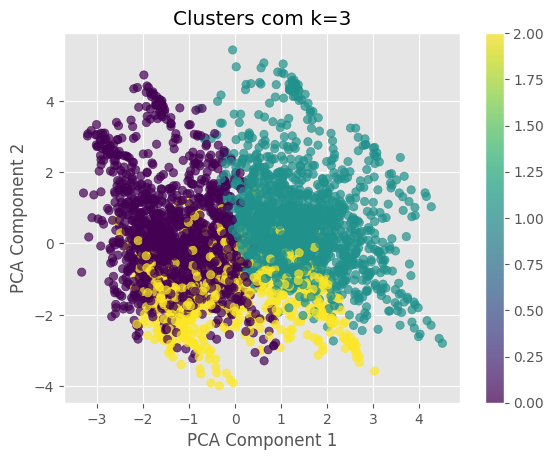

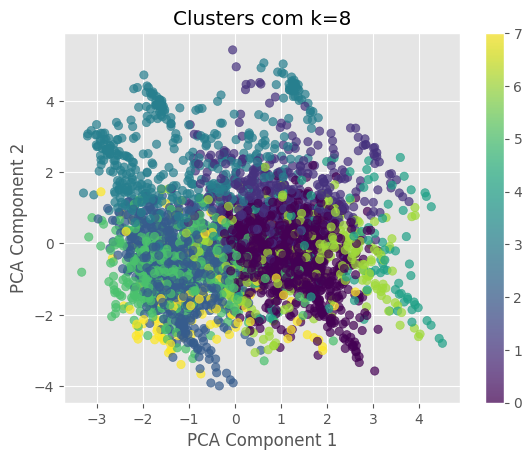

In [ ]:
from pyspark.ml.feature import PCA

# Função para realizar PCA e visualização
def plot_pca_clusters(df, k):
    pca = PCA(k=2, inputCol="scaled_features", outputCol="pca_features")
    pca_model = pca.fit(df)
    df_pca = pca_model.transform(df)

    pca_data = df_pca.select("pca_features", "cluster").collect()
    x = [row["pca_features"][0] for row in pca_data]
    y = [row["pca_features"][1] for row in pca_data]
    clusters = [row["cluster"] for row in pca_data]

    plt.scatter(x, y, c=clusters, cmap="viridis", marker="o", alpha=0.7)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title(f"Clusters com k={k}")
    plt.colorbar()
    plt.show()

# Plotar clusters para k=3
kmeans_3 = KMeans(k=3, seed=42, featuresCol="scaled_features", predictionCol="cluster")
model_3 = kmeans_3.fit(df_scaled)
df_clusters_3 = model_3.transform(df_scaled)
plot_pca_clusters(df_clusters_3, 3)

# Plotar clusters para k=8
kmeans_8 = KMeans(k=8, seed=42, featuresCol="scaled_features", predictionCol="cluster")
model_8 = kmeans_8.fit(df_scaled)
df_clusters_8 = model_8.transform(df_scaled)
plot_pca_clusters(df_clusters_8, 8)


# 8.4 - Join entre clusters e amostra:

In [ ]:
df_cluster_c.show(3)

In [ ]:
# Lista de todas as colunas do df_cluster_c
cols_df_cluster_c = df_cluster_c.columns

# Realizar a junção e selecionar as colunas desejadas
df_clean_with_cluster = df_cluster_c.join(df_clusters, on='CODMUNOCOR', how='right') \
    .select(*cols_df_cluster_c, "cluster")

In [ ]:
# Exibir as primeiras 5 linhas do DataFrame resultante
#df_clean_with_cluster.show(3)
df_clean_with_cluster.count()

# 8.5 - Resumo dos Clusters

# 8.5.1 - Proporções das colunas categóricas nos clusters:

### 8.5.2 - Quantidade de Óbitos por cluster:

In [ ]:
# Separar o DataFrame em 3 DataFrames diferentes com base no cluster
df_cluster_0 = df_clean_with_cluster.filter(df_clean_with_cluster["cluster"] == 0)
df_cluster_1 = df_clean_with_cluster.filter(df_clean_with_cluster["cluster"] == 1)
df_cluster_2 = df_clean_with_cluster.filter(df_clean_with_cluster["cluster"] == 2)


# Exibir a contagem de registros em cada cluster para verificação
print("Cluster 0:", df_cluster_0.count())
print("Cluster 1:", df_cluster_1.count())
print("Cluster 2:", df_cluster_2.count())



Cluster 0: 77497
Cluster 1: 18940
Cluster 2: 2107


In [94]:
# Dicionário de mapeamento para as colunas categóricas
category_mappings = {
    "RACACOR": {
        "1": "Branca",
        "2": "Preta",
        "3": "Amarela",
        "4": "Parda",
        "5": "Indígena",
        None: "Ignorado"
    },
    "ESTCIV": {
        "1": "Solteiro",
        "2": "Casado",
        "3": "Viúvo",
        "4": "Divorciado",
        "5": "União estável",
        "9": "Ignorado",
        None: "Ignorado"
    },
    "ESC": {
        "1": "Nenhuma",
        "2": "de 1 a 3 anos",
        "3": "de 4 a 7 anos",
        "4": "de 8 a 11 anos",
        "5": "12 anos e mais",
        "9": "Ignorado",
        None: "Ignorado"
    }
}

# Função para calcular proporções dentro de um cluster e aplicar o mapeamento
def calculate_proportions_and_map(df, column):
    df_proportions = df.groupBy(column) \
        .agg(F.count("*").alias("count")) \
        .withColumn("percentage", (F.col("count") / F.sum("count").over(Window.partitionBy())) * 100)

    # Aplicar o mapeamento
    df_mapped = df_proportions.rdd.map(lambda row: (
        category_mappings[column].get(str(row[column]), "Desconhecido"),
        row['count'],
        row['percentage']
    )).toDF(["Category", "Count", "Percentage"])

    return df_mapped


In [95]:
# Cálculo das proporções para cada coluna em cada cluster, com mapeamento
# Cluster 0
df_racacor_0 = calculate_proportions_and_map(df_cluster_0, "RACACOR")
df_estciv_0 = calculate_proportions_and_map(df_cluster_0, "ESTCIV")
df_esc_0 = calculate_proportions_and_map(df_cluster_0, "ESC")

# Cluster 1
df_racacor_1 = calculate_proportions_and_map(df_cluster_1, "RACACOR")
df_estciv_1 = calculate_proportions_and_map(df_cluster_1, "ESTCIV")
df_esc_1 = calculate_proportions_and_map(df_cluster_1, "ESC")

# Cluster 2
df_racacor_2 = calculate_proportions_and_map(df_cluster_2, "RACACOR")
df_estciv_2 = calculate_proportions_and_map(df_cluster_2, "ESTCIV")
df_esc_2 = calculate_proportions_and_map(df_cluster_2, "ESC")

# Converter os DataFrames Spark para Pandas para plotagem
# Cluster 0
df_racacor_0_pd = df_racacor_0.toPandas()
df_estciv_0_pd = df_estciv_0.toPandas()
df_esc_0_pd = df_esc_0.toPandas()

# Cluster 1
df_racacor_1_pd = df_racacor_1.toPandas()
df_estciv_1_pd = df_estciv_1.toPandas()
df_esc_1_pd = df_esc_1.toPandas()

# Cluster 2
df_racacor_2_pd = df_racacor_2.toPandas()
df_estciv_2_pd = df_estciv_2.toPandas()
df_esc_2_pd = df_esc_2.toPandas()



# 8.5.3 - Mortalidade por 100.000 habitantes por cluster e média da idade por cluster:

In [100]:
from pyspark.sql import functions as F

# Calcular o número de óbitos por município para cada cluster
df_cluster_0_counts = df_cluster_0.groupBy("CODMUNOCOR").agg(F.count("*").alias("death_count"), F.first("populacao").alias("populacao"))
df_cluster_1_counts = df_cluster_1.groupBy("CODMUNOCOR").agg(F.count("*").alias("death_count"), F.first("populacao").alias("populacao"))
df_cluster_2_counts = df_cluster_2.groupBy("CODMUNOCOR").agg(F.count("*").alias("death_count"), F.first("populacao").alias("populacao"))

# Calcular a mortalidade por 100.000 habitantes
df_cluster_0_counts = df_cluster_0_counts.withColumn("mortality_per_100k", (F.col("death_count") / F.col("populacao")) * 100000)
df_cluster_1_counts = df_cluster_1_counts.withColumn("mortality_per_100k", (F.col("death_count") / F.col("populacao")) * 100000)
df_cluster_2_counts = df_cluster_2_counts.withColumn("mortality_per_100k", (F.col("death_count") / F.col("populacao")) * 100000)

# Calcular a média da mortalidade por 100.000 habitantes por cluster
mean_mortality_cluster_0 = df_cluster_0_counts.agg(F.mean("mortality_per_100k")).first()[0]
mean_mortality_cluster_1 = df_cluster_1_counts.agg(F.mean("mortality_per_100k")).first()[0]
mean_mortality_cluster_2 = df_cluster_2_counts.agg(F.mean("mortality_per_100k")).first()[0]

# Calcular a média da idade por cluster
mean_age_cluster_0 = df_cluster_0.agg(F.mean("IDADE")).first()[0]
mean_age_cluster_1 = df_cluster_1.agg(F.mean("IDADE")).first()[0]
mean_age_cluster_2 = df_cluster_2.agg(F.mean("IDADE")).first()[0]

output = (
    f"Cluster 0 - Média de Idade: {mean_age_cluster_0:.2f} anos, Mortalidade por 100.000 habitantes: {mean_mortality_cluster_0:.2f}",
    f"Cluster 1 - Média de Idade: {mean_age_cluster_1:.2f} anos, Mortalidade por 100.000 habitantes: {mean_mortality_cluster_1:.2f}",
    f"Cluster 2 - Média de Idade: {mean_age_cluster_2:.2f} anos, Mortalidade por 100.000 habitantes: {mean_mortality_cluster_2:.2f}"
)

output

('Cluster 0 - Média de Idade: 62.41 anos, Mortalidade por 100.000 habitantes: 90.63',
 'Cluster 1 - Média de Idade: 60.96 anos, Mortalidade por 100.000 habitantes: 49.00',
 'Cluster 2 - Média de Idade: 60.23 anos, Mortalidade por 100.000 habitantes: 49.03')

# 8.5.4 - Resumo dos Resultados por Cluster

# 8.5.5 - Cluster 0

<ipython-input-97-957685cfe6fa>:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Category', y='Percentage', data=sorted_data, ax=axes[i], color=colors[i], ci=None)
<ipython-input-97-957685cfe6fa>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right', fontsize=12)
<ipython-input-97-957685cfe6fa>:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Category', y='Percentage', data=sorted_data, ax=axes[i], color=colors[i], ci=None)
<ipython-input-97-957685cfe6fa>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right', fontsize=12)
<ipython-input-97-957685cfe6fa>:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.bar

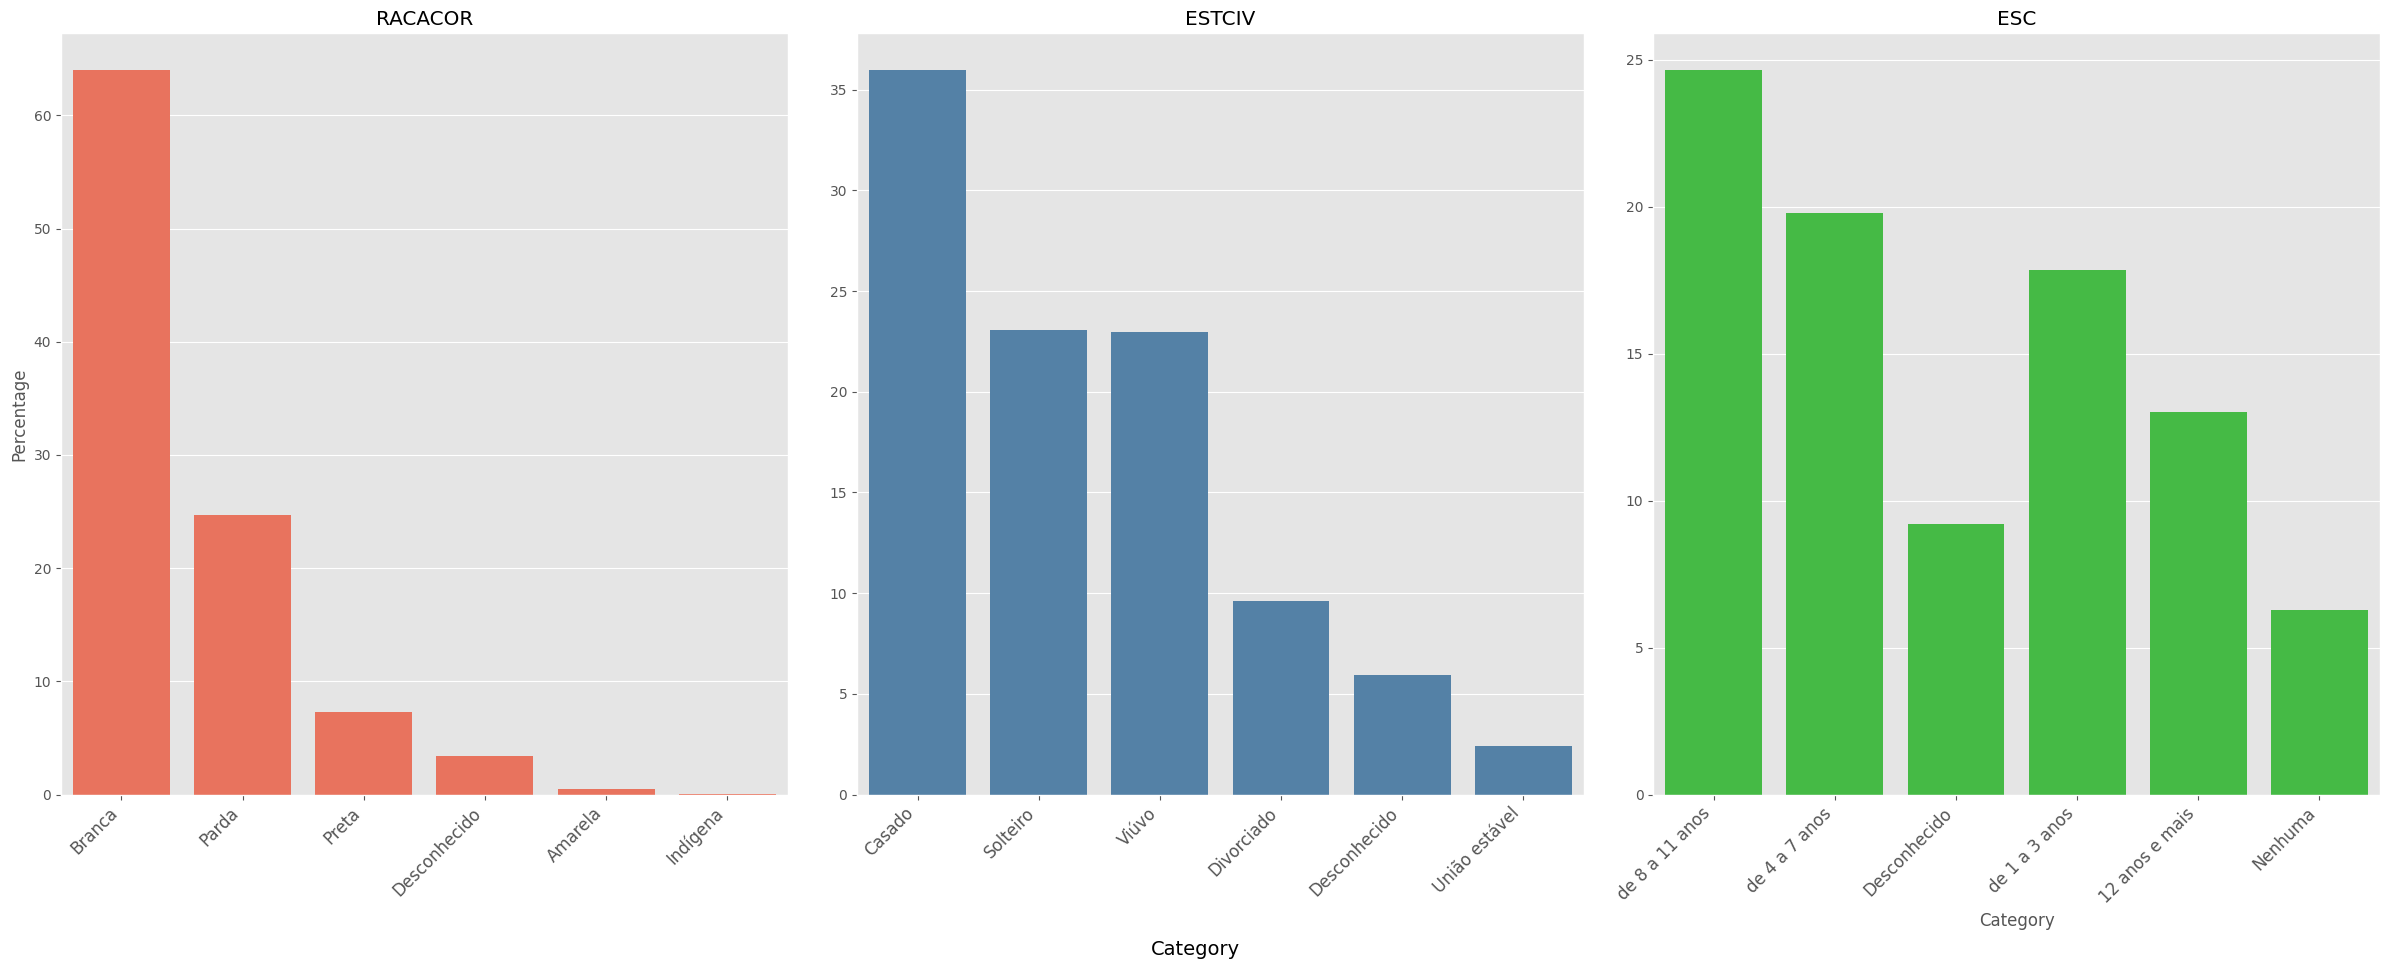

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

# Definir o estilo 'ggplot' para matplotlib
plt.style.use('ggplot')

# Cores mais vivas para cada gráfico
colors = ["#FF6347", "#4682B4", "#32CD32"]  # Vermelho Tomate, Azul Aço, Verde Lima

# Aumentar o tamanho da figura para melhorar a visualização
fig, axes = plt.subplots(1, 3, figsize=(24, 10))

# Nome das colunas e os respectivos DataFrames para plotagem
dataframes_cluster_0 = [df_racacor_0_pd, df_estciv_0_pd, df_esc_0_pd]
titles = ["RACACOR", "ESTCIV", "ESC"]

# Plotagem para Cluster 0
for i in range(len(dataframes_cluster_0)):
    # Ordenar os dados em ordem decrescente
    sorted_data = dataframes_cluster_0[i].sort_values(by='Percentage', ascending=False)

    sns.barplot(x='Category', y='Percentage', data=sorted_data, ax=axes[i], color=colors[i], ci=None)
    axes[i].set_title(titles[i])
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right', fontsize=12)

    # Remover o rótulo 'Percentage' dos gráficos do meio e da direita
    if i > 0:
        axes[i].set_ylabel("")

    # Remover o rótulo 'Category' dos gráficos da esquerda e do meio
    if i < len(dataframes_cluster_0) - 1:
        axes[i].set_xlabel("")

# Centralizar o rótulo 'Category' na figura
fig.text(0.5, 0.04, 'Category', ha='center', fontsize=14)

# Ajustar o layout para melhorar o enquadramento
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Deixar espaço na parte inferior para o rótulo centralizado
plt.show()



### Informações Gerais
- **População**: Maior proporção de indivíduos identificados como brancos, seguida pela população parda.
- **Estado Civil**: A maioria dos indivíduos é casada, seguida por uma proporção considerável de solteiros e viúvos.
- **Escolaridade**: Predominância de escolaridade de 8 a 11 anos, seguida de 1 a 3 anos.
- **Observação Geral**: Este cluster é caracterizado por uma população predominantemente branca, com uma distribuição significativa entre indivíduos casados e com escolaridade de 8 a 11 anos. A diversidade racial é limitada, com uma predominância clara de brancos e pardos.
- **Média de Idade:** 62,41 anos

- **Mortalidade por 100.000 Habitantes:** 90.63


# 8.5.6 - Cluster 1

<ipython-input-101-961dd04915a1>:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Category', y='Percentage', data=sorted_data, ax=axes[i], color=colors[i], ci=None)
<ipython-input-101-961dd04915a1>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right', fontsize=12)
<ipython-input-101-961dd04915a1>:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Category', y='Percentage', data=sorted_data, ax=axes[i], color=colors[i], ci=None)
<ipython-input-101-961dd04915a1>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right', fontsize=12)
<ipython-input-101-961dd04915a1>:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sn

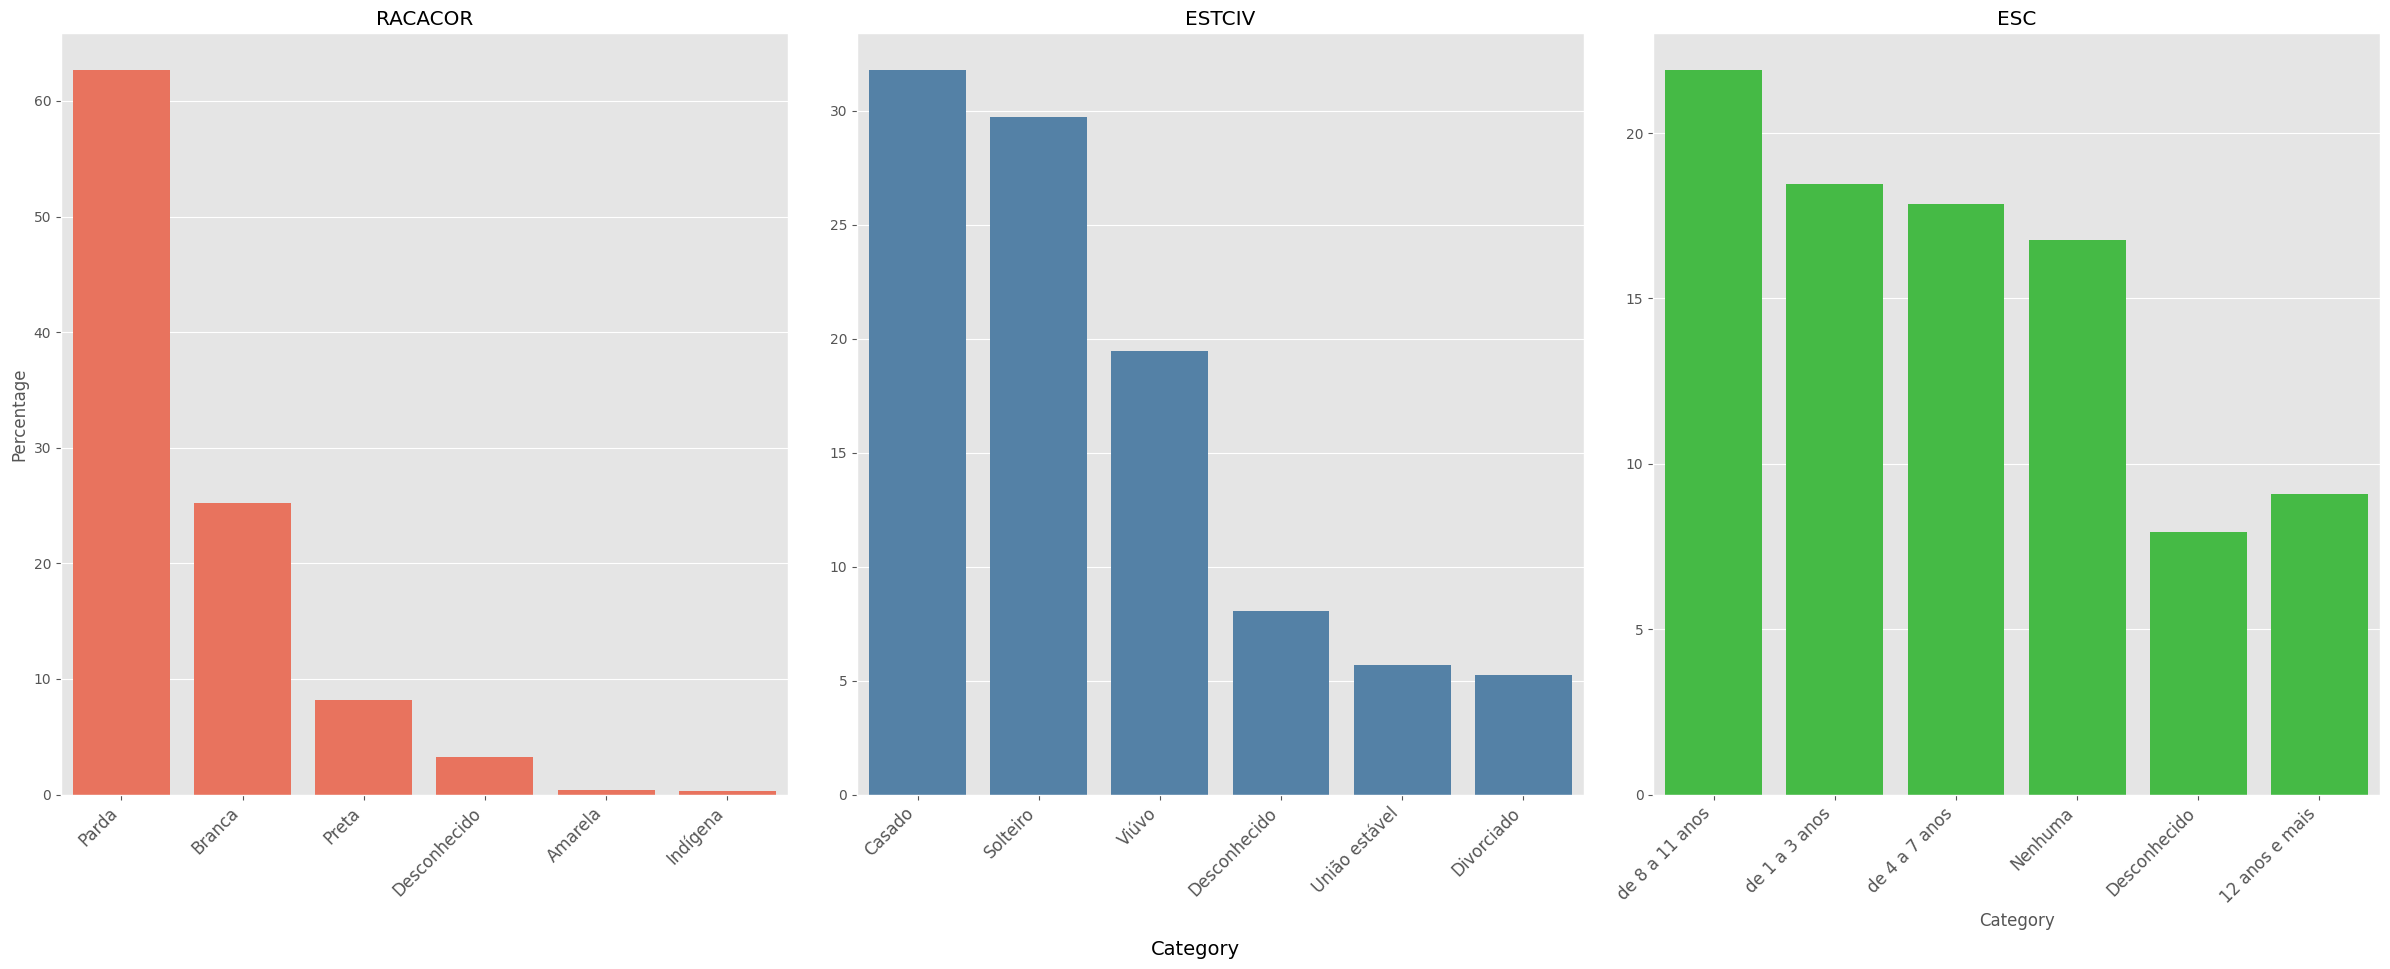

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

# Definir o estilo 'ggplot' para matplotlib
plt.style.use('ggplot')

# Cores mais vivas para cada gráfico
colors = ["#FF6347", "#4682B4", "#32CD32"]  # Vermelho Tomate, Azul Aço, Verde Lima

# Aumentar o tamanho da figura para melhorar a visualização
fig, axes = plt.subplots(1, 3, figsize=(24, 10))

# Nome das colunas e os respectivos DataFrames para plotagem do Cluster 1
dataframes_cluster_1 = [df_racacor_1_pd, df_estciv_1_pd, df_esc_1_pd]
titles = ["RACACOR", "ESTCIV", "ESC"]

# Plotagem para Cluster 1
for i in range(len(dataframes_cluster_1)):
    # Ordenar os dados em ordem decrescente
    sorted_data = dataframes_cluster_1[i].sort_values(by='Percentage', ascending=False)

    sns.barplot(x='Category', y='Percentage', data=sorted_data, ax=axes[i], color=colors[i], ci=None)
    axes[i].set_title(titles[i])
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right', fontsize=12)

    # Remover o rótulo 'Percentage' dos gráficos do meio e da direita
    if i > 0:
        axes[i].set_ylabel("")

    # Remover o rótulo 'Category' dos gráficos da esquerda e do meio
    if i < len(dataframes_cluster_1) - 1:
        axes[i].set_xlabel("")

# Centralizar o rótulo 'Category' na figura
fig.text(0.5, 0.04, 'Category', ha='center', fontsize=14)

# Ajustar o layout para melhorar o enquadramento
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Deixar espaço na parte inferior para o rótulo centralizado
plt.show()


### Informações Gerais
- **População**: Predominância de indivíduos identificados como pardos, seguidos pela população branca.
- **Estado Civil**: Alta proporção de indivíduos casados, seguidos por solteiros e viúvos.
- **Escolaridade**: Predominância de escolaridade de 8 a 11 anos, seguida de 1 a 3 anos.
- **Observação Geral**: Este cluster agrupa cidades com uma população majoritariamente parda, com uma distribuição significativa de indivíduos casados e com escolaridade de 8 a 11 anos. A diversidade racial é maior, com uma proporção relevante de indivíduos brancos e pretos, mas ainda dominada pelos pardos.
- **Média de Idade:** 60.96 anos
- **Mortalidade por 100.000 Habitantes:** 49.00

# 8.5.7 - Cluster 2

<ipython-input-99-b5644815bcd9>:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Category', y='Percentage', data=sorted_data, ax=axes[i], color=colors[i], ci=None)
<ipython-input-99-b5644815bcd9>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right', fontsize=12)
<ipython-input-99-b5644815bcd9>:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Category', y='Percentage', data=sorted_data, ax=axes[i], color=colors[i], ci=None)
<ipython-input-99-b5644815bcd9>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right', fontsize=12)
<ipython-input-99-b5644815bcd9>:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.bar

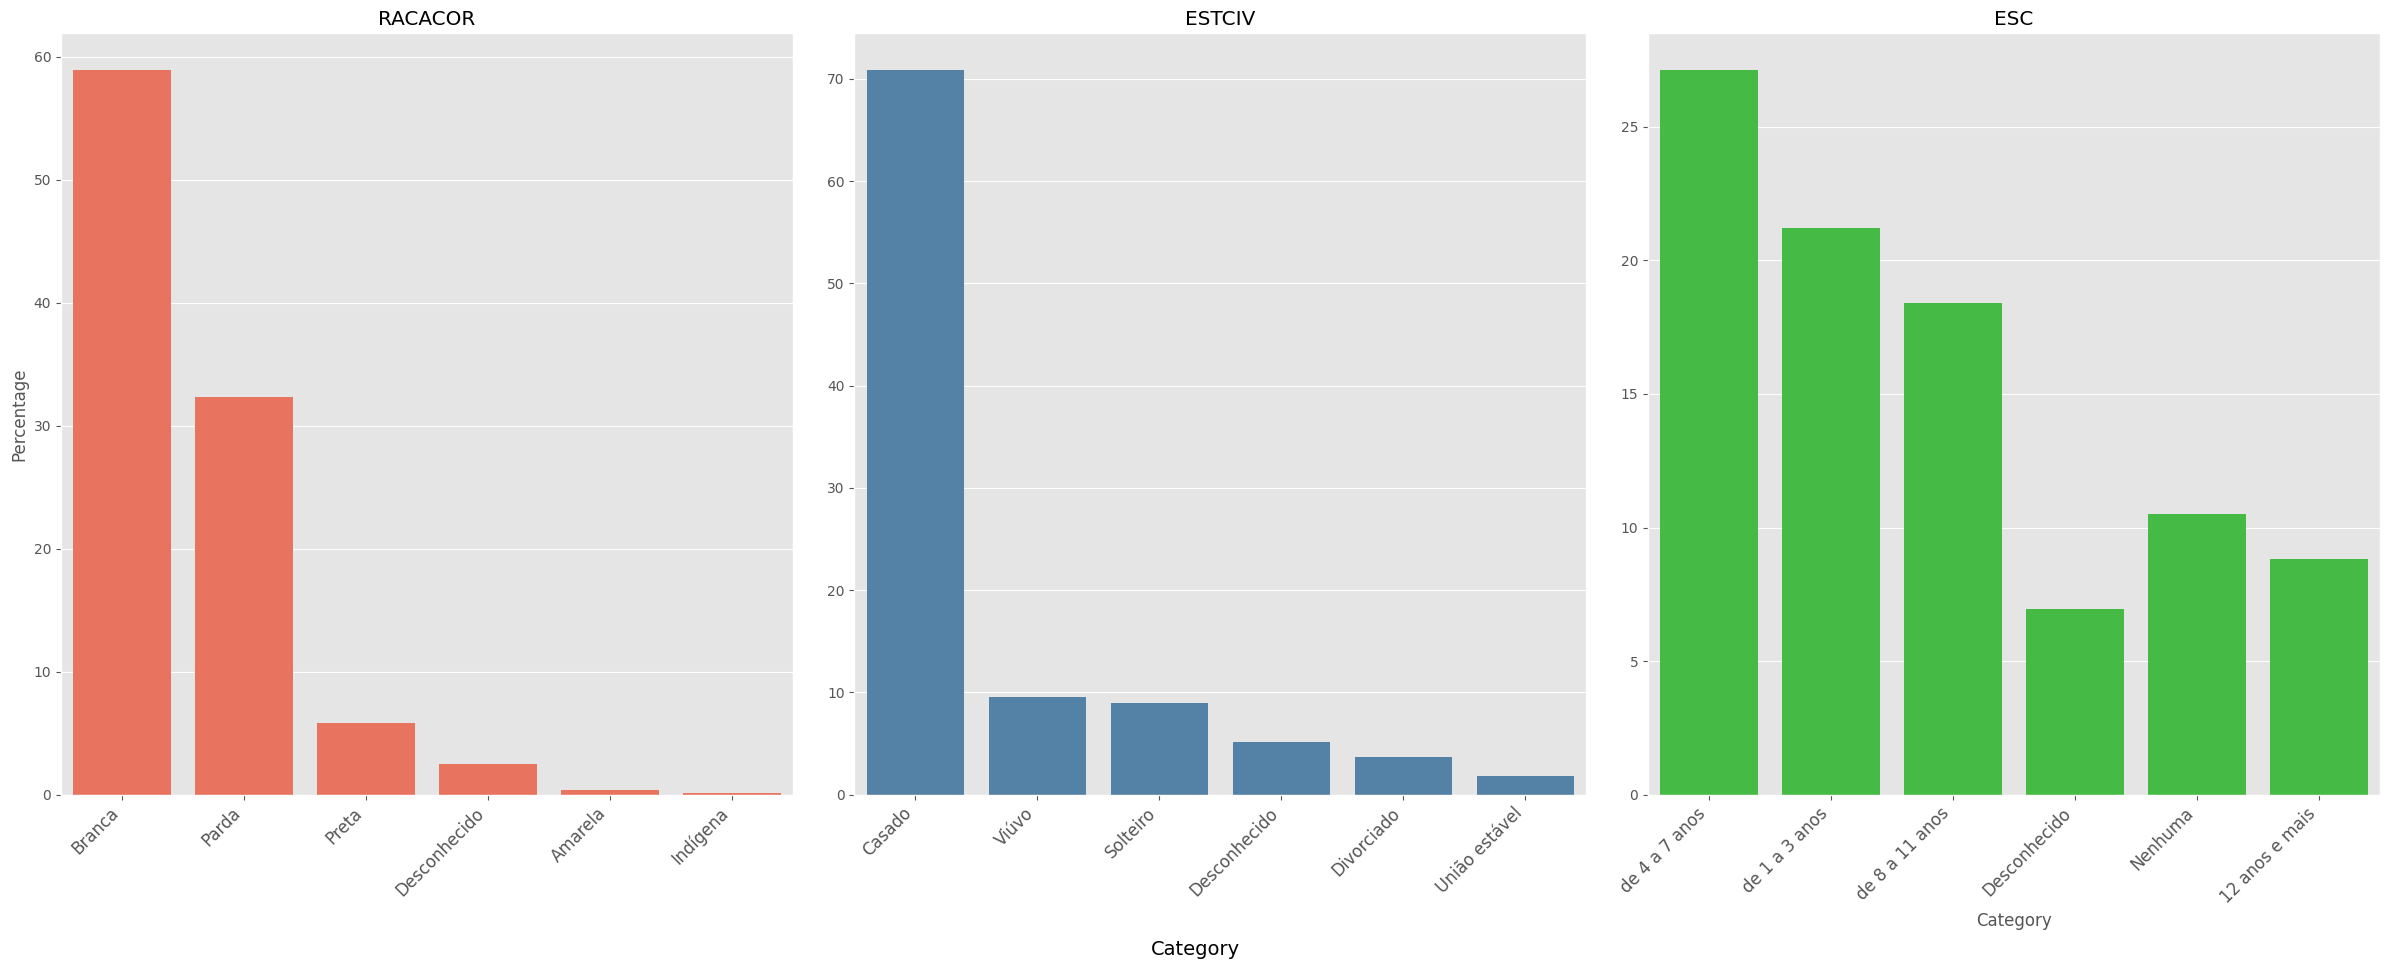

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

# Definir o estilo 'ggplot' para matplotlib
plt.style.use('ggplot')

# Cores mais vivas para cada gráfico
colors = ["#FF6347", "#4682B4", "#32CD32"]  # Vermelho Tomate, Azul Aço, Verde Lima

# Aumentar o tamanho da figura para melhorar a visualização
fig, axes = plt.subplots(1, 3, figsize=(24, 10))

# Nome das colunas e os respectivos DataFrames para plotagem do Cluster 2
dataframes_cluster_2 = [df_racacor_2_pd, df_estciv_2_pd, df_esc_2_pd]
titles = ["RACACOR", "ESTCIV", "ESC"]

# Plotagem para Cluster 2
for i in range(len(dataframes_cluster_2)):
    # Ordenar os dados em ordem decrescente
    sorted_data = dataframes_cluster_2[i].sort_values(by='Percentage', ascending=False)

    sns.barplot(x='Category', y='Percentage', data=sorted_data, ax=axes[i], color=colors[i], ci=None)
    axes[i].set_title(titles[i])
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right', fontsize=12)

    # Remover o rótulo 'Percentage' dos gráficos do meio e da direita
    if i > 0:
        axes[i].set_ylabel("")

    # Remover o rótulo 'Category' dos gráficos da esquerda e do meio
    if i < len(dataframes_cluster_2) - 1:
        axes[i].set_xlabel("")

# Centralizar o rótulo 'Category' na figura
fig.text(0.5, 0.04, 'Category', ha='center', fontsize=14)

# Ajustar o layout para melhorar o enquadramento
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Deixar espaço na parte inferior para o rótulo centralizado
plt.show()


### Informações Gerais
- **População**: Predominância de indivíduos identificados como pardos, seguidos pela população branca.
- **Estado Civil**: Maior proporção de indivíduos casados, seguida de uma distribuição considerável entre solteiros e viúvos.
- **Escolaridade**: Diversidade nos níveis de escolaridade, com predominância de escolaridade de 8 a 11 anos, seguida de 1 a 3 anos.
- **Observação Geral**: Este cluster reflete uma população predominantemente parda, com maior diversidade em termos de escolaridade e estado civil. A escolaridade é variada, com um número significativo de indivíduos com níveis de educação intermediários e superiores.
- **Média de Idade:** 60.23 anos
- **Mortalidade por 100.000 Habitantes:** 49.03

# Próximos passos:





### Próximos Passos para Expansão e Melhoria da Análise

1. **Aprimoramento do Código**
   - Remover trechos de código que não são mais necessários.
   - Dividir o código em funções menores e mais organizadas.

2. **Integração de Dados de Internações**
   - Combinar os dados de mortalidade com dados de internações hospitalares para explorar possíveis relações.
   - Ajustar as taxas de mortalidade com base nos dados de internações, analisando por cidade e por cluster.
   - Examinar como as internações influenciam as taxas de mortalidade, especialmente entre diferentes clusters.

3. **Análise da Infraestrutura de Saúde das Cidades**
   - Comparar dados de infraestrutura com os clusters para entender como a disponibilidade de recursos impacta as taxas de mortalidade.
   - Identificar possíveis deficiências na infraestrutura de saúde que possam estar contribuindo para maiores taxas de mortalidade.

4. **Análise de Recursos e Profissionais de Saúde**
   - Avaliar a distribuição de equipamentos médicos essenciais e a presença de profissionais de saúde nas cidades de cada cluster.
   - Entender como a disponibilidade desses recursos se relaciona com a qualidade dos cuidados de saúde e com os resultados de mortalidade.

5. **Resumo de Insights e Principais Descobertas**
   - Criar uma seção que resuma os principais resultados da análise, usando uma linguagem acessível e direta.
   - Estruturar o resumo para ser facilmente compreendido, destacando as diferenças entre os clusters e as sugestões baseadas nos insights encontrados.